# ROADEF challenge

# Libraries

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import argparse
from collections import defaultdict, namedtuple
import copy
from datetime import datetime
import itertools
from gurobipy import *
import os
from pathlib import Path
import time
import numpy as np

## Things that Fynn needs:

In [3]:
import polars as pl
import tensorflow as tf
from tensorflow import keras

import io
from contextlib import redirect_stdout

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context="talk",style="darkgrid")

In [4]:
import os
from keras import backend as K
root = os.getcwd()
cwd, _ = os.path.split(root)

model_path = os.path.join(cwd, "models", "NumberImprovementPrediction-11.tf")

PAD_SIZE = 80
model = tf.keras.models.load_model(model_path)
model.summary()

2023-11-26 13:55:49.999940: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-11-26 13:55:49.999976: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-26 13:55:49.999980: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-26 13:55:50.000174: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-26 13:55:50.000192: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 StackLevelInputFeatures (I  [(None, 80, 9)]              0         []                            
 nputLayer)                                                                                       
                                                                                                  
 MaskingLayer (Masking)      (None, 80, 9)                0         ['StackLevelInputFeatures[0][0
                                                                    ]']                           
                                                                                                  
 transformer_encoder (Trans  ((None, 80, 9),              330       ['MaskingLayer[0][0]']        
 formerEncoder)               (None, 5, 80, 80))                                              

In [5]:
### Loading CSVs

In [6]:
folder = "truck-item-infos"
file = "items.csv"

item_path = os.path.join(cwd, folder, file)
items = pl.read_csv(source = item_path);

items = items.lazy().with_columns([
    (pl.col("Item ident").alias("item_id")),
    (pl.col("Length") / 1000), # mm to m
    (pl.col("Width") / 1000),  # mm to m
    (pl.col("Height") / 1000), # mm to m
    (pl.col("Nesting height") / 1000), # mm to m
    (pl.col("Weight") / 1000), # kg to tons
    (pl.col("Forced orientation") == "lengthwise").alias("ForcedLength"),
    (pl.col("Forced orientation") == "widthwise").alias("ForcedWidth"),
    ((pl.col("Height") - pl.col("Nesting height")) / 1000).alias("NestedHeight"),
    pl.col("dataset").str.extract("([A-Z])")
]).drop([
    "Forced orientation", "Max stackability", "Inventory cost",
    "Earliest arrival time", "Latest arrival time", "Number of items",
    "instance_id",
    "Stackability code",
    "Item ident" # drop because of rename earlier
]).unique()

items.collect().head()

Supplier code,Supplier dock,Plant code,Plant dock,Product code,Package code,Length,Width,Height,Weight,Nesting height,dataset,instance,item_id,ForcedLength,ForcedWidth,NestedHeight
i64,str,i64,str,str,str,f64,f64,f64,f64,f64,str,str,str,bool,bool,f64
2695000,null,90016900,"""GRF1""","""271002239R""","""ECM---6655""",2.4,1.2,0.76,0.243,0.045,"""C""","""BY""","""0090016900_270…",false,false,0.715
1925700,null,90016900,"""GRF1""","""682116715R""","""SFDA--9767""",1.2,1.0,0.975,0.1463,0.045,"""C""","""BY""","""0090016900_270…",false,false,0.93
21798202,null,90016900,"""GRD1""","""144605995R""","""SLI---0770""",1.2,1.0,0.975,0.181,0.045,"""C""","""BY""","""0090016900_270…",false,false,0.93
1925700,null,90016900,"""GRF1""","""684305630R""","""KFDA--0047""",1.209,1.007,0.75,0.120524,0.025,"""C""","""BY""","""0090016900_270…",false,false,0.725
26242400,null,90016900,"""169GD-20""","""511603762R""","""SLI---0901""",1.6,1.2,0.75,0.2647,0.045,"""C""","""BY""","""0090016900_270…",false,false,0.705


In [7]:
file = "trucks.csv"

truck_path = os.path.join(cwd, folder, file)

truck_clms = ["Id truck", "dataset", "instance",
              "Supplier code", "Supplier dock", "Plant dock",
              "Supplier loading order", "Supplier dock loading order", "Plant dock loading order",
             ]

truck_stops = (
    pl.read_csv(source = truck_path, columns = truck_clms)
    .lazy()
    .rename({"Id truck": "truck_id"})
    .sort(["dataset", "instance", "truck_id"])
    .with_columns([pl.col("dataset").str.extract("(\w)")])
    .unique()
)
truck_stops.collect().head()

Supplier code,Supplier loading order,Supplier dock,Supplier dock loading order,Plant dock,Plant dock loading order,truck_id,dataset,instance
i64,i64,str,i64,str,i64,str,str,str
62059600,1,null,1,"""X0""",1,"""P187721701""","""A""","""AS"""
29908700,1,null,1,"""X4""",1,"""P187730403""","""A""","""AS"""
29908700,1,null,1,"""X4""",1,"""P188721401""","""A""","""AS"""
62060800,1,null,1,"""X2""",1,"""P188731303""","""A""","""AS"""
62059600,1,null,1,"""X0""",1,"""P189731001""","""A""","""AS"""


In [8]:
file = "trucks.csv"

truck_path = os.path.join(cwd, folder, file)

truck_clms = ["Id truck", "dataset", "instance",
              "Length", "Width", "Max weight",
              "EMmm", "EMmr"
             ]

truck_dims = (
    pl.read_csv(source = truck_path, columns = truck_clms)
    .lazy()
    .rename({"Id truck": "truck_id", "Max weight": "Weight"})
    .sort(["dataset", "instance", "truck_id"])
    .with_columns([pl.col("dataset").str.extract("(\w)")])
    .unique()
)

truck_dims = truck_dims.with_columns([
    (pl.col("Length") / 1000),
    (pl.col("Width") / 1000),
    (pl.col("Weight") / 1000),
    (pl.col("EMmm") / 1000),
    (pl.col("EMmr") / 1000),
])

truck_dims.collect().head()

truck_id,Length,Width,Weight,EMmm,EMmr,dataset,instance
str,f64,f64,f64,f64,f64,str,str
"""P187731001""",14.94,2.5,24.0,12.0,31.5,"""A""","""AS"""
"""P188730407""",14.94,2.5,24.0,12.0,31.5,"""A""","""AS"""
"""P189721701""",14.94,2.5,24.0,12.0,31.5,"""A""","""AS"""
"""P189730401""",14.94,2.5,24.0,12.0,31.5,"""A""","""AS"""
"""P189731005""",14.94,2.5,24.0,12.0,31.5,"""A""","""AS"""


In [9]:
import sys
sys.path.append("..")

from utils.preprocessing import extract_raw_data, explode_instances_into_stacks, explode_stacks_into_items
from utils.preprocessing import join_items, group_items_by_stack, join_truck_loading_order, append_truck_info

In [10]:
def get_tensor_representation(X, packing_clm=6):

    # add columns for Length and Width Remainder
    X = np.append(X, np.zeros((X.shape[0], 2)), axis=1)
    
    indices = np.unique(X[:, 0])
    indices = np.sort(indices)

    # (batch_size, ?, features)
    X = np.array([X[X[:,0] == idx] for idx in indices], dtype = "object")

    # replace the packing order with the stop index (i.e 1-1-1 and 1-1-2 turn to 0 and 1, respectively)
    #packing_clm = min([i for i, clm in enumerate(df.columns) if clm == "packing_order"])
    
    for i, x in enumerate(X):
        packing_order = x[:,packing_clm]
        stops = np.unique(packing_order)
        stops = np.sort(stops)
        stops = {stop: j for j, stop in enumerate(stops)}
        stops = [stops[order] for order in packing_order]
        X[i][:,packing_clm] = stops

    # pad the variable length number of stacks into fixed
    #  (batch_size, pad_size, features)
    X = tf.keras.utils.pad_sequences(X, maxlen=PAD_SIZE, padding = "post", dtype="float64")
    # drop the index column (batch_size, pad_len, n_features)
    X = X[:,:,1:].astype(float)

    # Add Length and width Remainder
    for xx in X:
        truck_width = max(xx[:,1])
        # Length Remainder
        xx[:,-2] = truck_width % xx[:,0]
        # Width Remainder
        xx[:,-1] = truck_width % xx[:,1]
    
    X = np.nan_to_num(X)
    
    return X

In [11]:
def polars_transformation(X_batch, shuffle=True) -> np.array:
    """

    Returns:
    --------
    X: np.array[float32]
        3D Feature Tensor of shape (Batch_size, Pad_size, n_features=7)

        - Batch_size: Truck Optimization Instances
        - Pad_size: Stacks (or Trucks), padded up to create tensors
        - n_features: Length, Width, Weight, L/W Forced Orientation
                      packing order, is_truck
    """
    
    df = pl.DataFrame({"raw": X_batch})
    
    X = (
        df.lazy()
        .pipe(extract_raw_data)
        .pipe(explode_instances_into_stacks)
        .pipe(explode_stacks_into_items)
        .pipe(join_items, items)
        .pipe(group_items_by_stack)
        .pipe(join_truck_loading_order, truck_stops)
        .pipe(append_truck_info, truck_dims)
        .collect()
        .to_numpy()
    )

    X = get_tensor_representation(X)

    # fill final column with bool for stack not in initial solution
    pattern = "Stack (\d*) missing:"
    x = df["raw"].str.extract_all(pattern).map_elements(lambda x: [int(i.split(" ")[1]) for i in x])

    for i, missing_stacks in enumerate(x):
        for j in missing_stacks:
            X[i, j, 6] +=1

    
    # extract the time limit
    pattern = "2D Packing MIP with Time Limit (\d*\.?\d*) \[s\]"
    x_time_limit = df["raw"].str.extract(pattern).cast(pl.Float32).to_numpy()

    #y_batch = y_batch.numpy()
    #y_batch = [y_batch]
    #y_extra = get_additional_labels(df)

    if shuffle:
        idx = np.arange(X.shape[1])
        idx = np.random.choice(idx, size=PAD_SIZE, replace=False)
        X = X[:,idx,:]
        y_extra[-1] = y_extra[-1][:,idx]

    
    #y_batch += y_extra
    # Drop y_batch
    #y_batch = y_extra

    X = [X, x_time_limit]
    
    return X

#c = polars_transformation(X, shuffle=False)

### Following names are reserverd only for one usage

tt: ID of truck as in the data, i.e. the original id

ii: ID if item as in the data

jjT: Counter index for truck

jjI: Counter index for item


### Naming conventions:

Sets start with uppercase: I, IOrdered, T

Parameter start with lowercase: num, il, tl

### Parameters created by ourself follow the additional naming conventions:

Try to use names that are self describing

If multiple words describe the parameter, each word besides the first word start with an uppercase: numTrucks, numItems, vol2D, numItemsLoaded

Dictionaries are indicated by an underscore followed by the key: num_Item, num_Truck

If multiple keys, each key starts with an uppercase: num_TruckItem, vol2D_TruckGroup

Nested dictionaries are seperated by an underscore, the order of the dictionaries is from left to right: num_Truck_Item -> First dict has tt as index, second dict has ii as index



# Data objects

Data objects for trucks, items and parameter (factors, time) storing the information of the instance, as well as defined or calculated parameters from us

## DataTrucks

In [12]:
class DataTrucks(object):
    def __init__(self):
        # Sets
        self.T = set()  # Trucks
        self.U = set()  # Suppliers
        self.K = set()  # Supplier docks
        self.P = set()  # Plants
        self.G = set()  # Plant docks
        self.Gamma = set()  # Products
        
        self.TR = dict()  # Products that can be picked up by Truck t (subset of Y)
        self.TU = dict()  # Suppliers that will be visited by Truck t (subset of U)
        self.TK = dict()  # Supplier docks that will be visited by Truck t of supplier u (subset of K)
        self.TG = dict()  # Plant docks that will be visited by Truck t of plant (subset of G)

        # Parameter
        self.tl = dict()  # Length
        self.tw = dict()  # Width
        self.th = dict()  # Height
        self.tm = dict()  # Maximum loading Weight
        self.tp = dict()  # Destination plant
        self.tda = dict()  # Arrival time
        self.tmm = dict()  # Maximum weight of a stack above the bottom item of product gamma, key: (t, gamma)
        self.tf = dict()  # Multi stack
        self.tem = dict()  # Maximum density of stacks
        self.tc = dict()  # Cost
        self.te = dict()  # Loading order for supplier u, key: (t, u)
        self.tke = dict()  # Loading order for dock k of supplier u, key: (t, u, k)
        self.tge = dict()  # Loading order for dock g of plant p, key: (t, p, g)
        
        # Parameter weights for truck (consist of tractor and trailer)
        # Tractor
        self.cm = dict()  # Weight
        self.cjfm = dict()  # Distance between front and middle axis
        self.cjfc = dict()  # Distance between front axle and center of gravity
        self.cjfh = dict()  # Distance between front axle and harness
        # Trailer
        self.em = dict()  # Weight of empty trailer
        self.ejhr = dict()  # Distance between harness and rear axis
        self.ejcr = dict()  # Distance between center of gravity and rear axis
        self.ejeh = dict()  # Distance between start of trailer and harness
        self.emmr = dict()  # Max weight on rear axle
        self.emmm = dict()  # Max weight on middle axle
        
        self.tcPseudo = dict()
        self.tvol2D = dict()  # in m²
        self.tvol3D = dict()  # in m³

    def read_instances(self, path, dataP):
        with open(path,'r') as fp:
            for line in fp.readlines()[1:]:
                new_line = line.rstrip().split(';')
                tt = new_line[9]
                uu = new_line[0]
                kk = None if new_line[2] == "" else new_line[2]
                pp = new_line[4]
                gg = new_line[5]
                gamma = new_line[7]
                
                self.T.add(tt)
                self.U.add(uu)
                self.K.add(kk)
                self.P.add(pp)
                self.G.add(gg)
                self.Gamma.add(gamma)
                
                self.tp[tt] = pp
                self.te[tt,uu] = int(new_line[1])
                self.tke[tt,uu,kk] = 0 if kk == None else int(new_line[3])  # If Supplier Dock unknown, place at the start (index = 0)

                if tt not in self.TU:
                    self.TU[tt] = {uu}
                else:
                    self.TU[tt].add(uu)

                if (tt,uu) not in self.TK:
                    self.TK[tt,uu] = {kk}
                else:
                    self.TK[tt,uu].add(kk)   

                if (tt,pp) not in self.TG:
                    self.TG[tt,pp] = {gg}
                else:
                    self.TG[tt,pp].add(gg)     

                self.tge[tt,pp,gg] = int(new_line[6])

                if tt not in self.TR:
                    self.TR[tt] = {gamma}
                else:
                    self.TR[tt].add(gamma)     

                self.tda[tt] = string_to_date(new_line[8])
                self.tl[tt], self.tw[tt], self.th[tt], self.tm[tt] = [int(xx) for xx in new_line[10:14]]
                self.tf[tt], self.tem[tt], self.tmm[tt, gamma] = [int(xx) for xx in new_line[14:17]]   
                self.tc[tt] = dataP.alphaT * int(new_line[17])
                self.tcPseudo[tt] = dataP.alphaT * (1 + dataP.alphaE) * int(new_line[17])   
                self.emmm[tt], self.emmr[tt] = [int(xx) for xx in new_line[18:20]]                
                self.cm[tt] = float(new_line[20].replace(',','.'))
                self.cjfm[tt], self.cjfc[tt], self.cjfh[tt] = [int(xx) for xx in new_line[21:24]]                
                self.em[tt] = float(new_line[24].replace(',','.'))                
                self.ejhr[tt], self.ejcr[tt], self.ejeh[tt] = [int(xx) for xx in new_line[25:]]

                ##Helpers
                self.tvol2D[tt] = (self.tl[tt] * self.tw[tt]) / 1_000_000
                self.tvol3D[tt] = (self.tl[tt] * self.tw[tt] * self.th[tt]) / 1_000_000_000
        
        self.T = sorted(self.T)            

## DataItems

In [13]:
class DataItems(object):
    def __init__(self):
        # Sets
        self.I = set()  # Items
        #self.Gamma = set()  # Products #TODOattention

        # Parameter
        self.il = dict()  # Length
        self.iw = dict()  # Width
        self.ih = dict()  # Height
        self.ihn = dict()  # Nested height
        self.im = dict()  # Weight
        self.ist = dict()  # (is) Stackability code
        self.ism = dict()  # Maximal stackability
        self.ir = dict()  # Product type
        self.io = dict()  # Orientation
        self.ide = dict()  # Earliest arrival
        self.idl = dict()  # Latest arrival
        self.ip = dict()  # Destination plant
        self.ig = dict()  # Destination dock
        self.iu = dict()  # Supplier
        self.ik = dict()  # Supplier dock
        self.ic = dict()  # Inventory cost
        
        self.num_Item = dict()
        self.ivol2D = dict()  # in m²
        self.ivol3D = dict()  # in m³
        self.ivol3DO = dict()  # in m³        

    def read_instances(self, path):
        with open(path,'r') as fp:
            for line in fp.readlines()[1:]:
                new_line = line.rstrip().split(';')

                ii = new_line[0]
                self.I.add(ii)
                self.iu[ii], self.ik[ii], self.ip[ii], self.ig[ii], self.ir[ii] = new_line[1:6]
                self.ik[ii] = None if self.ik[ii]=='' else self.ik[ii]
                self.num_Item[ii], self.il[ii], self.iw[ii], self.ih[ii] = [int(xx) for xx in new_line[7:11]]
                self.im[ii] = float(new_line[11].replace(',','.'))
                self.ihn[ii] = int(new_line[12])
                self.ist[ii], self.io[ii] = new_line[13:15]
                self.ide[ii], self.idl[ii] = [string_to_date(xx) for xx in new_line[15:17]]
                self.ic[ii], self.ism[ii] = [int(xx) for xx in new_line[17:]]                    

                ##Helpers
                self.ivol2D[ii] = (self.il[ii] * self.iw[ii]) / 1_000_000
                self.ivol3D[ii] = (self.il[ii] * self.iw[ii] * (self.ih[ii] - self.ihn[ii])) / 1_000_000_000
                self.ivol3DO[ii] = (self.il[ii] * self.iw[ii] * self.ih[ii]) / 1_000_000_000

        self.I = sorted(self.I)

## DataParameters

In [14]:
class DataParameters(object): # Better name? Everything is a parameter
    def __init__(self):
        self.alphaT = 0  # Coefficient transportation cost
        self.alphaI = 0  # Coefficient inventory cost
        self.alphaE = 0  # Coefficient extra trucks
        self.runtime = 0  # Runtime
        
        self.tROADEF = None
        self.tInitial = None
        self.tPacking = None

        self.tSimplePacking = 2
        
        ###Parameter Packing
        self.fStackRatio3DPP = 0.4
        self.fTime2DSP = 0.5        
        self.t2DSP = 1                     #Runtime Limit Stacking        
        self.tTruckMin = 2
        self.tTruckMax = 15
        self.fHeuristicPacking = 0.90     #Wenn 2D Füllmenge größer als dieser Wert wird für das Packing die Heuristische Lösung akzeptiert          
        
        ###Parameter AP0 und AP1
        self.fAPReductionWeight = 5       #Wenn Items innerhalb dieses Faktos identisch sind, werden sie für das AP0 aggergegiert
        self.fAPReductionIC = 10          #Wenn Items innerhalb dieses Faktos identisch sind, werden sie für das AP0 aggergegiert
        self.TighterGroups = True
        self.fTrucklimitAP01 = 1.0
        
        ###Parameter um LNS zu steuern
        self.ftAPLNS = 0.05               #Runtime die maximal für das APLNS verwendet werden darf        
        self.fTFullthreshold = 1.0       #ALle Trucks mit einem größeren Füllgrad bekommen im LNS ein Upsilon        
        self.fLNSReduction = 0.01         #Reduzierung der maximalen Füllmenge          
        
        
        
        ####Parameter wenn Runtime entscheidend ist -> bei unbegrenzten Limits Werte auf 1.0 bzw. False setzen
        self.fAPLNSTrucklimits = 0.97         
        self.ReductionInfeasibleTrucks = True
        

    def read_instances(self, path):
        with open(path,'r') as fp:
            fp.readline() ###Jump over header
            self.alphaI, self.alphaT, self.alphaE, self.runtime = [float(xx) for xx in fp.readline().rstrip().replace(',','.').split(';')]
        
        self.tROADEF = 1.0 * self.runtime
        
        
    
    def set_Params(self, dataT, dataI, dataO, timePresolve):
        
        timeRemain = self.tROADEF - timePresolve
        
        
        if len(dataT.T) <= 100:
            self.fHeuristicPacking = 0.96
            
            self.fAPLNSTrucklimits = 1.0         
            self.ReductionInfeasibleTrucks = False 
            
            self.fLNSReduction = 0.0025         #Reduzierung der maximalen Füllmenge 
            self.tTruckMax = 30
            

        self.tInitial = 0.90 * timeRemain          

        self.tAP0 = 0.2 * self.tInitial     #Runtime für Initial Solution - AP0 und AP1
        self.tPacking  = 0.75 * timeRemain   #Runtime für Initial Solution - Packing

        

## DataOwnData

In [15]:
class DataOwnData(object):
    def __init__(self, T, I):
        self.I_Truck = {tt:[] for tt in T}  # Set of Items that can be delivered by truck tt
        self.T_Item = {ii: [] for ii in I}  # Set of trucks that can deliver item ii
        
        self.I_Item = dict() #Dictionary used for reduction represents all items which belong to head item

        self.identicalTrucks = []
        self.limit_Truck = dict()
        self.limit_TruckVol = dict()
        self.limit_TruckWeight = dict()
        
        self.ic_TruckItem = dict()
        self.ivol3D_TruckItem = dict()  # in m³
        self.numMax_TruckItem = dict()
        # Groups
        self.GI_Truck = {tt: [] for tt in T}  # Group 1
        self.GIWidthGroup_Truck = {tt: [] for tt in T}  # Subgroups 2 
        self.GIWidthPair_Truck = {tt: [] for tt in T}  # Subgroups 3
        self.GIWidthOrientation_Truck = {tt: [] for tt in T}  # Subgroups 4
        self.GIVol2DUp_Truck = {tt: [] for tt in T}  # Subgroups 5
        self.GIWidthK_Truck = {tt: [] for tt in T}  # Subgroups 6
        self.GIWidthKGroup_Truck = {tt: [] for tt in T}  # Subgroups 7  
        self.GIsWidthGroups_Truck = {tt: [] for tt in T}  # Subgroups 8 
        
        
        self.I_TruckGroupitems = dict()
        
        self.gi_TruckItem = dict()
        self.gist_TruckGroupitems = dict()
        self.gism_TruckGroupitems = dict()
        self.giu_TruckGroupitems = dict()
        self.gip_TruckGroupitems = dict()
        self.gik_TruckGroupitems = dict()
        self.gig_TruckGroupitems = dict()
        self.gie_TruckGroupitems = dict()
        self.gike_TruckGroupitems = dict()
        self.gige_TruckGroupitems = dict()        
        self.gih_TruckGroupitems = dict()
        self.gihn_TruckGroupitems = dict()        
        self.gio_TruckGroupitems = dict()        
        self.givol2D_TruckGroupitems = dict()
        self.gimm_TruckGroupitems = dict()
        self.numItems_TruckGroupitems = dict() 
        
        self.giMinWidth_Truck = dict()
        
        
        self.gp_TruckGroupitems = dict()  # Destination plant
        self.gg_TruckGroupitems = dict()  # Destination dock
        self.gu_TruckGroupitems = dict()  # Supplier
        self.gk_TruckGroupitems = dict()  # Supplier dock        
        
        
        
        
        
        
        # Nested to get easier access for group values
        self.giwMin_Truck_Groupitems = {tt: {} for tt in T}
        self.giwMax_Truck_Groupitems = {tt: {} for tt in T} 
        self.gilMin_Truck_Groupitems = {tt: {} for tt in T} 
        self.gilMax_Truck_Groupitems = {tt: {} for tt in T}         
        
        
        # Parameters for AP
        self.givol2D_TruckGroupitemsNum = dict()
        self.gilWidthGroup_TruckGroupitemsNum = dict()
        self.gilWidthPair_TruckGroupitemsNum = dict()
        self.gilWidthOrientation_TruckGroupitemsNum = dict()
        self.giVol2DUp_TruckGroupitemsNum = dict()
        self.gilWidthK_TruckGroupitemsNum = dict()   
        
        
        
        self.GIWidthSuperGroup_Truck = dict()
        
        
        self.gilGroup_TruckGroupitemsNum = dict()
        
        # Parameter for linearization
        self.giLvol2DM = dict()
        self.giLvol2DB = dict()         
        self.giLWidthGroupM = dict()
        self.giLWidthGroupB = dict()
        self.giLWidthPairM = dict()
        self.giLWidthPairB = dict()
        self.giLWidthOrientationM = dict()
        self.giLWidthOrientationB = dict() 
        self.giLVol2DUpM = dict()
        self.giLVol2DUpB = dict()    
        self.giLWidthKM = dict()
        self.giLWidthKB = dict()           
        
        # Offset for AP2
        self.tOffset2D = dict()
        self.tOffset2DUp = dict()
        self.tOffset3D = dict()
        self.tOffsetM = dict()
        
        
        
        
        
        
        
        
        
        self.Fix_Item_Truck = dict()
        self.Fix_Pseudo = dict()
        self.Fix_Trucks = dict()
        
        
        
        
        
        
        
        
        
        
        ###Für Stacking AP
        self.SI = set()
        self.ST_Item = dict() #{ii: [] for ii in I}
        self.Sc_TruckItem = dict()
        self.Sm = dict()  # Weight
        
        self.Sh  = dict()
        self.Shn = dict()
        self.Sst  = dict()
        self.Ssm = dict()        
        
        
        self.Svol2D = dict()  # in m² 
        self.Svol2DUP = dict()  # in m² 
        self.Svol2DUPGreedy = dict()  # in m² 
        self.SI_Truck = {tt:[] for tt in T}
        self.num_Stacks = dict()
        
        self.MaxAmountinStack_SI = dict()
        self.MinAmountinStack_SI = dict()
        
        self.AmountinStack_SI = dict()
        
        
        self.SlMax = dict()
        self.SlMin = dict()
        self.SwMax = dict()
        self.SwMin = dict()
        
        
        self.So = dict()
        self.Sl = dict()
        self.Sw = dict()  
        
        
        self.SlAP = dict()
        
        self.SlAPGreedy = dict()
        
        
        self.APStackSolution_Truck_Item = dict()
        
        
        
        
        self.FixPseudosTest = dict()
        self.FixTruckTest = set()
        
        
        
        
        
        
        
        
        #####Gruppierung der reduzierten Items für AP0
        self.SGroup_Truck = {tt: [] for tt in T} #Alle Itemgruppen in Truck
        self.Items_SGroupTruck = dict() #Alle Items die in einer Stacking Gruppe zusammengefasst werden können
        self.SGroup_ItemsTruck = dict() 
        self.u_SGroupTruck = dict()#Supplier der Gruppe
        self.k_SGroupTruck = dict() #Supplier Dock der Gruppe
        self.p_SGroupTruck = dict()  # Destination plant
        self.g_SGroupTruck = dict()  # Destination dock
        self.h_SGroupTruck = dict()  # Height
        self.hn_SGroupTruck = dict()  # Nested height
        self.o_SGroupTruck = dict()  # Orientation
        self.st_SGroupTruck = dict()  # (is) Stackability code
        self.sm_SGroupTruck = dict()  # Maximal stackability
        self.Maxl_SGroupTruck = {tt: {} for tt in T} #Max Länge
        self.Maxw_SGroupTruck = {tt: {} for tt in T}#Max Weite
        self.Minl_SGroupTruck = {tt: {} for tt in T} #Min Länge
        self.Minw_SGroupTruck = {tt: {} for tt in T}#Min Weite
        self.mm_SGroupTruck = dict() # Maximum weight of a stack above the bottom item of product gamma, key: (t, gamma) 
        self.vol2D_SGroupTruck = dict()
        
        
        self.I_StackingItem = dict() #Wird benötigt um im AP1 wieder die originalen Items korrekt in der Startlösung zusammenzufügen
        
        
        
        self.itemsPerStack_SGroupTruck = dict() #Nenner durch den im AP0 die Entscheidungsvariablen(iotas) geteilt werden
        
        
        self.l_SuperGroup = {tt: {} for tt in T}#Länge der Super Group -> Parameter für Optimierung der neuen Entscheidungsvariablen
        self.wStack_SuperGroup = {tt: {} for tt in T}
        self.StacksinRow_SuperGroup = {tt: {} for tt in T}

        self.SGroup_SuperGroupTruck = dict()
        self.SuperGroup_SGroupTruck = dict()

        self.SuperGroup_Truck = {tt: [] for tt in T} #Alle Supergroups in Truck
        
        
        
        self.SI_SI = dict() #Weil Items nochmal in a un b Stacks aufgesplittet werden, muss Verbindung zwischen Items nachvollziehbar sein
          

            

# Solution objects

Solution objects for items, stacks, trucks and a solution itself. 

In [16]:
class Item(object):
    """
    Class describing the placement of an item in a truck.
    """
    def __init__(self):
        self.idx = None
        self.code = None
        self.xo = None
        self.yo = None
        self.zo = None
        self.xe = None
        self.ye = None
        self.ze = None
        
    def __str__(self):
        text = f"Item {self.idx} with code {self.code} is placed at position {self.xo},{self.yo},{self.zo} filling up to {self.xe},{self.ye},{self.ze}."
        return text
    
    
    def repr_Item(self):
        text = f"Item {self.idx} with code {self.code} is placed at position {self.xo},{self.yo},{self.zo} filling up to {self.xe},{self.ye},{self.ze}.\n"
        return text

In [17]:
class Stack(object):
    """
    Class describing the placement of a stack in a truck and contains the items of the stack.
    """
    
    def __init__(self):
        self.idx = None
        self.oidx = None
        self.code = None
        self.xo = None
        self.yo = None
        self.zo = None
        self.xe = None
        self.ye = None
        self.ze = None
        
        self.Items = []
        
    def __str__(self):
        text = f"Stack {self.idx}({self.oidx}) with code {self.code} is placed at position {self.xo},{self.yo},{self.zo} filling up to {self.xe},{self.ye},{self.ze}.\n"
        text += f"The Stack contains the following items: {', '.join([str(ii.idx) for ii in self.Items])}"
        return text
    
    def repr_Stack(self):
        text = f"Stack {self.idx}({self.oidx}) with code {self.code} is placed at position {self.xo},{self.yo},{self.zo} filling up to {self.xe},{self.ye},{self.ze}.\n"
        text += "-" * 10 + "\n"
        for item in self.Items:
            text += item.repr_Item()
        text += "+" * 50 + "\n"
        return text
        

In [18]:
class Truck(object):
    """
    Class describing the packing of a truck and contains the stacks in the truck. Further are information
    about the packad items and numbers as well as information about the utilization stored.
    """
    def __init__(self, ttIdx, tt):
        self.idx = ttIdx
        self.oidx = tt
        
        self.I = set()
        self.num_Item = defaultdict(int)
        self.loadedLength = 0
        self.loadedWeight = 0
        self.loadedVolume = 0
        self.emm = 0
        self.emr = 0
        
        self.Stacks = []

    def __str__(self):
        text = "/\ " * 50 + "\n"
        text += f"Truck {self.idx} has a loaded length of {self.loadedLength} mm, a loaded weight of {self.loadedWeight} kg and a loaded volume of {self.loadedVolume} m³.\nThe weight on the middle axle of the trailer (emm) is {self.emm} kg and the weight on the rear axle of the trailer (emr) is {self.emr} kg.\n"
        text += f"The truck has loaded the following stacks: {', '.join([str(ss.idx) for ss in self.Stacks])}\n"
        for stack in self.Stacks:
            text += "+" * 50 + "\n"
            text += stack.repr_Stack()
        text += "\/ " * 50 + "\n"
        return text
    
    def check_weight(self, dataT, dataI):
      #  print("Weight Check for", self.oidx)
        """
        Function to check if the weight restrictions of the truck are violated. Necessary if not all items could pe packed into a truck.
        """        
        
        if not self.Stacks:
            return True    
        
        self.I = set()
        self.num_Item = defaultdict(int)
        self.loadedLength = 0
        self.loadedWeight = 0
        self.loadedVolume = 0
        self.emm = 0
        self.emr = 0
        
        # Determin items in truck, loadedLength, loadedWeight and loadedVolume of truck
        for stack in self.Stacks:
            self.loadedVolume += (stack.xe - stack.xo) * (stack.ye - stack.yo) * stack.ze / 1_000_000_000

            for item in stack.Items:
                self.I.add(item.idx)
                self.num_Item[item.idx] += 1
                self.loadedWeight += dataI.im[item.idx]
                
                if item.xe > self.loadedLength:
                    self.loadedLength = item.xe
        if round(self.loadedWeight, 2) > dataT.tm[self.oidx]:
         #   print("Hier ist ein riesen Problem")
         #   print(self)
            return False
        
        
        eje, ejr, emh, emr, emm = dict(), dict(), dict(), dict(), dict()
        
        # Order suplliers truck visits
        UOrdered = set([dataI.iu[ii] for ii in self.I])
        UOrdered = sorted(UOrdered, key=lambda x: dataT.te[self.oidx, x])
        
        # Assign items to supplier
        I_Supplier = {uu: [] for uu in  UOrdered}
        for stack in self.Stacks:
            for item in stack.Items:
                I_Supplier[dataI.iu[item.idx]].append(item)
    
        # Calculate weight per supplier
        tm = {uuu: max(1e-5, sum([dataI.im[item.idx] for uu in UOrdered[:pos+1] for item in I_Supplier[uu]])) for pos, uuu in enumerate(UOrdered)}
        for pos, uuu in enumerate(UOrdered):
            eje[uuu] = sum([(item.xo + (item.xe - item.xo) / 2) * dataI.im[item.idx] for uu in UOrdered[:pos+1] for item in I_Supplier[uu]]) / tm[uuu]
            ejr[uuu] = dataT.ejeh[self.oidx] + dataT.ejhr[self.oidx] - eje[uuu]
            emh[uuu] = (tm[uuu] * ejr[uuu] + dataT.em[self.oidx] * dataT.ejcr[self.oidx]) / dataT.ejhr[self.oidx]
            emr[uuu] = tm[uuu] + dataT.em[self.oidx] - emh[uuu]
            emm[uuu] = (dataT.cm[self.oidx] * dataT.cjfc[self.oidx] + emh[uuu] * dataT.cjfh[self.oidx]) / dataT.cjfm[self.oidx]
        
        # Constraint W2
        for pos, uu in enumerate(UOrdered):
            if not round(emm[uu],2) <= dataT.emmm[self.oidx] or not round(emr[uu], 2) <= dataT.emmr[self.oidx]:
              #  print(f"break because emm/emr does not match for truck {self.oidx} and supplier {uu}")
              #  print("emm", emm)
              #  print("emr", emr)
                return False
        
        self.emm = round(emm[UOrdered[-1]], 2)
        self.emr = round(emr[UOrdered[-1]], 2)
     #   print("Truck feasible", self.emm, self.emr)
     #   print("emm", emm)
     #   print("emr", emr)
        return True

In [19]:
class Solution(object):
    
    def __init__(self):
        self.Trucks = dict()
        self.TrucksWorseAP = set()
        self.tcInventory = {} # For a truck the inventory costs
        self.tcTransport = {} # For a truck the transportation costs (original + pseudo)
        self.info = {"Obj": None, "cT": 0, "cI": 0, "rt": None, "T#": 0, "T#O": 0, "T#P": 0}
        self.perfectPacking = True
    #    self.extraTrucks_Truck = dict()
        self.numWeightViolationsAP1 = 0
        self.numWeightViolationsAP2 = 0
        self.numPseudoTrucksPacking2 = 0
        
    def print_sol(self):
        print(f"Objective;{self.info['Obj']}")
        print(f"Transportation cost;{self.info['cT']}")
        print(f"Inventory cost;{self.info['cI']}")
        print(f"Runtime;{self.info['rt']}")

    
            
    def revalue(self, dataT, dataO, usedTime):
        self.info['rt'] = usedTime
        self.info['Obj'] = 0
        self.info['cT'] = 0
        self.info['cI'] = 0
        self.tcInventory = {}
        self.tcTransport = {}
        
        for tt, Trucks in self.Trucks.items():
            self.tcInventory[tt] = 0
            self.tcTransport[tt] = 0
            
            for pos, truck in enumerate(Trucks):
                if truck.Stacks:
                    if pos == 0:
                        self.tcTransport[tt] += dataT.tc[tt]                       
                    else:
                        self.tcTransport[tt] += dataT.tcPseudo[tt]
                        
                    for stack in truck.Stacks:
                        for item in stack.Items:
                            self.tcInventory[tt] += dataO.ic_TruckItem[tt, item.idx]
                

            self.info['Obj'] += self.tcTransport[tt] + self.tcInventory[tt]
            self.info['cT'] += self.tcTransport[tt]
            self.info['cI'] += self.tcInventory[tt]
            
    
    def export(self, pathOI, pathOS, pathOT):
        pos = pathOI.rfind('/')
        # Create folder in path if it does not exist
        Path(pathOI[:pos]).mkdir(parents=True, exist_ok=True)
        
        with open(pathOT, 'w') as fp:
            fp.write("Id truck;Loaded length;Weight of loaded items;Volume of loaded items;emm;emr\n")
            
            for tt, trucks in self.Trucks.items():
                for truck in trucks:
                    fp.write(f"{truck.idx};{int(round(truck.loadedLength,0))};{round(truck.loadedWeight, 3)};{round(truck.loadedVolume, 3)};{round(truck.emm, 3)};{round(truck.emr, 3)}\n".replace(".", ","))

        with open(pathOS, 'w') as fp:
            fp.write("Id truck;Id stack;Stack code;X origin;Y origin;Z origin;X extremity;Y extremity;Z extremity\n")

            for tt, trucks in self.Trucks.items():
                for truck in trucks:
                    for stack in truck.Stacks:
                        fp.write(f"{truck.idx};{stack.idx};{stack.code};{int(round(stack.xo, 0))};{int(round(stack.yo, 0))};{int(round(stack.zo, 0))};{int(round(stack.xe, 0))};{int(round(stack.ye, 0))};{int(round(stack.ze, 0))}\n".replace(".", ","))

        with open(pathOI, 'w') as fp:
            fp.write("Item ident;Id truck;Id stack;Item code;X origin;Y origin;Z origin;X extremity;Y extremity;Z extremity\n")

            for tt, trucks in self.Trucks.items():
                for truck in trucks:
                    for stack in truck.Stacks:
                        for item in stack.Items:
                            fp.write(f"{item.idx};{truck.idx};{stack.idx};{item.code};{int(round(item.xo, 0))};{int(round(item.yo, 0))};{int(round(item.zo, 0))};{int(round(item.xe, 0))};{int(round(item.ye, 0))};{int(round(item.ze, 0))}\n".replace(".", ","))

# Helpers

In [20]:
def code_stack(idx, tidx=None):
    # The stack code ranges from A to Z, then from AA to AZ, then from BA to BZ etc.
    # Items in a Stack are then numbered from bottom to top, e.g. for Stack A: bottom A1 -> A2 -> A3 top.      
    func_code = lambda x: chr(ord('@')+x)
    if idx <= 26:
        return func_code(idx)
    else:
        first = int(math.floor(idx / 26))
        second = idx % 26
        if second == 0:
            first = int(math.floor((idx-1) / 26))
            second = 26
        return func_code(first) + func_code(second)

In [21]:
def string_to_date(arrival_time):
    date_time_obj = datetime.strptime(arrival_time, '%Y%m%d%H%M')
    return date_time_obj

In [22]:
def format_time(value):
    # Function to format a time in seconds to hh:mm:ss.ms
    frac, value = math.modf(value)
    value_mf = f"{frac:.3f}"
    return time.strftime('%H:%M:%S', time.gmtime(value)) + value_mf[1:]

# Presolve

Generate additional information that are useful to reduce the computational time

## One

In [23]:
def presolve_one(dataT, dataI, dataP, dataO):
# Truck Item Assignment

    minTruckWidth = min(dataT.tw.values())###### TODOremoveAPOPT
    
    # Presolve items, assign 
    for ii in dataI.I:  
        # Fix orientation if one side of item is longer than truck width
        if dataI.io[ii] == "none":
            if dataI.il[ii] > minTruckWidth or dataI.iw[ii] > minTruckWidth:
                if dataI.il[ii] > dataI.iw[ii]:
                    dataI.io[ii] = "lengthwise"
                else:
                    dataI.io[ii] = "widthwise"
        
        # Create truck/item assignment
        for tt in dataT.T:
            # 1. If Check: Product Type -> Darf der Truck den Product Typ aufnehmen, Check TR
            if dataI.ir[ii] in dataT.TR[tt]:
                # 2. If Check: Supplier Code und Supplier Dock -> Fährt der Truck den Startpunkt an?, Check TU, TK
                if dataI.iu[ii] in dataT.TU[tt] and dataI.ik[ii] in dataT.TK[tt,dataI.iu[ii]]:
                    # 3. If Check: Plant Code und Plant Dock -> Fährt der Truck den Endpunkt an?,Check TP, TG
                    if dataI.ip[ii] == dataT.tp[tt] and dataI.ig[ii] in dataT.TG[tt,dataI.ip[ii]]:
                        # 4. If Check: Truck muss im Zeitfenster ankommen -> ide, idl, tda
                        if dataI.ide[ii] <= dataT.tda[tt] <= dataI.idl[ii]:
                            # Ordne Items zu Trucks
                            dataO.I_Truck[tt].append(ii)
                            dataO.T_Item[ii].append(tt)
                            dataO.ic_TruckItem[tt, ii] = dataP.alphaI * dataI.ic[ii] * (dataI.idl[ii].replace(hour=0, minute=0)-dataT.tda[tt].replace(hour=0, minute=0)).days
                            
                            # Determin 3D volume for item based on max stackability
                            if dataI.ism[ii] == 1:
                                dataO.ivol3D_TruckItem[tt, ii] = dataI.ivol2D[ii] * (dataT.th[tt] / 1_000)
                            else:
                                dataO.ivol3D_TruckItem[tt, ii] = dataI.ivol3D[ii]
    
    for tt1, tt2 in itertools.combinations(dataT.T, 2):
        if dataT.TR[tt1] == dataT.TR[tt2]:  # Check product Type identical
            if dataT.TU[tt1] == dataT.TU[tt2]:  # Check supplier identical
                # Check Supplier/Dock #TODOcodeReduction
                docks_same = True
                for uu in dataT.TU[tt1]:
                    if dataT.TK[tt1, uu] != dataT.TK[tt2, uu]:
                        docks_same = False
                        break

                # Break if not the same
                if not docks_same:
                    continue
    
                if dataT.tp[tt1] == dataT.tp[tt2]:  # Check plant identical
                    if dataT.TG[tt1, dataT.tp[tt1]] == dataT.TG[tt2, dataT.tp[tt2]]: # Check plant dock identical
                        if dataT.tda[tt1] == dataT.tda[tt2]: # Check Arrival time identical   
                            dataO.identicalTrucks.append((tt1, tt2))

    dataO.identicalTrucks = [sorted(trucks, key=lambda x: dataT.tc[x]) for trucks in dataO.identicalTrucks]

    for ii in dataI.I:
        dataO.T_Item[ii] = sorted(dataO.T_Item[ii], key=lambda x: dataO.ic_TruckItem[x, ii])
        unusedTrucks = []
        tcPseudoMin = min([dataT.tcPseudo[tt] for tt in dataO.T_Item[ii]])
        for tt in dataO.T_Item[ii]:
            if dataO.ic_TruckItem[tt,ii]  >=  tcPseudoMin:
                unusedTrucks.append(tt)
        unusedTrucks = unusedTrucks[1:] if len(unusedTrucks) == len(dataO.T_Item[ii]) else unusedTrucks
        for tt in unusedTrucks:
            dataO.I_Truck[tt].remove(ii)
            dataO.T_Item[ii].remove(tt) 
        for tt in dataO.T_Item[ii]:
            dataO.numMax_TruckItem[tt,ii] = int(math.floor(tcPseudoMin/dataO.ic_TruckItem[tt,ii])) if dataO.ic_TruckItem[tt,ii] > 0 else dataI.num_Item[ii]

## Two

In [24]:
def presolve_two(dataT, dataI, dataP, dataO):
    # Building group of items to improve runtime of AP and cut off infeasible solutions
    # 1. GI_Truck: Group, whose items have the same stackability code, max stackability , supplier order, supplier dock order, plant dock, height, nested heigt and orientation
    # All the following groups are subgroups of GI_Truck
    # 2. GIWidthGroup_Truck: Group, whose groupitems cannot be placed beside themself or any other item of the group without violating the truck width. Takes the minimum width of groupitems into consideration. Items must be placed behind each other.
    # 3. GIWidthPair_Truck: Group, whose pair of groupitems cannot be placed beside each other without violating the truck width. Takes the minimum width of groupitems into consideration. Items must be placed behind each other (groupitems itself can be placed beside each other!).

    # 1. GI_Truck
    for ii, T in dataO.T_Item.items():
        for tt in T:
            newGroup = True
            if dataO.GI_Truck[tt]:
                for gi in dataO.GI_Truck[tt]:
                    if dataI.ist[ii] == dataO.gist_TruckGroupitems[tt, gi] and dataI.ism[ii] == dataO.gism_TruckGroupitems[tt, gi]: #Stackability, Max Stackability
                        ###Supplier, Supplier Dock, Plant, Plant Dock
                        if dataI.iu[ii] == dataO.gu_TruckGroupitems[tt, gi] and dataI.ik[ii] == dataO.gk_TruckGroupitems[tt, gi] and dataI.ip[ii] == dataO.gp_TruckGroupitems[tt, gi] and dataI.ig[ii] == dataO.gg_TruckGroupitems[tt, gi]:
                                
                            if dataP.TighterGroups == True:
                                if math.floor((dataT.th[tt] - dataI.ihn[ii]) / (dataI.ih[ii] - dataI.ihn[ii])) == math.floor((dataT.th[tt] - dataO.gihn_TruckGroupitems[tt, gi]) / (dataO.gih_TruckGroupitems[tt, gi] - dataO.gihn_TruckGroupitems[tt, gi])) and dataI.io[ii] == dataO.gio_TruckGroupitems[tt, gi]: 

                                    dataO.I_TruckGroupitems[tt, gi].append(ii)
                                    dataO.gi_TruckItem[tt, ii] = gi
                                    dataO.numItems_TruckGroupitems[tt, gi] += dataI.num_Item[ii]
                                    
                                    if dataI.ih[ii] > dataO.gih_TruckGroupitems[tt, gi]:
                                        dataO.gih_TruckGroupitems[tt, gi] = dataI.ih[ii]
                                    if dataI.ihn[ii] < dataO.gihn_TruckGroupitems[tt, gi]:
                                        dataO.gihn_TruckGroupitems[tt, gi] = dataI.ihn[ii]                                     
                                    
                                    if dataO.gimm_TruckGroupitems[tt, gi] > dataT.tmm[tt, dataI.ir[ii]]:
                                        dataO.gimm_TruckGroupitems[tt, gi] = dataT.tmm[tt, dataI.ir[ii]]
                                    newGroup = False
                                    break
    
                            else:                              
                                if dataI.io[ii] == dataO.gio_TruckGroupitems[tt, gi]: #Orientation
                                    dataO.I_TruckGroupitems[tt, gi].append(ii)
                                    dataO.gi_TruckItem[tt, ii] = gi
                                    dataO.numItems_TruckGroupitems[tt, gi] += dataI.num_Item[ii]

                                    if dataI.ih[ii] < dataO.gih_TruckGroupitems[tt, gi]:
                                        dataO.gih_TruckGroupitems[tt, gi] = dataI.ih[ii]
                                    if dataI.ihn[ii] > dataO.gihn_TruckGroupitems[tt, gi]:
                                        dataO.gihn_TruckGroupitems[tt, gi] = dataI.ihn[ii]                                    

                                    if dataO.gimm_TruckGroupitems[tt, gi] > dataT.tmm[tt, dataI.ir[ii]]:
                                        dataO.gimm_TruckGroupitems[tt, gi] = dataT.tmm[tt, dataI.ir[ii]]
                                    newGroup = False
                                    break                                
                                

            if newGroup:
                gi = len(dataO.GI_Truck[tt]) + 1
                dataO.GI_Truck[tt].append(gi)
                dataO.I_TruckGroupitems[tt, gi] = [ii]
                dataO.gi_TruckItem[tt, ii] = gi
                
                dataO.gist_TruckGroupitems[tt, gi] = dataI.ist[ii]
                dataO.gism_TruckGroupitems[tt, gi] = dataI.ism[ii]

                dataO.gu_TruckGroupitems[tt, gi] = dataI.iu[ii]  # Supplier
                dataO.gk_TruckGroupitems[tt, gi] = dataI.ik[ii]  # Supplier dock                  
                dataO.gp_TruckGroupitems[tt, gi] = dataI.ip[ii]  # Destination plant
                dataO.gg_TruckGroupitems[tt, gi] = dataI.ig[ii] # Destination dock
                
                dataO.gih_TruckGroupitems[tt, gi] = dataI.ih[ii] 
                dataO.gihn_TruckGroupitems[tt, gi] = dataI.ihn[ii]
                dataO.gio_TruckGroupitems[tt, gi] = dataI.io[ii]
                
                if dataI.io[ii] == "none":
                    dataO.giwMin_Truck_Groupitems[tt][gi] = dataO.gilMin_Truck_Groupitems[tt][gi] = min(dataI.il[ii], dataI.iw[ii])
                    dataO.giwMax_Truck_Groupitems[tt][gi] = dataO.gilMax_Truck_Groupitems[tt][gi] = max(dataI.il[ii], dataI.iw[ii])
                elif dataI.io[ii] == "widthwise":
                    dataO.giwMin_Truck_Groupitems[tt][gi] = dataO.giwMax_Truck_Groupitems[tt][gi] = dataI.il[ii]
                    dataO.gilMin_Truck_Groupitems[tt][gi] = dataO.gilMax_Truck_Groupitems[tt][gi] = dataI.iw[ii]
                else:
                    dataO.giwMin_Truck_Groupitems[tt][gi] = dataO.giwMax_Truck_Groupitems[tt][gi]  = dataI.iw[ii]
                    dataO.gilMin_Truck_Groupitems[tt][gi] = dataO.gilMax_Truck_Groupitems[tt][gi] = dataI.il[ii]                                
           
                dataO.givol2D_TruckGroupitems[tt, gi] = dataI.ivol2D[ii]
                dataO.gimm_TruckGroupitems[tt, gi] = dataT.tmm[tt, dataI.ir[ii]]
                dataO.numItems_TruckGroupitems[tt, gi] = dataI.num_Item[ii] 
                                
    # Create subsets                
    for tt, I in dataO.I_Truck.items():
        if I:
            # 2. GIWidthGroup_Truck
            WidthMinGroupitems = set(dataO.giwMin_Truck_Groupitems[tt].values())
            WidthMinConsidered = set([width for width in WidthMinGroupitems if dataT.tw[tt] / width < 2])
            dataO.GIWidthGroup_Truck[tt] = [gi for gi in dataO.GI_Truck[tt] if dataO.giwMin_Truck_Groupitems[tt][gi] in WidthMinConsidered] #Betrifft Itemgruppen, in denen nur ein Stack pro Row stehen kann.
                                                                                                                                            #Aufsummierte Länge über alle Itemgruppen in Gruppe muss <= Trucklänge sein

            # 3. GIWidthPair_Truck
            dataO.GIWidthPair_Truck[tt] = [(gi1, gi2) for gi1, gi2 in itertools.product(dataO.GIWidthGroup_Truck[tt], dataO.GI_Truck[tt])  #Hier vorher itertools.product
                                           if gi1 != gi2 and dataO.giwMin_Truck_Groupitems[tt][gi1] + dataO.giwMin_Truck_Groupitems[tt][gi2] > dataT.tw[tt]] #2er Itemgruppen Konstelleationen, die nicht hintereinander stehen können
                                                                                                                                                             #Aufsummierte Länge über alle 2er Konstellation in Gruppe muss <= Trucklänge sein

            # 4. GIWidthSuperGroup_Truck[tt] Supergroups werden für Längenconstraint erstellt
            dataO.GIWidthSuperGroup_Truck[tt] = []
            for gi in dataO.GI_Truck[tt]:
                if dataO.giwMin_Truck_Groupitems[tt][gi] not in WidthMinConsidered:
                    NewSuperGroup = [gi]
                    for gi2 in dataO.GI_Truck[tt]:
                        if dataO.giwMin_Truck_Groupitems[tt][gi2] in WidthMinConsidered:
                            NewSuperGroup.append(gi2)
                    dataO.GIWidthSuperGroup_Truck[tt].append(NewSuperGroup)
                            
                
            
                
            dataO.giMinWidth_Truck[tt] = min(WidthMinGroupitems)

            
        
    # Create parameters for subsets
    for tt, I in dataO.I_Truck.items():
        if I: 
            # Determine for each groupitems how many items can be stacked together on the following cases
            # Case: 0 max stackability, 1 based on height of items, 2 based on truck density, 3 based on total weight on bottom item        
            itemsPerStack = {}
            
            for gi in dataO.GI_Truck[tt]:
                case0 = dataO.gism_TruckGroupitems[tt, gi]
                case1 = math.floor((dataT.th[tt] - dataO.gihn_TruckGroupitems[tt, gi]) / (dataO.gih_TruckGroupitems[tt, gi] - dataO.gihn_TruckGroupitems[tt, gi]))
                case2 = math.floor(dataT.tem[tt] * dataO.givol2D_TruckGroupitems[tt, gi] / min([dataI.im[iii] for iii in dataO.I_TruckGroupitems[tt, gi]]))
                case3 = math.floor(1 + dataO.gimm_TruckGroupitems[tt, gi] / min([dataI.im[iii] for iii in dataO.I_TruckGroupitems[tt, gi]]))
                itemsPerStack[gi] = min(case0, case1, case2, case3)

                #OPTIMALE PARAMETER: givol2D_TruckGroupitemsNum und gilGroup_TruckGroupitemsNum
                for jj in range(dataO.numItems_TruckGroupitems[tt, gi] + 1):
                    dataO.givol2D_TruckGroupitemsNum[tt, gi, jj] = math.ceil(jj / itemsPerStack[gi]) * dataO.givol2D_TruckGroupitems[tt, gi]
                    
                #Einheitlicher: Ein Längenparameter für alle Gruppen: Bestimmt die minimale Länge pro Item pro Stück in Abhängigkeit von ItemsperStack und StackperRow -> Dürfte keine Optimalität abschneiden
                # Determine maximum Rows for all possible orientations
                if dataO.gio_TruckGroupitems[tt, gi] == "none":
                    maxRows = np.floor(dataT.tw[tt] / np.array([dataO.giwMin_Truck_Groupitems[tt][gi], dataO.giwMax_Truck_Groupitems[tt][gi]]))
                    length = [dataO.gilMax_Truck_Groupitems[tt][gi], dataO.gilMin_Truck_Groupitems[tt][gi]]  
                else:             
                    maxRows = np.floor(dataT.tw[tt] / np.array([dataO.giwMax_Truck_Groupitems[tt][gi]]))
                    length = [dataO.gilMax_Truck_Groupitems[tt][gi]]
                # Calculate the minimum length for all numbers of stacks
                length_GroupitemsNumstacks = dict()   
                for ss in range(math.ceil(dataO.numItems_TruckGroupitems[tt, gi] / itemsPerStack[gi])+1):
                    columns = np.ceil(ss / maxRows) 
                    length_GroupitemsNumstacks[(gi, ss)] = np.min(length * columns)                  
                for jj in range(dataO.numItems_TruckGroupitems[tt, gi] + 1):
                    dataO.gilGroup_TruckGroupitemsNum[tt, gi, jj] = length_GroupitemsNumstacks[(gi, math.ceil(jj / itemsPerStack[gi]))] 
                
                #HEURISTISCHE PARAMETER: 
                if dataO.giwMin_Truck_Groupitems[tt][gi] + dataO.giMinWidth_Truck[tt] > dataT.tw[tt]:
                    for jj in range(dataO.numItems_TruckGroupitems[tt, gi] + 1):  
                        dataO.giVol2DUp_TruckGroupitemsNum[tt, gi, jj] = (math.ceil(jj / itemsPerStack[gi]) * dataT.tw[tt] * dataO.gilMin_Truck_Groupitems[tt][gi]) / 1_000_000     
                else:
                    for jj in range(dataO.numItems_TruckGroupitems[tt, gi] + 1):  
                        dataO.giVol2DUp_TruckGroupitemsNum[tt, gi, jj] = dataO.givol2D_TruckGroupitemsNum[tt, gi, jj]
                        












In [25]:
def StackBuildingAP(dataT, dataI, dataP, dataO, dataOR):
    ###Ziel: Jedes einzelne Item in advance in Stacks zerlegen und später für jeden generierten Stack nur noch eine binäre Variable pro Stack zu haben

    for ii in dataI.I:
        case0 = dataI.ism[ii]
        case1 = math.floor((min([dataT.th[tt] for tt in dataOR.T_Item[ii]]) - dataI.ihn[ii]) / (dataI.ih[ii] - dataI.ihn[ii]))
        case2 = math.floor(min([dataT.tem[tt] for tt in dataOR.T_Item[ii]]) * dataI.ivol2D[ii] / dataI.im[ii])
        case3 = math.floor(1 + min([dataT.tmm[tt, dataI.ir[ii]] for tt in dataOR.T_Item[ii]]) / dataI.im[ii])
        MaxItemsinStack = max(min(case0, case1, case2, case3), 1)
        
        AmountFullStacks, ItemsRest = divmod(dataI.num_Item[ii], MaxItemsinStack)

        NewItems = []

        if AmountFullStacks > 0:
            NewName = ii + '_a'
            dataO.SI.add(NewName)
            NewItems.append(NewName)
            dataO.Sm[NewName] = dataI.im[ii] * MaxItemsinStack
            dataO.ST_Item[NewName] = dataOR.T_Item[ii]
            dataO.Svol2D[NewName] = dataI.ivol2D[ii]   #2D Volumen wird in diesem Ansatz nur für die Ermittlung der Stackhöhe benötigt
            dataO.num_Stacks[NewName] = AmountFullStacks
            
            if dataI.io[ii] == "none":
                dataO.SwMin[NewName] = dataO.SlMin[NewName] = min(dataI.il[ii], dataI.iw[ii])
                dataO.SwMax[NewName] = dataO.SlMax[NewName] = max(dataI.il[ii], dataI.iw[ii])
            elif dataI.io[ii] == "widthwise":
                dataO.SwMin[NewName] = dataO.SwMax[NewName] = dataI.il[ii]
                dataO.SlMin[NewName] = dataO.SlMax[NewName] = dataI.iw[ii]
            else:
                dataO.SwMin[NewName] = dataO.SwMax[NewName] = dataI.iw[ii]
                dataO.SlMin[NewName] = dataO.SlMax[NewName] = dataI.il[ii]             

            for tt in dataOR.T_Item[ii]:
                dataO.Sc_TruckItem[tt, NewName] = dataOR.ic_TruckItem[tt, ii] * MaxItemsinStack
                dataO.SI_Truck[tt].append(NewName)
                
            dataO.So[NewName], dataO.Sl[NewName], dataO.Sw[NewName], dataO.Shn[NewName], dataO.Sst[NewName]  = dataI.io[ii], dataI.il[ii], dataI.iw[ii], dataI.ihn[ii], dataI.ist[ii]
            dataO.Ssm[NewName] = 1
            dataO.Sh[NewName] = MaxItemsinStack * (dataI.ih[ii] - dataI.ihn[ii])
            dataO.AmountinStack_SI[NewName] = MaxItemsinStack
            
            dataO.I_StackingItem[NewName] = dataOR.I_Item[ii]
  
        if ItemsRest > 0:
            NewName = ii + '_b'
            dataO.SI.add(NewName)
            NewItems.append(NewName)
            dataO.Sm[NewName] = dataI.im[ii] 
            dataO.ST_Item[NewName] = dataOR.T_Item[ii]
            dataO.Svol2D[NewName] = dataI.ivol2D[ii]
            dataO.num_Stacks[NewName] = ItemsRest
            
            if dataI.io[ii] == "none":
                dataO.SwMin[NewName] = dataO.SlMin[NewName] = min(dataI.il[ii], dataI.iw[ii])
                dataO.SwMax[NewName] = dataO.SlMax[NewName] = max(dataI.il[ii], dataI.iw[ii])
            elif dataI.io[ii] == "widthwise":
                dataO.SwMin[NewName] = dataO.SwMax[NewName] = dataI.il[ii]
                dataO.SlMin[NewName] = dataO.SlMax[NewName] = dataI.iw[ii]
            else:
                dataO.SwMin[NewName] = dataO.SwMax[NewName] = dataI.iw[ii]
                dataO.SlMin[NewName] = dataO.SlMax[NewName] = dataI.il[ii]             

            for tt in dataOR.T_Item[ii]:
                dataO.Sc_TruckItem[tt, NewName] = dataOR.ic_TruckItem[tt, ii]          
                dataO.SI_Truck[tt].append(NewName)
            
            dataO.So[NewName], dataO.Sl[NewName], dataO.Sw[NewName], dataO.Sh[NewName], dataO.Shn[NewName], dataO.Sst[NewName], dataO.Ssm[NewName] = dataI.io[ii], dataI.il[ii], dataI.iw[ii], dataI.ih[ii], dataI.ihn[ii], dataI.ist[ii], dataI.ism[ii]
            dataO.AmountinStack_SI[NewName] = 1
            
            dataO.I_StackingItem[NewName] = dataOR.I_Item[ii]
    
        if len(NewItems) > 1:
            dataO.SI_SI[NewItems[0]] = NewItems[1]
            dataO.SI_SI[NewItems[1]] = NewItems[0]
        else:
            dataO.SI_SI[NewItems[0]] = NewItems[0]
        #Hier werden die neu erstellten Items (NewName) den Gruppen zugeordnet
        for NewName in NewItems:
            for tt in dataO.ST_Item[NewName]:
                newGroup = True
                if dataO.SGroup_Truck[tt]:
                    for gi in dataO.SGroup_Truck[tt]:
                        if dataO.Sst[NewName] == dataO.st_SGroupTruck[tt, gi] and dataO.Ssm[NewName] == dataO.sm_SGroupTruck[tt, gi]: #Stackability, Max Stackability
                            ###Supplier , Supplier Dock , Plant, Plant Dock 
                            if dataI.iu[ii] == dataO.u_SGroupTruck[tt, gi] and dataI.ik[ii] == dataO.k_SGroupTruck[tt, gi] and dataI.ip[ii] == dataO.p_SGroupTruck[tt, gi] and dataI.ig[ii] == dataO.g_SGroupTruck[tt, gi]:
                                
                                if dataP.TighterGroups == True:
                                    
                                    if math.floor((dataT.th[tt] - dataO.Shn[NewName]) / (dataO.Sh[NewName] - dataO.Shn[NewName])) == math.floor((dataT.th[tt] - dataO.hn_SGroupTruck[tt, gi]) / (dataO.h_SGroupTruck[tt, gi] - dataO.hn_SGroupTruck[tt, gi])) and dataO.So[NewName] == dataO.o_SGroupTruck[tt, gi]:       #Orientation
                                        dataO.Items_SGroupTruck[tt, gi].append(NewName)
                                        dataO.SGroup_ItemsTruck[tt, NewName] = gi
                                        
                                        if dataO.Sh[NewName] > dataO.h_SGroupTruck[tt, gi]:
                                            dataO.h_SGroupTruck[tt, gi] = dataO.Sh[NewName]
                                        if dataO.Shn[NewName] < dataO.hn_SGroupTruck[tt, gi]:
                                            dataO.hn_SGroupTruck[tt, gi] = dataO.Shn[NewName]    
                                            
                                        if dataO.mm_SGroupTruck[tt, gi] > dataT.tmm[tt, dataI.ir[ii]]:
                                            dataO.mm_SGroupTruck[tt, gi] = dataT.tmm[tt, dataI.ir[ii]]
                                        newGroup = False
                                        break  

                                else:
                                    if dataO.So[NewName] == dataO.o_SGroupTruck[tt, gi]:       #Orientation
                                        dataO.Items_SGroupTruck[tt, gi].append(NewName)
                                        dataO.SGroup_ItemsTruck[tt, NewName] = gi
                                        
                                        if dataO.Sh[NewName] < dataO.h_SGroupTruck[tt, gi]:
                                            dataO.h_SGroupTruck[tt, gi] = dataO.Sh[NewName]
                                        if dataO.Shn[NewName] > dataO.hn_SGroupTruck[tt, gi]:
                                            dataO.hn_SGroupTruck[tt, gi] = dataO.Shn[NewName]    
                                            
                                        if dataO.mm_SGroupTruck[tt, gi] > dataT.tmm[tt, dataI.ir[ii]]:
                                            dataO.mm_SGroupTruck[tt, gi] = dataT.tmm[tt, dataI.ir[ii]]
                                        newGroup = False
                                        break   
 
                if newGroup:
                    gi = len(dataO.SGroup_Truck[tt]) + 1
                    dataO.SGroup_Truck[tt].append(gi)
                    dataO.Items_SGroupTruck[tt, gi] = [NewName]
                    dataO.SGroup_ItemsTruck[tt, NewName] = gi

                    dataO.st_SGroupTruck[tt, gi] = dataO.Sst[NewName]
                    dataO.sm_SGroupTruck[tt, gi] = dataO.Ssm[NewName]

                    dataO.u_SGroupTruck[tt, gi] = dataI.iu[ii]
                    dataO.k_SGroupTruck[tt, gi] = dataI.ik[ii]
                    dataO.p_SGroupTruck[tt, gi] = dataI.ip[ii]
                    dataO.g_SGroupTruck[tt, gi] = dataI.ig[ii]
                    
                    dataO.h_SGroupTruck[tt, gi] = dataO.Sh[NewName] 
                    dataO.hn_SGroupTruck[tt, gi] = dataO.Shn[NewName]
                    dataO.o_SGroupTruck[tt, gi] = dataO.So[NewName]

                    if dataO.So[NewName] == "none":
                        dataO.Minw_SGroupTruck[tt][gi] = dataO.Minl_SGroupTruck[tt][gi] = min(dataO.Sl[NewName], dataO.Sw[NewName])
                        dataO.Maxw_SGroupTruck[tt][gi] = dataO.Maxl_SGroupTruck[tt][gi] = max(dataO.Sl[NewName], dataO.Sw[NewName])
                    elif dataO.So[NewName] == "widthwise":
                        dataO.Minw_SGroupTruck[tt][gi] = dataO.Maxw_SGroupTruck[tt][gi] = dataO.Sl[NewName]
                        dataO.Minl_SGroupTruck[tt][gi] = dataO.Maxl_SGroupTruck[tt][gi] = dataO.Sw[NewName]
                    else:
                        dataO.Minw_SGroupTruck[tt][gi] = dataO.Maxw_SGroupTruck[tt][gi]  = dataO.Sw[NewName]
                        dataO.Minl_SGroupTruck[tt][gi] = dataO.Maxl_SGroupTruck[tt][gi] = dataO.Sl[NewName]                                

                    dataO.mm_SGroupTruck[tt, gi] = dataT.tmm[tt, dataI.ir[ii]] 
                    dataO.vol2D_SGroupTruck[tt, gi] = dataI.ivol2D[ii]

                    
    for tt in dataT.T:
        for gi in dataO.SGroup_Truck[tt]:
            #Anzahl NewName in Stack bestimmen
            case0 = dataO.sm_SGroupTruck[tt, gi]
            case1 = math.floor((dataT.th[tt] - dataO.hn_SGroupTruck[tt, gi]) / (dataO.h_SGroupTruck[tt, gi] - dataO.hn_SGroupTruck[tt, gi]))
            case2 = math.floor(dataT.tem[tt] * dataO.vol2D_SGroupTruck[tt, gi] / min([dataO.Sm[NewName] for NewName in dataO.Items_SGroupTruck[tt, gi]]))
            case3 = math.floor(1 + dataO.mm_SGroupTruck[tt, gi] / min([dataO.Sm[NewName] for NewName in dataO.Items_SGroupTruck[tt, gi]]))
            dataO.itemsPerStack_SGroupTruck[tt,gi] = max(1,min(case0, case1, case2, case3))
            
            #"Optimale" Orientierung für Stack bestimmen um Truckweite bestmöglich auszunutzen
            
            if dataO.o_SGroupTruck[tt, gi] != "none":
                l_SGroupTruck = dataO.Maxl_SGroupTruck[tt][gi]
                w_SGroupTruck = dataO.Maxw_SGroupTruck[tt][gi]
                StacksinRow_SGroupTruck= math.floor(dataT.tw[tt]/w_SGroupTruck)
            else:
                
                if math.floor(dataT.tw[tt]/dataO.Maxw_SGroupTruck[tt][gi]) > math.floor(dataT.tw[tt]/dataO.Minw_SGroupTruck[tt][gi]):
                    l_SGroupTruck = dataO.Minl_SGroupTruck[tt][gi]
                    w_SGroupTruck = dataO.Maxw_SGroupTruck[tt][gi]
                    StacksinRow_SGroupTruck = math.floor(dataT.tw[tt]/w_SGroupTruck)
                    
                elif math.floor(dataT.tw[tt]/dataO.Maxw_SGroupTruck[tt][gi]) < math.floor(dataT.tw[tt]/dataO.Minw_SGroupTruck[tt][gi]):
                    l_SGroupTruck = dataO.Maxl_SGroupTruck[tt][gi]
                    w_SGroupTruck = dataO.Minw_SGroupTruck[tt][gi]
                    StacksinRow_SGroupTruck = math.floor(dataT.tw[tt]/w_SGroupTruck)
                
                else:
                    l_SGroupTruck = dataO.Minl_SGroupTruck[tt][gi]
                    w_SGroupTruck = dataO.Maxw_SGroupTruck[tt][gi]
                    StacksinRow_SGroupTruck = math.floor(dataT.tw[tt]/w_SGroupTruck)
            
            
                
            #Hier überprüfen, ob neue Super Group aufgemacht werden muss oder Stackgruppe zu bestehender Supergroup hinzugefügt werden kann
            newSuperGroup = True
            if dataO.SuperGroup_Truck[tt]:
                for SG in dataO.SuperGroup_Truck[tt]:        
                    if l_SGroupTruck >= dataO.l_SuperGroup[tt,SG] * 0.97 and l_SGroupTruck <= dataO.l_SuperGroup[tt,SG] * 1.03 and w_SGroupTruck >= dataO.wStack_SuperGroup[tt,SG] * 0.97 and w_SGroupTruck <= dataO.wStack_SuperGroup[tt,SG] * 1.03 and StacksinRow_SGroupTruck == dataO.StacksinRow_SuperGroup[tt,SG]:
                        #HIer wird Stackgruppe zu Supergroup hinzugefügt
                        dataO.SGroup_SuperGroupTruck[tt, SG].append(gi)
                        dataO.SuperGroup_SGroupTruck[tt, gi] = SG 
                        
                        if l_SGroupTruck > dataO.l_SuperGroup[tt,SG]:
                            dataO.l_SuperGroup[tt,SG] = l_SGroupTruck
                            
                        if w_SGroupTruck > dataO.wStack_SuperGroup[tt,SG]:
                            dataO.wStack_SuperGroup[tt,SG] = w_SGroupTruck 
                            
                        newSuperGroup = False
                        break

            if newSuperGroup:
                #Hier muss eine neue SuperGroup eröffnet werden
                SG = len(dataO.SuperGroup_Truck[tt]) + 1
                dataO.SuperGroup_Truck[tt].append(SG) 
                
                dataO.SGroup_SuperGroupTruck[tt, SG] = [gi]
                dataO.SuperGroup_SGroupTruck[tt, gi] = SG  
                
                dataO.l_SuperGroup[tt,SG] = l_SGroupTruck
                dataO.wStack_SuperGroup[tt,SG] = w_SGroupTruck
                dataO.StacksinRow_SuperGroup[tt,SG] = StacksinRow_SGroupTruck 
          

## Reduction

In [26]:
def reduction_Items(dataT, dataI, dataO, dataP, dataIR, dataOR):
    print("Start Reduction")
    
    GroupedItems = set()     
    ISorted = sorted(dataI.I, key=lambda x: (dataI.ide[x], dataI.ist[x]))
    for pos1, ii1 in enumerate(ISorted):
        if ii1 not in GroupedItems:
            GroupedItems.add(ii1)
            dataIR.I.add(ii1)
            
            dataOR.I_Item[ii1] = [ii1]
            
            # Parameter
            dataIR.il[ii1] = dataI.il[ii1]  # Length
            dataIR.iw[ii1] = dataI.iw[ii1]  # Width
            dataIR.ih[ii1] = dataI.ih[ii1]  # Height
            dataIR.ihn[ii1] = dataI.ihn[ii1]  # Nested height
            dataIR.ist[ii1] = dataI.ist[ii1]  # (is) Stackability code
            dataIR.ism[ii1] = dataI.ism[ii1]  # Maximal stackability
            dataIR.ir[ii1] = dataI.ir[ii1]  # Product type
            dataIR.io[ii1] = dataI.io[ii1]  # Orientation
            dataIR.ide[ii1] = dataI.ide[ii1]  # Earliest arrival
            dataIR.idl[ii1] = dataI.idl[ii1]  # Latest arrival
            dataIR.ip[ii1] = dataI.ip[ii1]  # Destination plant
            dataIR.ig[ii1] = dataI.ig[ii1]  # Destination dock
            dataIR.iu[ii1] = dataI.iu[ii1]  # Supplier
            dataIR.ik[ii1] = dataI.ik[ii1]  # Supplier dock
            dataIR.ic[ii1] = dict()  # Inventory cost

            dataIR.num_Item[ii1] = dataI.num_Item[ii1]
            dataIR.ivol2D[ii1] = dataI.ivol2D[ii1]  # in m²
            dataIR.ivol3D[ii1] = dataI.ivol3D[ii1]  # in m³            

            for ii2 in ISorted[pos1+1:]:
                if ii2 not in GroupedItems:
                    if dataI.ide[ii1] != dataI.ide[ii2] or dataI.ist[ii1] != dataI.ist[ii2]:
                        break     
                    if set(dataO.T_Item[ii1]) == set(dataO.T_Item[ii2]) and dataI.iu[ii1] == dataI.iu[ii2] and dataI.ik[ii1] == dataI.ik[ii2] and dataI.ip[ii1] == dataI.ip[ii2] and dataI.ig[ii1] == dataI.ig[ii2]:
                            if dataI.il[ii1] == dataI.il[ii2] and dataI.iw[ii1] == dataI.iw[ii2] and dataI.ih[ii1] == dataI.ih[ii2] and dataI.ihn[ii1] == dataI.ihn[ii2]:
                                if dataI.ist[ii1] == dataI.ist[ii2] and dataI.io[ii1] == dataI.io[ii2] and dataI.ism[ii1] == dataI.ism[ii2]:
                                    if dataI.ide[ii1] == dataI.ide[ii2] and dataI.idl[ii1] == dataI.idl[ii2]:
                                        if dataP.fAPReductionWeight * min(dataI.im[ii1], dataI.im[ii2]) >= max(dataI.im[ii1], dataI.im[ii2]) and dataP.fAPReductionIC * min(dataI.ic[ii1], dataI.ic[ii2]) >= max(dataI.ic[ii1], dataI.ic[ii2]):
                                            GroupedItems.add(ii2)
                                            dataOR.I_Item[ii1].append(ii2)
                                            dataIR.num_Item[ii1] += dataI.num_Item[ii2]
                             
            dataIR.im[ii1] = max([dataI.im[ii2] for ii2 in dataOR.I_Item[ii1]])  # Weight
            dataIR.ic[ii1] = max([dataI.ic[ii2] for ii2 in dataOR.I_Item[ii1]])  # Inventory cost
            
            
            dataOR.T_Item[ii1] = copy.deepcopy(dataO.T_Item[ii1])
            for tt in dataO.T_Item[ii1]:
                dataOR.ic_TruckItem[tt,ii1] = max([dataO.ic_TruckItem[tt,ii2] for ii2 in dataOR.I_Item[ii1]])
                dataOR.I_Truck[tt].append(ii1)
                
                # Determin 3D volume for item based on max stackability
                if dataI.ism[ii1] == 1:
                    dataOR.ivol3D_TruckItem[tt, ii1] = dataIR.ivol2D[ii1] * (dataT.th[tt] / 1_000)
                else:
                    dataOR.ivol3D_TruckItem[tt, ii1] = dataIR.ivol3D[ii1] 
                    
              #  dataOR.numMax_TruckItem[tt,ii1] = sum([dataO.numMax_TruckItem[tt,ii2] for ii2 in dataOR.I_Item[ii1]])

    dataOR.identicalTrucks = copy.deepcopy(dataO.identicalTrucks)

    
    
    
    
    
    for ii in dataIR.I:
        dataOR.T_Item[ii] = sorted(dataOR.T_Item[ii], key=lambda x: dataOR.ic_TruckItem[x, ii])
        unusedTrucks = []
        tcPseudoMin = min([dataT.tcPseudo[tt] for tt in dataOR.T_Item[ii]])
        for tt in dataOR.T_Item[ii]:
            if dataOR.ic_TruckItem[tt,ii]  >=  tcPseudoMin:
                unusedTrucks.append(tt)
        unusedTrucks = unusedTrucks[1:] if len(unusedTrucks) == len(dataOR.T_Item[ii]) else unusedTrucks
        for tt in unusedTrucks:
            dataOR.I_Truck[tt].remove(ii)
            dataOR.T_Item[ii].remove(tt) 
        for tt in dataOR.T_Item[ii]:
            dataOR.numMax_TruckItem[tt,ii] = int(math.floor(tcPseudoMin/dataOR.ic_TruckItem[tt,ii])) if dataOR.ic_TruckItem[tt,ii] > 0 else dataIR.num_Item[ii]    
    
    
    
    

# Assignment

Assignment problem to define which trucks will be used in what numbers and which items in what numbers will be assigned to what trucks.

## Solution objects

In [27]:
class AP0Solution(object):
    def __init__(self):
        self.tau = dict()
        self.theta= dict()
        self.iota = dict()
        self.gimu = dict()
        
        
        self.ratioUsage_Truck = {}
        self.info = {"APObj": None, "APcT": None, "APcI": None, "APGAP": None, "APrt": None}
        
    def print_sol(self):
        print(f"Assignment Objective;{self.info['APObj']}")
        print(f"Assignment transportation cost;{self.info['APcT']}")
        print(f"Assignment inventory cost;{self.info['APcI']}")
        print(f"Assignment MIP-GAP (%);{self.info['APGAP']}")
        print(f"Assignment Runtime;{self.info['APrt']}")

In [28]:
class AP1Solution(object):
    def __init__(self):
        self.T = []
        self.TRepack = []
        self.I_Truck = {}
        
        self.num_Truck = {}
        self.num_Truck_Item = {}
        
        self.numItemsPerTruck_Truck = {}
        self.numItemsPerTruck = {}
        
        self.weightPerTruck_Truck = {}
        
        self.tcInventory = {} # For a truck the inventory costs
        self.tcTransport = {} # For a truck the transportation costs (original + pseudo)
        
        self.info = {"APObj": None, "APcT": None, "APcI": None, "APGAP": None, "APrt": None}
        
    def print_sol(self):
        print(f"Assignment Objective;{self.info['APObj']}")
        print(f"Assignment transportation cost;{self.info['APcT']}")
        print(f"Assignment inventory cost;{self.info['APcI']}")
        print(f"Assignment MIP-GAP (%);{self.info['APGAP']}")
        print(f"Assignment Runtime;{self.info['APrt']}")
        
    def export_sol(self, path):
        pos = path.rfind('/')
        # Create folder in path if it does not exist
        Path(path[:pos]).mkdir(parents=True, exist_ok=True)
        folder = path[:pos]
        
        with open(folder + "/AP1.sol", 'w') as fp:
            for tt in self.T:
                fp.write("---\n")   
                fp.write(f"Truck;{tt};{self.num_Truck[tt]}\n")
                for ii in self.I_Truck[tt]:   
                    fp.write(f"Item;{ii};{self.num_Truck_Item[tt][ii]}\n")
                    
    def load_sol(self, path, dataT, dataI, dataO):
        print(path)
        pos = path.rfind('/')
        # Create folder in path if it does not exist
        Path(path[:pos]).mkdir(parents=True, exist_ok=True)
        folder = path[:pos]
        
        with open(folder + "/AP1.sol", 'r') as fp:
            for line in fp.readlines():
                if line.rstrip() == "---":
                    pass
                else:
                    vName, idx, value = line.rstrip().split(";")
                    value = int(value)
                    
                    if vName == "Truck":
                        ttIdx = idx
                        self.T.append(idx)
                        self.num_Truck[idx] = value
                        self.I_Truck[ttIdx] = []
                        self.num_Truck_Item[ttIdx] = {}
                        self.numItemsPerTruck[ttIdx] = 0
                    elif vName == "Item":
                        self.I_Truck[ttIdx].append(idx)
                        self.num_Truck_Item[ttIdx][idx] = value
                        self.numItemsPerTruck[ttIdx] += value
                        
        for tt in self.T:
            self.numItemsPerTruck_Truck[tt] = sum([self.num_Truck_Item[tt][ii] for ii in self.I_Truck[tt]]) / self.num_Truck[tt]
            self.weightPerTruck_Truck[tt] = sum([dataI.im[ii] for ii in self.I_Truck[tt]]) / self.num_Truck[tt]

            

        self.info['APObj'] = 0
        self.info['APcT'] = 0
        self.info['APcI'] = 0

        for tt in self.T:
            self.info['APcT'] += dataT.tc[tt] + dataT.tcPseudo[tt] * (self.num_Truck[tt] - 1)
            
            for ii, num in self.num_Truck_Item[tt].items():
                self.info['APcI'] += dataO.ic_TruckItem[tt, ii] * num
                

        self.info['APObj'] = self.info['APcT'] + self.info['APcI']

## Time limit soft

In [29]:
def softTimeAP1(model, where):
    if where == GRB.Callback.MIP:
        runtime = model.cbGet(GRB.Callback.RUNTIME)
        objbst = model.cbGet(GRB.Callback.MIP_OBJBST)
        objbnd = model.cbGet(GRB.Callback.MIP_OBJBND)
        gap = abs(objbst - objbnd) / objbst
        
        # Terminate optimization if MIP-Gap below 0.5% and half time is over
        if gap < 0.005 and runtime > model._limit1pct:
            model.terminate()   
            
def softTimeAP0(model, where):
    if where == GRB.Callback.MIP:
        runtime = model.cbGet(GRB.Callback.RUNTIME)
        objbst = model.cbGet(GRB.Callback.MIP_OBJBST)
        objbnd = model.cbGet(GRB.Callback.MIP_OBJBND)
        gap = abs(objbst - objbnd) / objbst
        
        # Terminate optimization if MIP-Gap below 1% and half time is over
        if gap < 0.01 and runtime > model._limit1pct:
            model.terminate()             

## AP0

In [30]:
def solve_AP0(dataT, dataO, dataP, limit_Truck, TimeLimit):
    
    m = Model('Assignment Problem with step function')

    # Variables
    iota = tupledict()  # Binary if Variable ii is stored in Truck tt
    iotaRowsSG = tupledict()  # Rows of SuperGroups in Truck tt
    iotaGroupSG = tupledict()  # Group in SuperGroups in Truck tt  
    tau = tupledict()  # Indicator if truck tt is used
    theta = tupledict()  # Number of pseudo trucks used of truck tt
    cT = tupledict()  # Transportation costs for truck tt
    cI = tupledict()  # Inventory costs for truck tt

    for tt in dataT.T:
        tau[tt] = m.addVar(vtype='B', name=f"tau[{tt}]")
        theta[tt] = m.addVar(vtype='I', name=f"theta[{tt}]")
        cT[tt] = m.addVar(vtype='C', name=f"cT[{tt}]")
        cI[tt] = m.addVar(vtype='C', name=f"cI[{tt}]")
        
        #Variablen für Supergroups erstellen
        for jj in dataO.SuperGroup_Truck[tt]:
            iotaRowsSG[tt, jj] = m.addVar(vtype='I', lb=0)
            
            for gi in dataO.SGroup_SuperGroupTruck[tt, jj]:
                iotaGroupSG[tt, gi] = m.addVar(vtype='I', lb=0)
                 
    for ii in dataO.SI:
        for tt in dataO.ST_Item[ii]:
            iota[tt, ii] = m.addVar(vtype='I', lb=0, ub=dataO.num_Stacks[ii])

    # Objective
    m.setObjective(quicksum(dataT.tc[tt] * tau[tt] for tt in dataT.T)
                   + quicksum(dataT.tcPseudo[tt]* theta[tt] for tt in dataT.T)
                   + quicksum(dataO.Sc_TruckItem[tt, ii]*iota[tt,ii] for ii in dataO.SI for tt in dataO.ST_Item[ii])
                   , GRB.MINIMIZE)
 
    #General constraints
    for tt in dataT.T:
        # Track costs for a truck
        m.addConstr(dataT.tc[tt] * tau[tt] + dataT.tcPseudo[tt] * theta[tt]
                    == cT[tt], name=f'TruckCosts[{tt}]')
        m.addConstr(quicksum(dataO.Sc_TruckItem[tt,ii] * iota[tt,ii] for ii in dataO.SI_Truck[tt])
                    == cI[tt], name=f'InventoryCosts[{tt}]')

        # Weight limit for a truck
        m.addConstr(quicksum(dataO.Sm[ii] * iota[tt, ii] for ii in dataO.SI_Truck[tt])
                    <= limit_Truck[tt] * dataT.tm[tt] * (tau[tt] + theta[tt]))        
        
        #Anzahl der Rows der Supergroups in Truck bestimmen
        for jj in dataO.SuperGroup_Truck[tt]:

            for gi in dataO.SGroup_SuperGroupTruck[tt, jj]:
                m.addConstr( quicksum(iota[tt, ii] for ii in dataO.Items_SGroupTruck[tt, gi])/ dataO.itemsPerStack_SGroupTruck[tt,gi] <= iotaGroupSG[tt, gi])
  
            m.addConstr(quicksum(iotaGroupSG[tt, gi] for gi in dataO.SGroup_SuperGroupTruck[tt, jj]) / dataO.StacksinRow_SuperGroup[tt,jj] 
                        <= iotaRowsSG[tt, jj])
        
        #Längenconstraints mithilfe der SuperGroups
        m.addConstr(quicksum(dataO.l_SuperGroup[tt,jj] * iotaRowsSG[tt, jj] for jj in dataO.SuperGroup_Truck[tt])
                    <= dataT.tl[tt] * (tau[tt] + theta[tt]))  
        
        m.addConstr( 25 * tau[tt] >= theta[tt])
        
      
    for ii in dataO.SI:
        # All items must be assigned to a truck
        m.addConstr(quicksum(iota[tt, ii] for tt in dataO.ST_Item[ii])
                    == dataO.num_Stacks[ii])


    # Symmetrie breaking for trucks, both truck are similar and the cheaper truck is used first
    for tt1, tt2 in dataO.identicalTrucks:
        m.addConstr(tau[tt2]
                    <= tau[tt1], name=f"Truck_symmetry[{tt1},{tt2}]")
                
    # Start optimization
 #   m.setParam('OutputFlag', 0)
    m.setParam('MIPFocus', 1)
    m.setParam('Timelimit', TimeLimit)
    m.setParam('Threads', 8)
    m.setParam('MIPGAP' , 0.005)   
    
    m._limit1pct = TimeLimit*0.25
    m.optimize(softTimeAP0)       
    
    if m.status == 3:
        m.computeIIS()
        m.write("model.ilp")
        exit("FAIL")   
    
        
    
    print(f"Objective AP1: {round(m.ObjVal, 2)}, MIP-Gap: {round(m.MIPGap * 100, 2)}%")
                
    print(f"AP0 requires {int(sum([var.X for var in tau.values()]))} trucks and {int(sum([var.X for var in theta.values()]))} pseudo trucks.") 
    

    
    # Safe Solution
    for ii in dataO.SI:
        for tt in dataO.ST_Item[ii]:
            dataO.APStackSolution_Truck_Item[tt,ii] = int(round(iota[tt, ii].X, 0))
            
            
            dataO.FixPseudosTest[tt] = int(round(theta[tt].X, 0))
            
            if int(round(tau[tt].X, 0)) > 0:
                dataO.FixTruckTest.add(tt)

                        
            
    # Parse solution
    assignment0 = AP0Solution()

    for tt in dataT.T:
        
        assignment0.tau[tt] = round(tau[tt].X)
        assignment0.theta[tt] = round(theta[tt].X)

        
    assignment0.info["APObj"] = round(m.ObjVal, 2)
    assignment0.info["APcT"] = round(sum([cT[tt].X for tt in dataT.T]), 2)
    assignment0.info["APcI"] = round(sum([cI[tt].X for tt in dataT.T]), 2)
    assignment0.info["APGAP"] = round(m.MIPGap * 100, 2)
    assignment0.info["APrt"] = round(m.Runtime, 2)
    
    return assignment0

## AP1

In [31]:
def solve_AP1(dataT, dataI, dataO, dataOR, dataP, num_Item, limitTime, assignment0, fixed=False):
    # Use step function and partial variable fixation to improve first assignment solution
    timeAP1 = time.perf_counter()
    fixedConstrs = []
    
    m = Model('Assignment Problem with step function')

    # Variables
    iota = tupledict()  # Number of item ii assigned to truck tt
    ginu = tupledict()  # group of items active
    tau = tupledict()  # Indicator if truck tt is used
    theta = tupledict()  # Number of pseudo trucks used of truck tt
    cT = tupledict()  # Transportation costs for truck tt
    cI = tupledict()  # Inventory costs for truck tt

    for tt in dataT.T:
        tau[tt] = m.addVar(vtype='B', name=f"tau[{tt}]")
        theta[tt] = m.addVar(vtype='I', name=f"theta[{tt}]")
        cT[tt] = m.addVar(vtype='C', name=f"cT[{tt}]")
        cI[tt] = m.addVar(vtype='C', name=f"cI[{tt}]")

        for ii in dataO.I_Truck[tt]:
            iota[tt, ii] = m.addVar(vtype='I',ub=num_Item[ii], name=f"iota[{tt},{ii}]")
  
        for gi in dataO.GI_Truck[tt]:
            for jj in range(dataO.numItems_TruckGroupitems[tt, gi]+1):
                ginu[tt, gi, jj] = m.addVar(vtype='B', name=f"ginu[{tt},{gi},{jj}]") 
    
    # Objective
    m.setObjective(quicksum(dataT.tc[tt] * tau[tt] for tt in dataT.T)
                   + quicksum(dataT.tcPseudo[tt]* theta[tt] for tt in dataT.T)
                   + quicksum(dataO.ic_TruckItem[tt, ii]*iota[tt,ii] for tt in dataT.T for ii in dataO.I_Truck[tt])
                   , GRB.MINIMIZE)
    
    #General constraints
    for tt in dataT.T:
        # Track costs for a truck
        m.addConstr(dataT.tc[tt] * tau[tt] + dataT.tcPseudo[tt] * theta[tt]
                    == cT[tt], name=f'TruckCosts[{tt}]')
        m.addConstr(quicksum(dataO.ic_TruckItem[tt,ii] * iota[tt,ii] for ii in dataO.I_Truck[tt])
                    == cI[tt], name=f'InventoryCosts[{tt}]')
        
        # 3d volume and weight limit for a truck
        m.addConstr(quicksum(dataO.ivol3D_TruckItem[tt, ii] * iota[tt, ii] for ii in dataO.I_Truck[tt])
                    <= dataO.limit_Truck[tt] * (dataT.tvol3D[tt] * (tau[tt] + theta[tt])), name=f"Truck_vol3D[{tt}]")
        m.addConstr(quicksum(dataI.im[ii] * iota[tt, ii] for ii in dataO.I_Truck[tt])
                    <= dataO.limit_Truck[tt] * (dataT.tm[tt] * (tau[tt] + theta[tt])), name=f"Truck_weight[{tt}]")
        
        m.addConstr( 1000 * tau[tt] >= theta[tt])
        

    for ii in dataI.I:
        # All items must be assigned to a truck
        m.addConstr(quicksum(iota[tt, ii] for tt in dataO.T_Item[ii])
                    == num_Item[ii], name=f'Item_loaded[{ii}]')


    # Symmetrie breaking for trucks, both truck are similar and the cheaper truck is used first
    for tt1, tt2 in dataO.identicalTrucks:
        m.addConstr(tau[tt2]
                    <= tau[tt1], name=f"Truck_symmetry[{tt1},{tt2}]")
                
                
                
    # Ginu mit iota verknüpfen
    for tt in dataT.T:
        for gi in dataO.GI_Truck[tt]:
            m.addConstr(quicksum(ginu[tt, gi, jj] for jj in range(dataO.numItems_TruckGroupitems[tt, gi]+1))
                        == 1, name=f"GroupItemActive[{tt},{gi}]")
            m.addConstr(quicksum(iota[tt, ii] for ii in dataO.I_TruckGroupitems[tt, gi])
                        == quicksum(jj * ginu[tt, gi, jj] for jj in range(dataO.numItems_TruckGroupitems[tt, gi]+1)), name=f"GroupItemNumber[{tt},{gi}]")
            

    for tt, II in dataO.I_Truck.items():
        if II:        
            #2D Volumen Constraint
            m.addConstr(quicksum(dataO.givol2D_TruckGroupitemsNum[tt, gi, jj] * ginu[tt, gi, jj] for gi in dataO.GI_Truck[tt] for jj in range(dataO.numItems_TruckGroupitems[tt, gi]+1))
                        <= dataO.limit_Truck[tt] * dataT.tvol2D[tt] * (tau[tt] + theta[tt]), name=f"Truck_vol2D[{tt}]")            
            
            #2D Volumen UP Constraint -> Redundant mit oberere Constraint
            m.addConstr(quicksum(dataO.giVol2DUp_TruckGroupitemsNum[tt, gi, jj] * ginu[tt, gi, jj] for gi in dataO.GI_Truck[tt] for jj in range(dataO.numItems_TruckGroupitems[tt, gi]+1))
                        <= dataO.limit_Truck[tt] * dataT.tvol2D[tt] * (tau[tt] + theta[tt]), name=f"Truck_vol2DUP[{tt}]")            
            
            #Einfache Längenrestriktion pro Itemgruppe
            for gi in dataO.GI_Truck[tt]:
                m.addConstr(quicksum(dataO.gilGroup_TruckGroupitemsNum[tt, gi, jj] * ginu[tt, gi, jj] for jj in range(dataO.numItems_TruckGroupitems[tt, gi]+1))
                            <= dataT.tl[tt] * (tau[tt] + theta[tt]), name=f"GILength_Truck[{tt}, {gi}]")              
            
            #Einfache Längenrestriktion über alle Itemgruppen die nicht hintereinander gestellt werden können
            m.addConstr(quicksum(dataO.gilGroup_TruckGroupitemsNum[tt, gi, jj] * ginu[tt, gi, jj] for gi in dataO.GIWidthGroup_Truck[tt] for jj in range(dataO.numItems_TruckGroupitems[tt, gi]+1))
                        <= dataT.tl[tt] * (tau[tt] + theta[tt]), name=f"GIMultiGroupsLength_Truck[{tt}]")             
            
            #Komplexere Längenrestriktion für Itempaare die nicht hintereinander gepackt werden dürfen
            for gi1, gi2 in dataO.GIWidthPair_Truck[tt]:
                m.addConstr(quicksum(dataO.gilGroup_TruckGroupitemsNum[tt, gi1, jj] * ginu[tt, gi1, jj] for jj in range(dataO.numItems_TruckGroupitems[tt, gi1]+1))
                            + quicksum(dataO.gilGroup_TruckGroupitemsNum[tt, gi2, jj] * ginu[tt, gi2, jj] for jj in range(dataO.numItems_TruckGroupitems[tt, gi2]+1))
                            <= dataT.tl[tt] * (tau[tt] + theta[tt]), name=f"GIWidthPair_Truck[{tt},{gi1},{gi2}]")
                
            #Supergroup Längenconstraints
            for supergroups in dataO.GIWidthSuperGroup_Truck[tt]:
                m.addConstr(quicksum(dataO.gilGroup_TruckGroupitemsNum[tt, gi, jj] * ginu[tt, gi, jj] for gi in supergroups for jj in range(dataO.numItems_TruckGroupitems[tt, gi]+1))
                            <= dataT.tl[tt] * (tau[tt] + theta[tt]), name=f"Supergroup[{tt}, {supergroups}]")
            

    ###Hier wird AP0 Lösung fixiert
    for iiR in dataO.SI:
        for tt in dataO.ST_Item[iiR]:            
            if dataO.APStackSolution_Truck_Item[tt,iiR] > 0:
                if iiR == dataO.SI_SI[iiR]:
                    fixedConstrs.append(m.addConstr(quicksum(iota[tt, ii] for ii in dataO.I_StackingItem[iiR]) >= dataO.AmountinStack_SI[iiR] * dataO.APStackSolution_Truck_Item[tt,iiR], name=f"fixSolIota[{tt},{iiR}]"))
                else:
                    fixedConstrs.append(m.addConstr(quicksum(iota[tt, ii] for ii in dataO.I_StackingItem[iiR]) >= dataO.AmountinStack_SI[iiR] * dataO.APStackSolution_Truck_Item[tt,iiR] + dataO.AmountinStack_SI[dataO.SI_SI[iiR]] * dataO.APStackSolution_Truck_Item[tt,dataO.SI_SI[iiR]], name=f"fixSolIota[{tt},{iiR}]"))
                    
            else:
                if dataO.APStackSolution_Truck_Item[tt,dataO.SI_SI[iiR]] == 0:
                    fixedConstrs.append(m.addConstr(quicksum(iota[tt, ii] for ii in dataO.I_StackingItem[iiR]) == 0, name=f"fixSolIota[{tt},{iiR}]"))
                    
   # for tt in assignment0.tau:
   #     fixedConstrs.append(m.addConstr(tau[tt] == assignment0.tau[tt], name=f"fixTruck[{tt}]"))
   #     fixedConstrs.append(m.addConstr(theta[tt] == assignment0.theta[tt], name=f"fixPseudo[{tt}]"))
    

    # Start optimization
    if not fixed:
        m.setParam('Timelimit', limitTime)
  #  m.setParam('OutputFlag', 0)
    m.setParam('Threads', 8)
    m.setParam('MIPGAP' , 0.0000000000000001)
    m.optimize()
    
    
    
    if m.status == 3:
        m.computeIIS()
        m.write("model.ilp")
        exit("FAIL")   
    
    if (time.perf_counter() - timeAP1) / limitTime <= 0.9:
        print("#"*100)
        print("Hier wird die fixierte Version nochmal relaxiert um bessere Lösungen zu erhalten")

        
        for constr in fixedConstrs:
            m.remove(constr)
        m.setParam('Timelimit', limitTime - (time.perf_counter() - timeAP1))
        m.setParam('MIPFocus', 1)
        m.setParam('MIPGAP' , 0.0000000000000001)
        m._limit1pct = limitTime/4
        m.optimize(softTimeAP1)
        
    
    print(f"Objective AP1: {round(m.ObjVal, 2)}, MIP-Gap: {round(m.MIPGap * 100, 2)}%")

    
    # Parse solution
    assignment1 = AP1Solution()

 #   Anzahl_Pseudo_Trucks_Genutzt = 0
    for tt, var in tau.items():       
        if var.X > 0.5:
            assignment1.T.append(tt)
            assignment1.num_Truck[tt] = 1 + int(round(theta[tt].X, 0))
            assignment1.I_Truck[tt] = []
            assignment1.num_Truck_Item[tt] = {}
            assignment1.numItemsPerTruck_Truck[tt] = 0
            assignment1.numItemsPerTruck[tt] = 0
            assignment1.weightPerTruck_Truck[tt] = 0
            
            for ii in dataO.I_Truck[tt]:
                if iota[tt, ii].X > 0.5:
                    
                    assignment1.I_Truck[tt].append(ii)
                    assignment1.num_Truck_Item[tt][ii] = int(round(iota[tt, ii].X, 0))
                    assignment1.numItemsPerTruck_Truck[tt] += assignment1.num_Truck_Item[tt][ii]
                    assignment1.numItemsPerTruck[tt] += assignment1.num_Truck_Item[tt][ii]
                    assignment1.weightPerTruck_Truck[tt] += dataI.im[ii] * assignment1.num_Truck_Item[tt][ii]

            
            assignment1.numItemsPerTruck_Truck[tt] /= assignment1.num_Truck[tt]
            assignment1.weightPerTruck_Truck[tt] /= assignment1.num_Truck[tt]
    
    assignment1.T.sort()
    for tt in assignment1.T:
        assignment1.I_Truck[tt].sort()

    for tt in assignment1.T:
        assignment1.tcTransport[tt] = cT[tt].X
        assignment1.tcInventory[tt] = cI[tt].X
         
    assignment1.info["APObj"] = round(m.ObjVal, 2)
    assignment1.info["APcT"] = round(sum([cT[tt].X for tt in dataT.T]), 2)
    assignment1.info["APcI"] = round(sum([cI[tt].X for tt in dataT.T]), 2)
    assignment1.info["APGAP"] = round(m.MIPGap * 100, 2)
    assignment1.info["APrt"] = m.Runtime
    
    print(f"AP1 requires {sum(assignment1.num_Truck.values())} trucks to transport {sum(dataI.num_Item.values())} items. {int(sum([var.X for var in tau.values()]))} trucks and {int(sum([var.X for var in theta.values()]))} pseudo trucks.")
    
    
    
   # for tt in dataT.T:
   #     if tau[tt].X > 0.5:
   #         print()
   #         print(tt, round(theta[tt].X))
    
    
    return assignment1

##  APLNS

In [32]:
def softAPLNS(model, where):
    if where == GRB.Callback.MIPSOL:
        model._solFound = True

    if where == GRB.Callback.MIP:
        runtime = model.cbGet(GRB.Callback.RUNTIME)

        if model._limitTimeNotReached:
            model._solFoundTime = time.perf_counter()

        if model._solFound and runtime > model._limitTime:
            model._limitTimeNotReached = False
            
        if time.perf_counter() > model._solFoundTime + 5:
            model.terminate()  


In [33]:
def solve_APLNS(dataT, dataI, dataO, dataP, sol, T, TTrouble, I, num_Item, limitTime):
    
    # Use step function and partial variable fixation to improve first assignment solution
  #  print("#"*1000)
  #  print(f"APLNS mit Zeitlimit {limitTime}")
  #  print("TTrouble: " , TTrouble)
    # Determine LNS trucks
    TFree = []
    TFull = []
    
    # Trucks that required more trucks than AP assigned
    #TWithExtra = [tt for tt in sol.Trucks if sol.extraTrucks_Truck[tt]]
    ### Here decide which trucks should be open, i.e. where later we do not fix the transported items
    TLNS = set(TTrouble)
    
    num_Truck_Item = {tt: {ii: 0 for ii in dataO.I_Truck[tt]} for tt in TLNS}
    if dataP.ReductionInfeasibleTrucks == True:
        for tt in TLNS:
            Loaded2D = 0
            Loaded3D = 0
            LoadedM = 0        
            for truck in sol.Trucks[tt]:            
                for stack in truck.Stacks:
                    Loaded2D += (stack.xe - stack.xo) * (stack.ye - stack.yo) / 1_000_000
                    Loaded3D += (stack.xe - stack.xo) * (stack.ye - stack.yo) * stack.ze / 1_000_000_000

                    for item in stack.Items:
                        LoadedM += dataI.im[item.idx]
                        num_Truck_Item[tt][item.idx] += 1
                  
                
            Loaded2D = 0
            Loaded2DUp = 0
            for gi in dataO.GI_Truck[tt]:
                AmountofGroup = 0
                for ii in dataO.I_TruckGroupitems[tt, gi]:
                    AmountofGroup += num_Truck_Item[tt][ii]
                Loaded2D += dataO.givol2D_TruckGroupitemsNum[tt, gi, AmountofGroup]
                Loaded2DUp += dataO.giVol2DUp_TruckGroupitemsNum[tt, gi, AmountofGroup]

           # print("First tt: " , tt, len(sol.Trucks[tt]))
            Loaded2D = Loaded2D / (dataT.tvol2D[tt] * (len(sol.Trucks[tt]) - 1))   #Die ANzahl der Trucks im Nenner muss noch mit 1 subtrahiert werden, da wir schon ein Truck hinzugefügt haben, und ansonsten durch einen Truck zu viel teilen
            Loaded3D = Loaded3D / (dataT.tvol3D[tt] * (len(sol.Trucks[tt]) - 1))   #Es kann niemals durch 0 geteilt werden, da wir nur die Trucks mit einem extra Truck betrachten
            Loaded2DUp = Loaded2DUp / (dataT.tvol2D[tt] * (len(sol.Trucks[tt]) - 1))
            LoadedM = LoadedM / (dataT.tm[tt] * (len(sol.Trucks[tt]) - 1)) 
            OldLimits = max(Loaded2D, Loaded3D, LoadedM, Loaded2DUp)
            dataO.limit_Truck[tt] = min(OldLimits, dataO.limit_Truck[tt], dataP.fAPLNSTrucklimits)
            
    
    for tt in TLNS:
        dataO.limit_Truck[tt] -= dataP.fLNSReduction
        
    # Determine assignment from solution, presolve offsets for AP2 truck limit
    IInSolTruck = {tt: set() for tt in T}
    num_Truck = {tt: 0 for tt in T}
    num_Truck_Item = {tt: {ii: 0 for ii in dataO.I_Truck[tt]} for tt in T}
    
    dataO.tOffset2D = {tt: 0 for tt in dataT.T}
    dataO.tOffset2DUp = {tt: 0 for tt in dataT.T}
    dataO.tOffset3D = {tt: 0 for tt in dataT.T}
    dataO.tOffsetM = {tt: 0 for tt in dataT.T}
    
    # Track the number of items within truck as well as the used 2D-, 2DUp- and 3D-volume as well as the used weight 
    for tt in sol.Trucks:
        if tt not in TLNS:
            num_Truck[tt] = len(sol.Trucks[tt])
            for truck in sol.Trucks[tt]:            
                numItems_Groupitems = defaultdict(int)

                for stack in truck.Stacks:
                    dataO.tOffset2D[tt] += (stack.xe - stack.xo) * (stack.ye - stack.yo) / 1_000_000
                    dataO.tOffset3D[tt] += (stack.xe - stack.xo) * (stack.ye - stack.yo) * stack.ze / 1_000_000_000
                    
                    for item in stack.Items:
                        dataO.tOffsetM[tt] += dataI.im[item.idx]
                        num_Truck_Item[tt][item.idx] += 1

            
            TwoDVol = 0
            TwoDVolUp = 0
            for gi in dataO.GI_Truck[tt]:
                AmountofGroup = 0
                for ii in dataO.I_TruckGroupitems[tt, gi]:
                    AmountofGroup += num_Truck_Item[tt][ii]
                TwoDVol += dataO.givol2D_TruckGroupitemsNum[tt, gi, AmountofGroup]
                TwoDVolUp += dataO.giVol2DUp_TruckGroupitemsNum[tt, gi, AmountofGroup]
            dataO.tOffset2D[tt] = TwoDVol
            dataO.tOffset2DUp[tt] = TwoDVolUp

            
            # Set offset in relation to available truck volume and weight, i.e get the factor of usage
            dataO.tOffset2D[tt] = dataO.tOffset2D[tt] / (dataT.tvol2D[tt] * len(sol.Trucks[tt]))
            dataO.tOffset2DUp[tt] = dataO.tOffset2DUp[tt] / (dataT.tvol2D[tt] * len(sol.Trucks[tt]))
            dataO.tOffset3D[tt] = dataO.tOffset3D[tt] / (dataT.tvol3D[tt] * len(sol.Trucks[tt]))
            dataO.tOffsetM[tt] = dataO.tOffsetM[tt] / (dataT.tm[tt] * len(sol.Trucks[tt]))
            


            ###Masse würde ich hier auslasssen, da eher das Volumen Probleme bereitet
            if max(dataO.tOffset2D[tt], dataO.tOffset2DUp[tt], dataO.tOffset3D[tt]) > dataP.fTFullthreshold:
                TFull.append(tt)
            else:
                TFree.append(tt)
                
        
    
    ####Das hatten wir glaube ich noch vergessen zu füllen
    for tt in sol.Trucks:
        if tt in TLNS:
            for truck in sol.Trucks[tt]:   
                for stack in truck.Stacks:
                    for item in stack.Items:
                        num_Truck_Item[tt][item.idx] += 1           
            
    m = Model('Assignment Problem with step function')

    # Variables
    iota = tupledict()  # Number of item ii assigned to truck tt
    ginu = tupledict()  # group of items active
    tau = tupledict()  # Indicator if truck tt is used
    theta = tupledict()  # Number of pseudo trucks used of truck tt
    cT = tupledict()  # Transportation costs for truck tt
    cI = tupledict()  # Inventory costs for truck tt
    upsilon = m.addVars(TFull, vtype='B', name=f"upsilon")  # Indicator if further trucks are required in APLNS

    for tt in T:
        tau[tt] = m.addVar(vtype='B', name=f"tau[{tt}]")
        theta[tt] = m.addVar(vtype='I', name=f"theta[{tt}]")
        cT[tt] = m.addVar(vtype='C', name=f"cT[{tt}]")
        cI[tt] = m.addVar(vtype='C', name=f"cI[{tt}]")

        for ii in dataO.I_Truck[tt]:
            iota[tt, ii] = m.addVar(vtype='I',ub=num_Item[ii], name=f"iota[{tt},{ii}]")
  
        for gi in dataO.GI_Truck[tt]:
            for jj in range(dataO.numItems_TruckGroupitems[tt, gi]+1):
                ginu[tt, gi, jj] = m.addVar(vtype='B', name=f"ginu[{tt},{gi},{jj}]") 
    
    # Objective
    m.setObjective(quicksum(dataT.tc[tt] * tau[tt] for tt in T)
                   + quicksum(dataT.tcPseudo[tt]* theta[tt] for tt in T)
                   + quicksum(dataO.ic_TruckItem[tt, ii]*iota[tt,ii] for tt in T for ii in dataO.I_Truck[tt])
                   , GRB.MINIMIZE)
    
    #General constraints
    for tt in T:
        # Track costs for a truck
        m.addConstr(dataT.tc[tt] * tau[tt] + dataT.tcPseudo[tt] * theta[tt]
                    == cT[tt], name=f'TruckCosts[{tt}]')
        m.addConstr(quicksum(dataO.ic_TruckItem[tt,ii] * iota[tt,ii] for ii in dataO.I_Truck[tt])
                    == cI[tt], name=f'InventoryCosts[{tt}]')
        
        # 3d volume and weight limit for a truck
        m.addConstr(quicksum(dataO.ivol3D_TruckItem[tt, ii] * iota[tt, ii] for ii in dataO.I_Truck[tt])
                    <= dataO.limit_Truck[tt] * (dataT.tvol3D[tt] * (tau[tt] + theta[tt])), name=f"Truck_vol3D[{tt}]")
                    #
        m.addConstr(quicksum(dataI.im[ii] * iota[tt, ii] for ii in dataO.I_Truck[tt])
                    <= dataO.limit_Truck[tt] * (dataT.tm[tt] * (tau[tt] + theta[tt])), name=f"Truck_weight[{tt}]")

        
        m.addConstr(100 * tau[tt] >= theta[tt])
        
        m.addConstr(tau[tt] <= quicksum(iota[tt, ii] for tt in dataO.T_Item[ii]))
        

    for ii in I:
        # All items must be assigned to a truck
        m.addConstr(quicksum(iota[tt, ii] for tt in dataO.T_Item[ii])
                    == num_Item[ii], name=f'Item_loaded[{ii}]')


    # Symmetrie breaking for trucks, both truck are similar and the cheaper truck is used first
    for tt1, tt2 in dataO.identicalTrucks:
        m.addConstr(tau[tt2]
                    <= tau[tt1], name=f"Truck_symmetry[{tt1},{tt2}]")
                
                
                
    # Ginu mit iota verknüpfen
    for tt in T:
        for gi in dataO.GI_Truck[tt]:
            m.addConstr(quicksum(ginu[tt, gi, jj] for jj in range(dataO.numItems_TruckGroupitems[tt, gi]+1))
                        == 1, name=f"GroupItemActive[{tt},{gi}]")
            m.addConstr(quicksum(iota[tt, ii] for ii in dataO.I_TruckGroupitems[tt, gi])
                        == quicksum(jj * ginu[tt, gi, jj] for jj in range(dataO.numItems_TruckGroupitems[tt, gi]+1)), name=f"GroupItemNumber[{tt},{gi}]")
            

    for tt, II in dataO.I_Truck.items():
        if II:
                      
            
            #2D Volumen Constraint
            m.addConstr(quicksum(dataO.givol2D_TruckGroupitemsNum[tt, gi, jj] * ginu[tt, gi, jj] for gi in dataO.GI_Truck[tt] for jj in range(dataO.numItems_TruckGroupitems[tt, gi]+1))
                        <= dataO.limit_Truck[tt] * dataT.tvol2D[tt] * (tau[tt] + theta[tt]), name=f"Truck_vol2D[{tt}]")            
            
            
            #Nehme ich hier raus, weil sonst Probleme mit den Offsets entstehen könnten
            #2D Volumen UP Constraint -> Redundant mit oberere Constraint
            m.addConstr(quicksum(dataO.giVol2DUp_TruckGroupitemsNum[tt, gi, jj] * ginu[tt, gi, jj] for gi in dataO.GI_Truck[tt] for jj in range(dataO.numItems_TruckGroupitems[tt, gi]+1))
                        <= dataO.limit_Truck[tt] * dataT.tvol2D[tt] * (tau[tt] + theta[tt]), name=f"Truck_vol2DUP[{tt}]")            
            
            #Einfache Längenrestriktion pro Itemgruppe
            for gi in dataO.GI_Truck[tt]:
                m.addConstr(quicksum(dataO.gilGroup_TruckGroupitemsNum[tt, gi, jj] * ginu[tt, gi, jj] for jj in range(dataO.numItems_TruckGroupitems[tt, gi]+1))
                            <= dataT.tl[tt] * (tau[tt] + theta[tt]), name=f"GILength_Truck[{tt}, {gi}]")              
            
            #Einfache Längenrestriktion über alle Itemgruppen die nicht hintereinander gestellt werden können
            m.addConstr(quicksum(dataO.gilGroup_TruckGroupitemsNum[tt, gi, jj] * ginu[tt, gi, jj] for gi in dataO.GIWidthGroup_Truck[tt] for jj in range(dataO.numItems_TruckGroupitems[tt, gi]+1))
                        <= dataT.tl[tt] * (tau[tt] + theta[tt]), name=f"GIMultiGroupsLength_Truck[{tt}]")             
            
            #Komplexere Längenrestriktion für Itempaare die nicht hintereinander gepackt werden dürfen
            for gi1, gi2 in dataO.GIWidthPair_Truck[tt]:
                m.addConstr(quicksum(dataO.gilGroup_TruckGroupitemsNum[tt, gi1, jj] * ginu[tt, gi1, jj] for jj in range(dataO.numItems_TruckGroupitems[tt, gi1]+1))
                            + quicksum(dataO.gilGroup_TruckGroupitemsNum[tt, gi2, jj] * ginu[tt, gi2, jj] for jj in range(dataO.numItems_TruckGroupitems[tt, gi2]+1))
                            <= dataT.tl[tt] * (tau[tt] + theta[tt]), name=f"GIWidthPair_Truck[{tt},{gi1},{gi2}]")
                
            #Supergroup Längenconstraints
            for supergroups in dataO.GIWidthSuperGroup_Truck[tt]:
                m.addConstr(quicksum(dataO.gilGroup_TruckGroupitemsNum[tt, gi, jj] * ginu[tt, gi, jj] for gi in supergroups for jj in range(dataO.numItems_TruckGroupitems[tt, gi]+1))
                            <= dataT.tl[tt] * (tau[tt] + theta[tt]), name=f"Supergroup[{tt}, {supergroups}]")

                
    if sum([len(sol.Trucks[tt]) for tt in sol.Trucks]) > 100:
        # Fix solution from packing
        for tt in T:
            if tt not in TLNS:
                for ii, num in num_Truck_Item[tt].items():
                    m.addConstr(iota[tt, ii]
                                >= num, name=f"fixItem[{tt},{ii}]")
  #  else:
  #      print("Kein Item wird im APLNS fixiert")

        

    # Start optimization
  #  m.setParam('OutputFlag', 0)
    m.setParam('Threads', 8)
    m._limitTime = limitTime
    m._solFound = False
    m._limitTimeNotReached = True
    m._solFoundTime = time.perf_counter() + dataP.tROADEF
    m.optimize(softAPLNS)
    
    
    if m.status == 3:
        m.computeIIS()
        m.write("model.ilp")
        exit("FAIL")

    assignmentLNS = AP1Solution()

            
    for tt in T:
        assignmentLNS.numItemsPerTruck[tt] = 0
        
        # Check if trucks need to be repacked
        # Could/should the number of items not be lower for these trucks so we have to actual check if the exact same items ar in or not.
        repackTruck = False

        # Check if items number that are packed this time match items numbers of previous solution
        for ii in dataO.I_Truck[tt]:
            if iota[tt, ii].X != num_Truck_Item[tt][ii]:
                repackTruck = True
                break

        if repackTruck and tau[tt].X > 0.5:
            assignmentLNS.TRepack.append(tt)
                
        assignmentLNS.num_Truck[tt] = int(round(tau[tt].X, 0)) + int(round(theta[tt].X, 0))
        assignmentLNS.I_Truck[tt] = []
        assignmentLNS.num_Truck_Item[tt] = {}

        for ii in dataO.I_Truck[tt]:
            if iota[tt, ii].X > 0.5:
                assignmentLNS.I_Truck[tt].append(ii)
                assignmentLNS.num_Truck_Item[tt][ii] = int(round(iota[tt, ii].X, 0))
                assignmentLNS.numItemsPerTruck[tt] += assignmentLNS.num_Truck_Item[tt][ii]
        
        #Hier Truck aus Lösung löschen, falls Truck nach APLNS nicht mehr genutzt wird
        if tau[tt].X < 0.5 and tt in sol.Trucks:
            del sol.Trucks[tt]
                
            

    for tt in assignmentLNS.TRepack:
        assignmentLNS.tcTransport[tt] = cT[tt].X
        assignmentLNS.tcInventory[tt] = cI[tt].X
         
    assignmentLNS.info["APObj"] = round(m.ObjVal, 2)
    assignmentLNS.info["APcT"] = round(sum([cT[tt].X for tt in dataT.T]), 2)
    assignmentLNS.info["APcI"] = round(sum([cI[tt].X for tt in dataT.T]), 2)
    assignmentLNS.info["APGAP"] = round(m.MIPGap * 100, 2)
    assignmentLNS.info["APrt"] = m.Runtime

    print(f"APLNS requires {sum([assignmentLNS.num_Truck[tt] for tt in assignmentLNS.TRepack])} trucks to repack. With transportation costs {sum([dataT.tc[tt] * tau[tt].X for tt in T]) + sum([dataT.tcPseudo[tt] * theta[tt].X for tt in T])} and inventory costs {sum([dataO.ic_TruckItem[tt, ii]*iota[tt,ii].X for tt in T for ii in dataO.I_Truck[tt]])}")

    
    
    return assignmentLNS

# Stacking

## Solution object

In [34]:
class SPSolution(object):
    def __init__(self):
        self.S = []
        self.I_Stack = defaultdict(list)  # Key stack -> list of items, ordered from bottom to top
        
        self.sl = {}
        self.sw = {}
        self.sh = {}
        self.svol2D = {}
        self.svol3D = {}
        self.sm = {}
        self.so = {}
        self.su = {}
        self.sk = {}
        self.sg = {}
        self.sMulti = {}

## Heuristic SP

In [35]:
def heuristic_SP(dataT, dataI, IHeuristic, num_Item, tt, I_StackableCode, S_StackableCode, StackableCode_Item):
    
    numStrategies = 3
    Items_Stack = {}
    num_StackItem = {}
    
    for pos in range(numStrategies):  # Range specifies different sorting options
        if pos == 0:
            Items = sorted(IHeuristic, key=lambda x: dataI.ism[x])
        elif pos == 1:
            Items = sorted(IHeuristic, key=lambda x: (dataI.ism[x], dataI.ih[x] - dataI.ihn[x]))
        elif pos == 2:   
            Items = sorted(IHeuristic, key=lambda x: (dataI.ism[x], dataI.ih[x] - dataI.ihn[x], dataI.im[x]))


        # Solution
        Items_Stack[pos] = {ss: [] for sc in I_StackableCode for ss in S_StackableCode[sc]}  # Key stack, value list of items,,order of list represents stacking, i.e. first item bottom item
        num_StackItem[pos] = defaultdict(int)

        # Helpers
        minAddedHeight = min([dataI.ih[ii] - dataI.ihn[ii] for ii in IHeuristic])
        minAddedWeight = min([dataI.im[ii] for ii in IHeuristic])
        open_Stack = {ss: True for sc in I_StackableCode for ss in S_StackableCode[sc]}
        numItems_Stack = {ss: 0 for sc in I_StackableCode for ss in S_StackableCode[sc]}
        height_Stack = {ss: 0 for sc in I_StackableCode for ss in S_StackableCode[sc]}
        weight_Stack = {ss: 0 for sc in I_StackableCode for ss in S_StackableCode[sc]}
        plantDock_Stack = {ss: None for sc in I_StackableCode for ss in S_StackableCode[sc]}
        numPacked_Item = {ii: 0 for ii in Items}
        orientations_Stack = {ss: set() for sc in I_StackableCode for ss in S_StackableCode[sc]} 

        while Items:
            ii = Items.pop()
            for ss in S_StackableCode[StackableCode_Item[ii]]:
                if open_Stack[ss]:
                    for jj in range(num_Item[ii] - numPacked_Item[ii]):
                        # Check plant dock
                        if numItems_Stack[ss] == 0 or dataI.ig[ii] == plantDock_Stack[ss]:
                            # Check height
                            if height_Stack[ss] + (dataI.ih[ii] - dataI.ihn[ii]) <= dataT.th[tt]:
                                # Check truck density
                                if (weight_Stack[ss] + dataI.im[ii]) / dataI.ivol2D[ii] <= dataT.tem[tt]:
                                    # CHeck orientation:
                                    if (len(orientations_Stack[ss]) > 0 and (dataI.io[ii] in orientations_Stack[ss] or dataI.io[ii] == "none")) or len(orientations_Stack[ss]) == 0:
                                        # Check weight on bottom item
                                        if dataI.ism[ii] > numItems_Stack[ss]:
                                            if numItems_Stack[ss] == 0 or weight_Stack[ss] + dataI.im[ii] - dataI.im[Items_Stack[pos][ss][0]] <= dataT.tmm[tt, dataI.ir[Items_Stack[pos][ss][0]]]:
                                                if jj == 0:
                                                    Items_Stack[pos][ss].append(ii)

                                                if numItems_Stack[ss] == 0:
                                                    height_Stack[ss] += dataI.ih[ii]
                                                    plantDock_Stack[ss] = dataI.ig[ii]
                                                else:
                                                    height_Stack[ss] += dataI.ih[ii] - dataI.ihn[ii]

                                                numItems_Stack[ss] += 1
                                                num_StackItem[pos][ss, ii] += 1
                                                numPacked_Item[ii] += 1
                                                weight_Stack[ss] += dataI.im[ii]
                                                orientations_Stack[ss].add(dataI.io[ii])

                                              #  if dataI.ism[Items_Stack[pos][ss][0]] == numItems_Stack[ss] \
                                                if not all([dataI.ism[iii] > numItems_Stack[ss] for iii in Items_Stack[pos][ss]]) \
                                                or height_Stack[ss] + minAddedHeight > dataT.th[tt] \
                                                or (weight_Stack[ss] + minAddedWeight) / dataI.ivol2D[ii] > dataT.tem[tt] \
                                                or weight_Stack[ss] + minAddedWeight - dataI.im[Items_Stack[pos][ss][0]] > dataT.tmm[tt, dataI.ir[Items_Stack[pos][ss][0]]]:
                                                    open_Stack[ss] = False
                                                    break

                                            
    numStacks = [sum([1 for _, I in Items_Stack[pos].items() if I]) for pos in range(numStrategies)]
    minStack = np.argmin(numStacks)

    return Items_Stack[minStack], num_StackItem[minStack]

In [36]:
def heuristic_SP2(dataT, dataI, IHeuristic, tt, I_StackableCode, S_StackableCode, StackableCode_Item):
    
    
    
    numStrategies = 3
    Items_Stack = {}
    num_StackItem = {}

    for pos in range(numStrategies):  # Range specifies different sorting options
        if pos == 0:
            Items = sorted(IHeuristic, key=lambda x: dataI.ism[x])
        elif pos == 1:
            Items = sorted(IHeuristic, key=lambda x: (dataI.ism[x], dataI.ih[x] - dataI.ihn[x]))
        elif pos == 2:   
            Items = sorted(IHeuristic, key=lambda x: (dataI.ism[x], dataI.ih[x] - dataI.ihn[x], dataI.im[x]))


        # Solution
        Items_Stack[pos] = {ss: [] for sc in I_StackableCode for ss in S_StackableCode[sc]}  # Key stack, value list of items,,order of list represents stacking, i.e. first item bottom item
        num_StackItem[pos] = defaultdict(int)

        # Helpers
        minAddedHeight = min([dataI.ih[ii] - dataI.ihn[ii] for ii in IHeuristic])
        minAddedWeight = min([dataI.im[ii] for ii in IHeuristic])
        open_Stack = {ss: True for sc in I_StackableCode for ss in S_StackableCode[sc]}
        numItems_Stack = {ss: 0 for sc in I_StackableCode for ss in S_StackableCode[sc]}
        height_Stack = {ss: 0 for sc in I_StackableCode for ss in S_StackableCode[sc]}
        weight_Stack = {ss: 0 for sc in I_StackableCode for ss in S_StackableCode[sc]}
        plantDock_Stack = {ss: None for sc in I_StackableCode for ss in S_StackableCode[sc]}
        numPacked_Item = {ii: 0 for ii in Items}

        while Items:
            ii = Items.pop()
            for ss in S_StackableCode[StackableCode_Item[ii]]:
                if open_Stack[ss]:
                    # Check plant dock
                    if numItems_Stack[ss] == 0 or dataI.ig[ii] == plantDock_Stack[ss]:
                        # Check height
                        if height_Stack[ss] + (dataI.ih[ii] - dataI.ihn[ii]) <= dataT.th[tt]:
                            # Check truck density
                            if (weight_Stack[ss] + dataI.im[ii]) / dataI.ivol2D[ii] <= dataT.tem[tt]:
                                # Check weight on bottom item
                                if numItems_Stack[ss] == 0 or weight_Stack[ss] + dataI.im[ii] - dataI.im[Items_Stack[pos][ss][0]] <= dataT.tmm[tt, dataI.ir[Items_Stack[pos][ss][0]]]:
                                    Items_Stack[pos][ss].append(ii)
                                    
                                    if numItems_Stack[ss] == 0:
                                        height_Stack[ss] += dataI.ih[ii]
                                        plantDock_Stack[ss] = dataI.ig[ii]
                                    else:
                                        height_Stack[ss] += dataI.ih[ii] - dataI.ihn[ii]

                                    numItems_Stack[ss] += 1
                                    num_StackItem[pos][ss, ii] += 1
                                    weight_Stack[ss] += dataI.im[ii]

                                    if dataI.ism[Items_Stack[pos][ss][0]] == numItems_Stack[ss] \
                                    or height_Stack[ss] + minAddedHeight > dataT.th[tt] \
                                    or (weight_Stack[ss] + minAddedWeight) / dataI.ivol2D[ii] > dataT.tem[tt] \
                                    or weight_Stack[ss] + minAddedWeight - dataI.im[Items_Stack[pos][ss][0]] > dataT.tmm[tt, dataI.ir[Items_Stack[pos][ss][0]]]:
                                        open_Stack[ss] = False
                                    
                                    break

    numStacks = [sum([1 for _, I in Items_Stack[pos].items() if I]) for pos in range(numStrategies)]
    minStack = np.argmin(numStacks)
    return Items_Stack[minStack], num_StackItem[minStack]

## Model SP

In [37]:
def timeStop(model, where):
    if where == GRB.Callback.MIP:
        runtime = model.cbGet(GRB.Callback.RUNTIME)
        count = model.cbGet(GRB.Callback.MIP_SOLCNT)

        if count > 0 and runtime > model._timeLimit:
            model.terminate()

In [38]:
def solve_SP(dataT, dataI, stacking, tt, num_Item, timeLimit):
    
    startTime = time.perf_counter()
    
  #  print("tt = " , tt)
  #  print("num_Item = " , num_Item)
  #  print("timeLimit = " , timeLimit)
    
    
    # Stackable code (sc) is defined by stackability code, supplier and supplier loading dock
    # Additional Sets 
    Items = sorted(num_Item)
    IHeuristic = []
    S = []  # Set of possible stacks needed for remaining items
    S_StackableCode = {}  # Set of stacks covering sc 
    S_Stackability = defaultdict(list)  # Set of stacks covering stackability code
    S_SupplierDock = defaultdict(list)  # Set of stacks covering supplier and supllier dock
    I_StackableCode = {}  # Set of items grouped by sc
    StackableCode_Item = {}  # Sc of item
    I_StackableCodePlantDock = {}  # Set of items grouped by sc and plant dock
    G_StackableCode = {}  # Set of plant docks covered by sc
    IIncompatible_StackableCode = {}  # Set of item pairs that cannot be paired together grouped by sc 
    
    # Additional paramters
    scem = {}  # Max density of a stack belonging to stackable code
    scsm = {}  # Max stackability of all items bekĺonging to stackable code
    sc = {}  # Max nested height of all items bekĺonging to stackable code
    bottom_ItemItem = {}  # 1, iff item 1 will be placed below item 2 (items have different plant dock) key: item pair
    
    # Find items that cannot be stacked and group remaining items by their sc
    for ii in Items:
        if dataI.ism[ii] == 1:
            for jj in range(1, num_Item[ii] + 1):
                ss = len(stacking.S)
                stacking.S.append(ss)
                stacking.I_Stack[ss] = [ii]
                stacking.sl[ss] = dataI.il[ii]
                stacking.sw[ss] = dataI.iw[ii]
                stacking.sh[ss] = dataI.ih[ii]
                stacking.svol2D[ss] = dataI.ivol2D[ii]
                stacking.svol3D[ss] = dataI.ivol3DO[ii]
                stacking.sm[ss] = dataI.im[ii]
                stacking.su[ss] = dataI.iu[ii]
                stacking.sk[ss] = dataI.ik[ii]
                stacking.sg[ss] = [dataI.ig[ii]]
                stacking.sMulti[ss] = 0 
                stacking.so[ss] = dataI.io[ii]
        else:
            sc = (dataI.ist[ii], dataI.iu[ii], dataI.ik[ii])
            StackableCode_Item[ii] = sc
            IHeuristic.append(ii)
            
            if sc in I_StackableCode:
                I_StackableCode[sc].append(ii) #TODOcheck defaultdict
            else:
                I_StackableCode[sc] = [ii]
                
    # Presolve
    for sc, I in I_StackableCode.items():
        scem[sc] = dataT.tem[tt] * dataI.ivol2D[I[0]]
        scsm[sc] = max([dataI.ism[ii] for ii in I])
        stackability, uu, kk = sc  # stackability code, supplier, supplier dock
        
        numRequiredStacks = 0
        for ii in I:
                case1 = math.ceil(num_Item[ii] / math.floor(dataT.th[tt] / dataI.ih[ii]))  # Number of required stacks based on item height (ignore nested heigt)
                case2 = math.ceil(num_Item[ii] / math.floor(1 + dataT.tmm[tt, dataI.ir[ii]] / dataI.im[ii]))  # Number of required stacks based on weight on bottom item
                case3 = math.ceil(num_Item[ii] / math.floor(scem[sc] / dataI.im[ii]))  # Number of required stacks based on weight on trailer
                case4 = math.ceil(num_Item[ii] / dataI.ism[ii])  # Number of required stacks based on max stackability
                numRequiredStacks += max(case1, case2, case3, case4)
        numRequiredStacks = math.ceil(numRequiredStacks * 1.1)  # Add a buffer of 10%

        # Create new stacks and add stacks to necessarry dictionarys
        S_required = list(range(len(S), len(S) + numRequiredStacks))
        
        S_StackableCode[sc] = S_required
        S.extend(list(S_required))
        S_Stackability[stackability].extend(list(S_required))
        S_SupplierDock[uu, kk].extend(list(S_required)) #TODOcheck required?

        G_StackableCode[sc] = list(set([dataI.ig[ii] for ii in I]))
        I_StackableCodePlantDock.update({(sc, gg): [ii for ii in I if dataI.ig[ii] == gg] for gg in G_StackableCode[sc]})
        IIncompatible_StackableCode[sc] = set()
                 
        # Find relations between two items
        if len(I) > 1:
            # Find item pairs that cannot be stacked
            for ii1, ii2 in itertools.combinations(I, 2):
                # Different orientation
                if dataI.io[ii1] != dataI.io[ii2] and dataI.io[ii1] != "none" and dataI.io[ii2] != "none":
                    IIncompatible_StackableCode[sc].add((ii1, ii2))
                # Check if multi stacks are allowed (== 1)
                if dataT.tf[tt] == 1:
                    # Ban combination if difference in dock order greater 1
                    if abs(dataT.tge[tt, dataI.ip[ii1], dataI.ig[ii1]] - dataT.tge[tt, dataI.ip[ii2], dataI.ig[ii2]]) > 1:
                        IIncompatible_StackableCode[sc].add((ii1, ii2))
                else:
                    # Ban combination if different docks
                    if dataI.ig[ii1] != dataI.ig[ii2]:
                        IIncompatible_StackableCode[sc].add((ii1, ii2))
            # Check for item pairs if first item can be placed at bottom
            for ii1, ii2 in itertools.permutations(I, 2):
                if dataI.ig[ii1] != dataI.ig[ii2]:
                    if dataT.tge[tt, dataT.tp[tt], dataI.ig[ii1]] <= dataT.tge[tt, dataT.tp[tt], dataI.ig[ii2]]:
                        bottom_ItemItem[ii1, ii2] = 1
                    else:
                        bottom_ItemItem[ii1, ii2] = 0    
    
    for sc in IIncompatible_StackableCode:
        IIncompatible_StackableCode[sc] = sorted(IIncompatible_StackableCode[sc])             
    
    m = Model('Stacking Problem')

    # Variables
    iota = tupledict()  # Number of item in stack, key: (s, i)
    ikappa = tupledict()  # Item in Stack, key: (s, i)
    ilambda = tupledict()  # Item at bottom in stack, key: (s, i)

    sigma = tupledict()  # Stack used, key: s
    pi = tupledict()  # Plant dock in stack, key: (s, g)
    phi = tupledict()  # Items in stack go to two different plant docks, key: s

    
    for sc, I in I_StackableCode.items():
        for ss in S_StackableCode[sc]:
            for ii in I:
                iota[ss, ii] = m.addVar(vtype='I', ub=num_Item[ii], name=f"iota[{ss},{ii}]")
                ikappa[ss, ii] = m.addVar(vtype='B', name=f"ikappa[{ss},{ii}]")
                ilambda[ss, ii] = m.addVar(vtype='B', name=f"ilambda[{ss},{ii}]")

            sigma[ss] = m.addVar(vtype='B', name=f"sigma[{ss}]")
            phi[ss] = m.addVar(vtype='B', name=f"phi[{ss}]")

            for gg in G_StackableCode[sc]:
                pi[ss, gg] = m.addVar(vtype='B', name=f"pi[{ss},{gg}]")

                
    if IHeuristic:        
        # Objective: Minimize number of used stacks
        m.setObjective(sigma.sum(), GRB.MINIMIZE)

        # Constraints
        for sc, I in I_StackableCode.items():
            for ss in S_StackableCode[sc]:
                # Constraints S1: Items to check already have the same stackability code, supplier and supplier dock

                # Constraints S2/S3/S4: Forbid items with different dock order or distance between dock order greater 1 or different orientation in the same stack
                for ii1, ii2 in IIncompatible_StackableCode[sc]:
                    m.addConstr(ikappa[ss, ii1] + ikappa[ss, ii2]
                                <= 1, name=f"IIncompatible(S2/S3/S4)[{ss},{ii1},{ii2}]")

                # Constraints S3: For consecutive part see S2
                # Max two different dock orders in Stack
                m.addConstr(phi[ss]
                            <= sigma[ss], name=f"MultiStackOnlyIfStack(S3)[{ss},{ii}]")

                for gg in G_StackableCode[sc]:
                    m.addConstr(pi[ss, gg]
                                <= sigma[ss], name=f"DockInStackOnlyIfStack(S3)[{ss},{ii}]")
                    m.addConstr(pi[ss, gg]
                                <= quicksum(ikappa[ss, ii] for ii in I_StackableCodePlantDock[sc, gg]), name=f"DockInStackOnlyIfItem(S3)[{ss},{ii}]")

                for ii in I:
                    m.addConstr(ikappa[ss, ii]
                                <= pi[ss, dataI.ig[ii]], name=f"ItemInStackOnlyIfDock(S3)[{ss},{ii}]")

                if dataT.tf[tt] == 1:
                    m.addConstr(sigma[ss] + phi[ss]
                                == pi.sum(ss, '*'), name=f"MultiStackOn(S3){ss}]")
                    m.addConstr(phi[ss]
                                    == 0, name=f"MultiStackOff(S3){ss}]")                    
                else:
                    m.addConstr(pi.sum(ss, '*')
                                == sigma[ss], name=f"OneDockinStackIfStack(S3)[{ss}]")
                    m.addConstr(phi[ss]
                                    == 0, name=f"MultiStackOff(S3){ss}]")

        # Constraints S4: See S2

        for sc, I in I_StackableCode.items():
            for ss in S_StackableCode[sc]:
                # Constraints S5: Weight on bottom item
                m.addConstr(quicksum(ilambda[ss, ii] for ii in I)
                            == sigma[ss], name=f"ExactlyOneBottom(S5)[{ss}]")
                for ii1 in I:
                    m.addConstr(ilambda[ss, ii1]
                                <= ikappa[ss, ii1], name=f"OnlyBottomIfInStack(S5)[{ss},{ii1}]")
                    m.addConstr(quicksum(dataI.im[ii2] * iota[ss, ii2] for ii2 in I) - dataI.im[ii1] * ilambda[ss, ii1]
                                <= dataT.tmm[tt, dataI.ir[ii1]] * ilambda[ss, ii1] + scem[sc] * (1 - ilambda[ss, ii1]), name=f"MaxBottomWeight(S5)[{ss},{ii1}]")

                # Constraints S6: Check for each item in stack if max stackability not violated
                for ii1 in I:
                    m.addConstr(quicksum(iota[ss, ii2] for ii2 in I)
                                <= dataI.ism[ii1] * ikappa[ss, ii1] + scsm[sc] * (1 - ikappa[ss, ii1]), name=f"MaxStackability(S6)[{ss},{ii1}]")

                # Constraints S7
                m.addConstr(quicksum(dataI.im[ii] * iota[ss, ii] for ii in I)
                            <= scem[sc], name=f"StackDensity(S7)[{ss}]")

        # Additional constraints
        for sc, I in I_StackableCode.items():
            for ss in S_StackableCode[sc]:
                # Stack height
                m.addConstr(quicksum((dataI.ih[ii] - dataI.ihn[ii]) * iota[ss, ii] +  dataI.ihn[ii] * ilambda[ss, ii] for ii in I)
                            <= dataT.th[tt] * sigma[ss], name=f"StackHeight[{ss}]")

                for ii in I:
                    # Max number of item in stack based on stackability of item
                    m.addConstr(iota[ss, ii]
                                <= dataI.ism[ii] * ikappa[ss, ii], name=f"MaxStackabilityItem1[{ss}]")
                    m.addConstr(ikappa[ss, ii]
                                <= iota[ss, ii], name=f"MaxStackabilityItem2[{ss}]")

                # Bottom relation between two items
                for ii1, ii2 in itertools.permutations(I, 2):
                    if dataI.ig[ii1] != dataI.ig[ii2]:
                        m.addConstr(ilambda[ss, ii1]
                                    <= bottom_ItemItem[ii1, ii2] + 2 - ikappa[ss, ii1] - ikappa[ss, ii2])
                        m.addConstr(ilambda[ss, ii2]
                                    <= bottom_ItemItem[ii2, ii1] + 2 - ikappa[ss, ii1] - ikappa[ss, ii2])

            # Symmetry breaking stacks
            for ss1, ss2 in itertools.combinations(S_StackableCode[sc], 2):
                m.addConstr(sigma[ss2]
                            <= sigma[ss1], name=f'SymmetryBreakingStacks[{ss1},{ss2}]')

            # All items must be assigned to a stack
            for ii in I:
                m.addConstr(iota.sum('*', ii)
                            == num_Item[ii], name=f"AllItemsInStack[{ii}]")

        # Cases that cut off optimal solution                        
        # Each stackability code can only have one multi stack
        for stackability, S in S_Stackability.items():
            m.addConstr(quicksum(phi[ss] for ss in S) <= 1 , name=f"NumStacksDifferentDocks[stackability]")  

        Items_Stack, num_StackItem = heuristic_SP(dataT, dataI, IHeuristic, num_Item, tt, I_StackableCode, S_StackableCode, StackableCode_Item)
        
        
        
        fixedConstrs = []
        for ss, I in Items_Stack.items():
            if I:
                fixedConstrs.append(m.addConstr(sigma[ss] == 1))
                fixedConstrs.append(m.addConstr(ilambda[ss, I[0]] == 1))

                for ii in I:
                    fixedConstrs.append(m.addConstr(ikappa[ss, ii] == 1))
                    fixedConstrs.append(m.addConstr(iota[ss, ii] == num_StackItem[ss, ii]))

        # Start optimization                             
        m.setParam('OutputFlag', 0)
        m.setParam('Threads', 8)
        m.optimize()
        
        if (time.perf_counter() - startTime) < timeLimit:
            
            for constr in fixedConstrs:
                m.remove(constr)

            m._timeLimit = timeLimit - (time.perf_counter() - startTime)
            m.optimize(timeStop)

        if m.status == 3:
            m.computeIIS()
            m.write("model.ilp")
            exit("FAIL")  
            
        for sc, I in I_StackableCode.items():
            for ssIdx in S_StackableCode[sc]:
                if sigma[ssIdx].X > 0.5:
                    ss = len(stacking.S)
                    stacking.S.append(ss)
                    stacking.I_Stack[ss] = []

                    bottomItem = None

                    for ii in I:
                        if ilambda[ssIdx, ii].X > 0.5:
                            bottomItem = ii

                        if iota[ssIdx, ii].X > 0.5:
                            for jj in range(1, 1 + int(round(iota[ssIdx, ii].X, 0))):
                                stacking.I_Stack[ss].append(ii)

                    stacking.I_Stack[ss].sort(key=lambda x: dataT.tge[tt, dataT.tp[tt], dataI.ig[ii]])

                    if bottomItem != stacking.I_Stack[ss][0]:                 
                        posB = stacking.I_Stack[ss].index(bottomItem)
                        stacking.I_Stack[ss][0], stacking.I_Stack[ss][posB] = stacking.I_Stack[ss][posB], stacking.I_Stack[ss][0]

                    stacking.sl[ss] = dataI.il[bottomItem]
                    stacking.sw[ss] = dataI.iw[bottomItem]
                    stacking.sh[ss] = int(round(sum([dataI.ih[ii] for ii in stacking.I_Stack[ss]]) - sum([dataI.ihn[ii] for ii in stacking.I_Stack[ss]][1:]), 0))
                    stacking.svol2D[ss] = dataI.ivol2D[bottomItem]
                    stacking.svol3D[ss] = round(stacking.svol2D[ss] * (stacking.sh[ss] / 1_000), 3)
                    stacking.sm[ss] = sum([dataI.im[ii] for ii in stacking.I_Stack[ss]])
                    stacking.su[ss] = dataI.iu[bottomItem]
                    stacking.sk[ss] = dataI.ik[bottomItem]
                    stacking.sg[ss] = sorted(set([dataI.ig[ii] for ii in stacking.I_Stack[ss]]), key=lambda x: dataT.tge[tt, dataT.tp[tt], x])
                    stacking.sMulti[ss] = 0 if len(stacking.sg[ss]) == 1 else 1 

                    allOrientations = set([dataI.io[ii] for ii in stacking.I_Stack[ss]])
                    if "lengthwise" in allOrientations:
                        stacking.so[ss] = "lengthwise"
                    elif "widthwise" in allOrientations:
                        stacking.so[ss] = "widthwise"
                    else:
                        stacking.so[ss] = "none"


# Packing Heuristics

## Heuristic Objectives

In [39]:
#Funktion Objective -> Sorgt dafür, dass Stacks zu Anfang eher in die Weite sortiert werden. 
def GreedyObjWidth(LengthStack, coord, TruckLength):
   # GreedyObjWidth(LengthStack, WidthStack, coord, TruckWidth):
    if LengthStack + coord[0] == TruckLength: #Avoid Division by zero
        Obj = 1 / (TruckLength - (LengthStack + coord[0] - 1))
    else:
        Obj = 1/ (TruckLength - (LengthStack + coord[0]))
    return Obj

#Funktion Objective -> Sorgt dafür, dass Stacks schnell in die Länge gestapelt werden und Items auch eher auf die hintere als auf die vordere Achse gelegt werden
def GreedyObjLength(LengthStack, coord, TruckLength):
    Obj = TruckLength - (LengthStack + coord[0])
    return Obj

def LowerLeftCorner(coord):
    return (coord[0] + coord[1])

def MinLength(coord):
    return coord[0] + coord[1]/10000

## Heuristic Weight Functions

In [40]:
def WeightConstr3D(dataT, dataI, tt, LocalSolutionCoord_Item):
    
    UOrdered = sorted(dataT.TU[tt], key=lambda x: dataT.te[tt, x])
    I_Supplier = {uu: [] for uu in  UOrdered}

    for ii in LocalSolutionCoord_Item.keys():
        #Achtung ii ist ein Tuple aus dem wirklichen Item Namen String UND einem Integer, welcher für die exakte Identifikation des Item steht (wegen numItem)
        I_Supplier[dataI.iu[ii[0]]].append(ii)
    tm = {uuu: max(1e-5, sum([dataI.im[ii[0]] for uu in UOrdered[:pos+1] for ii in I_Supplier[uu]])) for pos, uuu in enumerate(UOrdered)}

    eje = dict()
    ejr = dict()
    emh = dict()
    emr = dict()
    emm = dict()
    
    for uu in UOrdered:
        eje[uu] = 0
        ejr[uu] = 0
        emh[uu] = 0
        emr[uu] = 0
        emm[uu] = 0   
          
    #Startpunkt und x Länge jedes Items berechnen
    XCoorW_I = dict()    
    for ii,info in LocalSolutionCoord_Item.items():
        if info[0] == 0:
            ItemLength = dataI.il[ii[0]]
        else:
            ItemLength = dataI.iw[ii[0]]  
        XCoorW_I[ii] = (info[1] + ItemLength/2) * dataI.im[ii[0]]    

    for pos, uuu in enumerate(UOrdered):
        eje[uuu] = sum([XCoorW_I[ii] for uu in UOrdered[:pos+1] for ii in I_Supplier[uu]])/ tm[uuu]
        ejr[uuu] = dataT.ejeh[tt] + dataT.ejhr[tt] - eje[uuu]
        emh[uuu] = (tm[uuu] * ejr[uuu] + dataT.em[tt] * dataT.ejcr[tt]) / dataT.ejhr[tt]
        emr[uuu] = tm[uuu] + dataT.em[tt] - emh[uuu]
        emm[uuu] = (dataT.cm[tt] * dataT.cjfc[tt] + emh[uuu] * dataT.cjfh[tt]) / dataT.cjfm[tt]       

    feas = True
    for uu in UOrdered:      
        if emm[uu] > dataT.emmm[tt] or emr[uu] > dataT.emmr[tt]:
            feas = False
    
    return feas

In [41]:
def WeightConstrWeightBalance(dataT, tt, stacking, LocalSolutionCoord_Stack, Volumenausnutzung, RemStacks):
    
    #Startpunkt und x Länge jedes Stacks berechnen
    XCoorW_S = dict()
    MaxXCoord_S = dict()
    for ss,info in LocalSolutionCoord_Stack.items():
        if info[0] == 0:
            StackLength = stacking.sl[ss]
        else:
            StackLength = stacking.sw[ss]  
        MaxXCoord_S[ss] = info[1] + StackLength
        XCoorW_S[ss] = (info[1] + StackLength/2) * stacking.sm[ss]    
    
    UOrdered = sorted(dataT.TU[tt], key=lambda x: dataT.te[tt, x])
    S_Supplier = {uu: [] for uu in  UOrdered}
    
    RemainingTruckWeight = dataT.tm[tt]
    
    for ss in LocalSolutionCoord_Stack.keys():
        RemainingTruckWeight -= stacking.sm[ss]
        S_Supplier[stacking.su[ss]].append(ss) 
        
    tm = {uuu: min(dataT.tm[tt], max(1e-5, sum([stacking.sm[ss] for uu in UOrdered[:pos+1] for ss in S_Supplier[uu]]))) for pos, uuu in enumerate(UOrdered)}     
    
    #Für jeden Stop wird nun ein Dummy Stack erstellt, bei dem wir annehmen, dass die Weite des Trucks entsprechend der Volumenausnutzung ausgenutzt wird, um eine realistische Verteilung innerhalb des Trucks zu approximieren
    #Pro Supplier einen neuen PseudoStack
    Pseudos_S_Supplier = {uu: [] for uu in  UOrdered}
    for ss in RemStacks:
        Pseudos_S_Supplier[stacking.su[ss]].append(ss)
        
    StartPosition = max(MaxXCoord_S.values())
    PseudoStackNbr = max(max(list(LocalSolutionCoord_Stack.keys())), max(RemStacks+[0])) + 1_000_001
    for supplier, stackgroups in Pseudos_S_Supplier.items():
        Two2DVolRem = sum([stacking.sl[ss]*stacking.sw[ss] for ss in stackgroups])
        NewLenght = Two2DVolRem / (dataT.tw[tt]*Volumenausnutzung)
        NewLenght = NewLenght if dataT.tl[tt] - (StartPosition + NewLenght) > 0 else dataT.tl[tt] - StartPosition
        XCoorW_S[PseudoStackNbr] = (StartPosition + NewLenght/2) * min(RemainingTruckWeight, sum([stacking.sm[ss] for ss in stackgroups]))
        S_Supplier[supplier].append(PseudoStackNbr)
        PseudoStackNbr += 1
        StartPosition += NewLenght

    #Hier noch die Masse aufaddieren der noch nicht gepackten Items
    for supplier, stackgroups in Pseudos_S_Supplier.items():
        for ss in stackgroups:
            tm[supplier] += stacking.sm[ss]
            tm[supplier] = min(dataT.tm[tt], tm[supplier])
            
    eje = dict()
    ejr = dict()
    emh = dict()
    emr = dict()
    emm = dict()
    
    for uu in UOrdered:
        eje[uu] = 0
        ejr[uu] = 0
        emh[uu] = 0
        emr[uu] = 0
        emm[uu] = 0     
        
    for pos, uuu in enumerate(UOrdered):
        eje[uuu] = sum([XCoorW_S[ss] for uu in UOrdered[:pos+1] for ss in S_Supplier[uu]])/ tm[uuu]
        ejr[uuu] = dataT.ejeh[tt] + dataT.ejhr[tt] - eje[uuu]
        emh[uuu] = (tm[uuu] * ejr[uuu] + dataT.em[tt] * dataT.ejcr[tt]) / dataT.ejhr[tt]
        emr[uuu] = tm[uuu] + dataT.em[tt] - emh[uuu]
        emm[uuu] = (dataT.cm[tt] * dataT.cjfc[tt] + emh[uuu] * dataT.cjfh[tt]) / dataT.cjfm[tt]       

    feas = True
    for uu in UOrdered:
        if emm[uu] > dataT.emmm[tt] or emr[uu] > dataT.emmr[tt]:
            feas = False

    return feas  

In [42]:
# Funktion um Gewicht zu überprüfen
def WeightConstr(dataT, tt, stacking, LocalSolutionCoord_Stack):
    UOrdered = sorted(dataT.TU[tt], key=lambda x: dataT.te[tt, x])
    S_Supplier = {uu: [] for uu in  UOrdered}
    for ss in LocalSolutionCoord_Stack.keys():
        S_Supplier[stacking.su[ss]].append(ss) 
    tm = {uuu: max(1e-5, sum([stacking.sm[ss] for uu in UOrdered[:pos+1] for ss in S_Supplier[uu]])) for pos, uuu in enumerate(UOrdered)}    

    eje = dict()
    ejr = dict()
    emh = dict()
    emr = dict()
    emm = dict()
    
    for uu in UOrdered:
        eje[uu] = 0
        ejr[uu] = 0
        emh[uu] = 0
        emr[uu] = 0
        emm[uu] = 0     
        
    #Startpunkt und x Länge jedes Stacks berechnen
    XCoorW_S = dict()
    for ss,info in LocalSolutionCoord_Stack.items():
        if info[0] == 0:
            StackLength = stacking.sl[ss]
        else:
            StackLength = stacking.sw[ss]  
        XCoorW_S[ss] = (info[1] + StackLength/2) * stacking.sm[ss]

    for pos, uuu in enumerate(UOrdered):
        eje[uuu] = sum([XCoorW_S[ss] for uu in UOrdered[:pos+1] for ss in S_Supplier[uu]])/ tm[uuu]
        ejr[uuu] = dataT.ejeh[tt] + dataT.ejhr[tt] - eje[uuu]
        emh[uuu] = (tm[uuu] * ejr[uuu] + dataT.em[tt] * dataT.ejcr[tt]) / dataT.ejhr[tt]
        emr[uuu] = tm[uuu] + dataT.em[tt] - emh[uuu]
        emm[uuu] = (dataT.cm[tt] * dataT.cjfc[tt] + emh[uuu] * dataT.cjfh[tt]) / dataT.cjfm[tt]       

    feas = True
    for uu in UOrdered:      
        if emm[uu] > dataT.emmm[tt] or emr[uu] > dataT.emmr[tt]:
            feas = False
    
    return feas  

## Heuristic ES Functions

In [43]:
#Funktion Empty Spaces updaten
def UpdateESMoreComplex3D(ES_Set, InsertStackhere, dataI, ii, MinDim):
    #Wir löschen keine ES (nur wenn minimale Dimension verletzt ist) um den Support Fall weiterhin abzudecken

    
    if InsertStackhere[0] == 0: #Erte Orientierung für Stack wurde gewählt
        Length = dataI.il[ii]
        Width = dataI.iw[ii]
    else:
        Length = dataI.iw[ii]
        Width = dataI.il[ii] 
    
    NewStackCoords = tuple((ES_Set[InsertStackhere[1]][0],ES_Set[InsertStackhere[1]][1], ES_Set[InsertStackhere[1]][0] + Length, ES_Set[InsertStackhere[1]][1] + Width))
    
    
    New_Es = []
    DeleteKeys = []
    for es,coords in ES_Set.items():
        if NewStackCoords[0] >= coords[2] or NewStackCoords[2] <= coords[0] or NewStackCoords[1] >= coords[3] or NewStackCoords[3] <= coords[1]:
            #Hier gibt es keine Überschneidung
            pass
        else:
            DeleteKeys.append(es)
            x1 = coords[0]
            y1 = coords[1]
            x2 = coords[2]
            y2 = coords[3]
            x3 = NewStackCoords[0]
            y3 = NewStackCoords[1]
            x4 = NewStackCoords[2]
            y4 = NewStackCoords[3]
            
            NewEs1 = tuple((x1, y1, x3, y2))
            NewEs2 = tuple((x4, y1, x2, y2))
            NewEs3 = tuple((x1, y1, x2, y3))
            NewEs4 = tuple((x1, y4, x2, y2))
          #  NewEs5 = tuple((x1, y1, x2, y2))
            
            if NewEs1[2] - NewEs1[0] <= MinDim or NewEs1[3] - NewEs1[1] <= MinDim:
                ####Dieses ES nicht erstellen
                pass
            else:
                New_Es.append(NewEs1)
                
            if NewEs2[2] - NewEs2[0] <= MinDim or NewEs2[3] - NewEs2[1] <= MinDim:
                ####Dieses ES nicht erstellen
                pass
            else: 
                New_Es.append(NewEs2)                
                
            if NewEs3[2] - NewEs3[0] <= MinDim or NewEs3[3] - NewEs3[1] <= MinDim:
                ####Dieses ES nicht erstellen
                pass
            else:
                New_Es.append(NewEs3) 
        
            if NewEs4[2] - NewEs4[0] <= MinDim or NewEs4[3] - NewEs4[1] <= MinDim:
                ####Dieses ES nicht erstellen
                pass
            else:
                New_Es.append(NewEs4) 
        
    for keys in DeleteKeys:
        del ES_Set[keys] 

    
    if list(ES_Set.keys()):
        MaxKey = max(list(ES_Set.keys()))
    else:
        MaxKey = -1
    
    for es in New_Es:
        MaxKey += 1
        ES_Set[MaxKey] = es
    
    
    
    DeleteKeys = []    
    Keys_List = list(ES_Set.keys())
    for pos,es in enumerate(Keys_List):
        if es not in DeleteKeys:
            for es2 in Keys_List[pos+1:]:
                if es2 not in DeleteKeys:
                    if ES_Set[es] == ES_Set[es2]:
                        DeleteKeys.append(es2)
    for keys in DeleteKeys:
        del ES_Set[keys]    
    
    
    return ES_Set            
    

In [44]:
#Funktion Empty Spaces updaten
def UpdateES(ES_Set, InsertStackhere, stacking, ss, NextItemSameGroup, MinDim, LocalSolutionCoord_Stack):
    #ES wird hier sehr greedy erstellt: Wir erstellen immer nur 2 neue ES aus einem ES welche sich nicht überlappen. Maßgeblich sind hier die X und Y Koordinaten. Manchmal entsteht nur 1 ES wenn Grenzen perfekt geschlossen werden
    
    #Genutztes ES löschen
    coord = ES_Set[InsertStackhere[1]]
    del ES_Set[InsertStackhere[1]]
    
    #Nach ES suchen, die gelöscht werden können.
    #Manchmal existieren kleine ES die erst später gelöscht werden können, weil erst später alle Stacks anderweitig eingelagert wurden
    #Ist schon ein wenig Kostenintensiv jedes mal über alle ES drüber zu iterieren, generell existieren häufig aber nicht mehr als 5 ES. Dafür sparen wir uns in anderen
    #Schritten Iterationen falls wir ein ES finden, welches gelöscht werden kann
    #Außerdem ist es sinnvoll, weil wir unten wenn wir ES suchen die nicht supporten werden können nur ES betrachten von denen links kein anderes ES exitiert.
    #Wenn jedoch ganz links ein ES existiert das nicht mehr genutzt werden kann verbaut uns dies eventuell andere ES
    DeleteKeys = []
    for espos, coordinfo in ES_Set.items():
        if coordinfo[2] - coordinfo[0] < MinDim or coordinfo[3] - coordinfo[1] < MinDim:
            DeleteKeys.append(espos)
    for keys in DeleteKeys:
        del ES_Set[keys]
    
    if ES_Set:
        MaxESSet = max([es for es in ES_Set.keys()])
        es1 = MaxESSet + 1
        es2 = MaxESSet + 2       
    else:
        es1 = 0
        es2 = 1

    #Zwei neue ES erstellen
    if InsertStackhere[0] == 0: #Erte Orientierung für Stack wurde gewählt
        Length = stacking.sl[ss]
        Width = stacking.sw[ss]
    else:
        Length = stacking.sw[ss]
        Width = stacking.sl[ss]    
    
    coord1 = tuple((coord[0], coord[1]+Width, coord[0]+Length, coord[3]))
    coord2 = tuple((Length+coord[0], coord[1], coord[2], coord[3]))
    
    #Überprüfen ob wirklich zwei neue ES entstehen oder schon gelöscht werden dürfen
    Coord1Created = False
    if coord1[2]-coord1[0] >= MinDim and coord1[3]-coord1[1] >= MinDim:
        ES_Set[es1] = coord1 
        Coord1Created = True

    if coord2[2]-coord2[0] >= MinDim and coord2[3]-coord2[1] >= MinDim: 
        ES_Set[es2] = coord2
    else: ####Dieses ES eventuell erweitern mit nächstgelegendem ES
        ESUpdate = False
        for espos, coordinfo in ES_Set.items():
            if coord2[1] == coordinfo[1] and coord2[2] == coordinfo[0] and coord2[3] == coordinfo[3] and NextItemSameGroup == True:
                ES_Set[espos] = tuple((coord2[0], coordinfo[1], coordinfo[2], coordinfo[3]))
                ESUpdate = True
                break 
        if ESUpdate == False:
            #Hier geht es darum ein ES zu finden, das keine Chance mehr hat genutzt zu werden da IMMER der Support fehlen würde.
            #Dies kann passieren, wenn ein ES gelöscht wurde in dem kein Stack gelagert werden könnte da das ES zu klein wäre.
            #In diesem Fall kann vlt ein anderes ES nach links verschoben werden.
            #Dieses ES suchen wir nun:
            if coord2[2] - coord2[0] > 0:
                for espos, coordinfo in ES_Set.items():
                    if coord2[1] <= coordinfo[1] and coord2[2] == coordinfo[0] and coord2[3] >= coordinfo[1]:
                        ES_Set[espos] = tuple((coord2[0], coordinfo[1], coordinfo[2], coordinfo[3]))
                        ESUpdate = True
                        break  
                        
    #Aber erst nachdem die neuen Sets erstellt wurden
    #Hier noch überprüfen, ob ES eventuell nach links verschoben werden kann um den Support den ES zukünftig zu gewährleisten.
    #NUR wenn links von dem ES kein anderes ES mehr existiert
    #Gehe so weit nach links bis erster bereits eingelagerter Stack gefunden wurde, dessen rechte Kante den Ursprung des ES berühren würde, wenn das ES entsprechend nach links verschoben werden würde
    #Mach dies nur für das neue ES das über dem neuen Stack erstellt wurde (coord1), da das neue ES (coord2) neben bem neuen Stack immer supportet wird
    ESUpdate = True
    if Coord1Created == True and coord1[0] > 0:
        for espos, coordinfo in ES_Set.items():
            if es1 != espos:
                #Könnten sich in der Weite überschneiden
                if coord1[1] < coordinfo[3] and coord1[3] > coordinfo[1]:
                    #Überprüfen, wenn dem so ist, ob coordinfo links davon liegt?
                    if coordinfo[2] < coord1[0] or coordinfo[0] < coord1[0]:
                        ESUpdate = False
                        break
        if ESUpdate == True:
            MaxNewBeginning = -100
            #ES so weit nach links erweitern, bis es an Kante des ersten Stacks stößt
            for ss2, info in LocalSolutionCoord_Stack.items():
                if info[0] == 0:
                    StackLength = stacking.sl[ss2]
                    StackWidth = stacking.sw[ss2]
                else:
                    StackLength = stacking.sw[ss2]
                    StackWidth = stacking.sl[ss2]
                #Nur Stacks beachten, die vollsätndig links von dem ES liegen
                if info[1] + StackLength <= coord1[0]:
                    if info[2] <= coord1[3] and info[2] + StackWidth >= coord1[1]:
                        if info[1] + StackLength > MaxNewBeginning:
                            MaxNewBeginning = info[1] + StackLength
            if MaxNewBeginning > 0:
                ES_Set[es1] = tuple((MaxNewBeginning, coord1[1], coord1[2], coord1[3])) 

    return ES_Set

In [45]:
#Funktion Empty Spaces updaten
def UpdateESMoreComplex(ES_Set, InsertStackhere, stacking, ss, MinDim):
    #Wir löschen keine ES (nur wenn minimale Dimension verletzt ist) um den Support Fall weiterhin abzudecken

    
    if InsertStackhere[0] == 0: #Erte Orientierung für Stack wurde gewählt
        Length = stacking.sl[ss]
        Width = stacking.sw[ss]
    else:
        Length = stacking.sw[ss]
        Width = stacking.sl[ss] 
    
    NewStackCoords = tuple((ES_Set[InsertStackhere[1]][0],ES_Set[InsertStackhere[1]][1], ES_Set[InsertStackhere[1]][0] + Length, ES_Set[InsertStackhere[1]][1] + Width))
    
    
    New_Es = []
    DeleteKeys = []
    for es,coords in ES_Set.items():
        if NewStackCoords[0] >= coords[2] or NewStackCoords[2] <= coords[0] or NewStackCoords[1] >= coords[3] or NewStackCoords[3] <= coords[1]:
            #Hier gibt es keine Überschneidung
            pass
        else:
            DeleteKeys.append(es)
            x1 = coords[0]
            y1 = coords[1]
            x2 = coords[2]
            y2 = coords[3]
            x3 = NewStackCoords[0]
            y3 = NewStackCoords[1]
            x4 = NewStackCoords[2]
            y4 = NewStackCoords[3]
            
            NewEs1 = tuple((x1, y1, x3, y2))
            NewEs2 = tuple((x4, y1, x2, y2))
            NewEs3 = tuple((x1, y1, x2, y3))
            NewEs4 = tuple((x1, y4, x2, y2))
            
            if NewEs1[2] - NewEs1[0] <= MinDim or NewEs1[3] - NewEs1[1] <= MinDim:
                ####Dieses ES nicht erstellen
                pass
            else:
                New_Es.append(NewEs1)
                
            if NewEs2[2] - NewEs2[0] <= MinDim or NewEs2[3] - NewEs2[1] <= MinDim:
                ####Dieses ES nicht erstellen
                pass
            else: 
                New_Es.append(NewEs2)                
                
            if NewEs3[2] - NewEs3[0] <= MinDim or NewEs3[3] - NewEs3[1] <= MinDim:
                ####Dieses ES nicht erstellen
                pass
            else:
                New_Es.append(NewEs3) 
        
            if NewEs4[2] - NewEs4[0] <= MinDim or NewEs4[3] - NewEs4[1] <= MinDim:
                ####Dieses ES nicht erstellen
                pass
            else:
                New_Es.append(NewEs4) 

        
    for keys in DeleteKeys:
        del ES_Set[keys] 

    
    if list(ES_Set.keys()):
        MaxKey = max(list(ES_Set.keys()))
    else:
        MaxKey = -1
    
    for es in New_Es:
        MaxKey += 1
        ES_Set[MaxKey] = es
    
    
    
    DeleteKeys = []    
    Keys_List = list(ES_Set.keys())
    for pos,es in enumerate(Keys_List):
        if es not in DeleteKeys:
            for es2 in Keys_List[pos+1:]:
                if es2 not in DeleteKeys:
                    if ES_Set[es] == ES_Set[es2]:
                        DeleteKeys.append(es2)
    for keys in DeleteKeys:
        del ES_Set[keys]    
    
    
    return ES_Set            
    

## 3D Heursitics

In [46]:
def solve_3DPPH(dataT, dataI, dataP, tt, ttIdx, num_Item):
    
    #Heuristik Jakob
    Vol3DMustPacked = 0
    UsedTruckWeight = 0
    for ii, num in num_Item.items():
        Vol3DMustPacked += (dataI.il[ii]*dataI.iw[ii] * dataI.ih[ii]) * num
        UsedTruckWeight += dataI.im[ii] * num
    UsedTruckWeight /= dataT.tm[tt]
    
    SortingOrderStacks = ['MinmassMaxvol', 'MaxvolMinmass', 'MinmassMinvol', 'MinvolMinmass']
    ObjectiveFunctionsES = ['ObjLowerLeftCorner','ObjWidth', 'ObjLength', 'ObjMinLength']
    MaxStackinglist = [5,4,3,2,1] #Minimum muss immer 1 sein -> bei 1 wären wir schon im 2D Fall
    
    MinMaxLenght = dataT.tl[tt]
    BestInitialValue = 0
    BestInitialSolution = dict()
    OptimalSolutionFoundbyHeuristic = False
    for orderstacksheuristic in SortingOrderStacks:
        for objectiveheuristic in ObjectiveFunctionsES:
            for MaxStacking in MaxStackinglist:
                SolutionCoord_Item, MaxLenght = Heuristic3DPacking(dataT, dataI, tt, num_Item, orderstacksheuristic, objectiveheuristic, MaxStacking)
                if sum([dataI.il[ii[0]]*dataI.iw[ii[0]] * dataI.ih[ii[0]] for ii in SolutionCoord_Item.keys()]) >= BestInitialValue:
                    ###Hier noch einen Tie Breaker -> Packplan wird bevorzugt, der kompakter ist
                    if sum([dataI.il[ii[0]]*dataI.iw[ii[0]] * dataI.ih[ii[0]] for ii in SolutionCoord_Item.keys()]) == BestInitialValue:
                        if MaxLenght < MinMaxLenght:
                            MinMaxLenght = MaxLenght
                            BestInitialSolution = copy.deepcopy(SolutionCoord_Item)
                        else:
                            pass    
                    else:
                        BestInitialValue = sum([dataI.il[ii[0]]*dataI.iw[ii[0]] * dataI.ih[ii[0]] for ii in SolutionCoord_Item.keys()])
                        BestInitialSolution = copy.deepcopy(SolutionCoord_Item)
                        MinMaxLenght = MaxLenght
                if BestInitialValue == Vol3DMustPacked:
                    OptimalSolutionFoundbyHeuristic = True
                    break
                else:
                    pass
            if OptimalSolutionFoundbyHeuristic:
                break
        if OptimalSolutionFoundbyHeuristic:
            break          

    omega = dict()     
    xx = dict()
    yy = dict()
    bb = dict()
    
    for ii,info in BestInitialSolution.items():
        ii1 = ii[0]
        jj1 = ii[1]
        if info[0] == 0:
            omega[ii1,jj1, 0] = 1
            omega[ii1,jj1, 1] = 0
        else:
            omega[ii1,jj1, 1] = 1
            omega[ii1,jj1, 0] = 0
        xx[ii1,jj1] = info[1]
        yy[ii1,jj1] = info[2]   
        if info[3] == 0:
            bb[ii1,jj1] = 1
        else:
            bb[ii1,jj1] = 0
    #Heuristik Jakob   

    
    # Track all items that are not packed into the truck
    numNotPacked_Item = defaultdict(int)
    IPacked = []
    for ii in num_Item:
        for jj in range(num_Item[ii]):
            if (ii, jj) not in BestInitialSolution:
                numNotPacked_Item[ii] += 1
            else:
                IPacked.append((ii, jj))
    
    
    # Create truck
    truck = Truck(ttIdx, tt)
    
    # Create stacks
    BI = [(ii, jj) for ii, jj in IPacked if bb[ii, jj] == 1]  # List of bottom items
    BIOrdered = sorted(BI, key=lambda x: (xx[x], yy[x]))

    
    for pos, (ii1, jj1) in enumerate(BIOrdered):
        stack = Stack()
        truck.Stacks.append(stack)
        
        stack.xo = int(round(xx[ii1, jj1], 0))
        stack.yo = int(round(yy[ii1, jj1], 0))
        stack.zo = 0
        stack.xe = int(round(xx[ii1, jj1] + dataI.il[ii1] * omega[ii1, jj1, 0] + dataI.iw[ii1] * omega[ii1, jj1, 1], 0))
        stack.ye = int(round(yy[ii1, jj1] + dataI.iw[ii1] * omega[ii1, jj1, 0] + dataI.il[ii1] * omega[ii1, jj1, 1], 0))
        stack.ze = None
        
    
        IStack = [(ii1, jj1)]
        IOnTop = []
        for ii2, jj2 in IPacked:
            if ii1 != ii2 or jj1 != jj2:
                if xx[ii1, jj1] == xx[ii2, jj2] and yy[ii1, jj1] == yy[ii2, jj2]:
                    IOnTop.append((ii2, jj2))
        
        # Sort items by their plant dock order and add to stack
        IOnTop.sort(key=lambda x: dataT.tge[tt, dataT.tp[tt], dataI.ig[x[0]]])
        IStack.extend(IOnTop)

        stack.idx = f"{truck.idx}_{pos+1}"
        stack.code = code_stack(pos+1, tidx=truck.idx)

        # Create items
        height = 0
        for pos, (ii, jj) in enumerate(IStack):
            item = Item()            
            item.idx = ii
            item.code = stack.code + str(pos+1)                    
            item.xo = stack.xo
            item.xe = stack.xe
            item.yo = stack.yo
            item.ye = stack.ye   
            item.zo = height
            if pos > 0:
                height += dataI.ih[ii] - dataI.ihn[ii]
            else:
                height += dataI.ih[ii]
            item.ze = height

            stack.Items.append(item)            
                
        stack.ze = height

        

    truck.check_weight(dataT, dataI)
        
    return truck, numNotPacked_Item    

In [47]:
def Heuristic3DPacking(dataT, dataI, tt, num_Item, sortorder, objfunction, MaxStacking):
    ####Erstmal das 2D Volumen überprüfen
    Volumenausnutzung = 0
    for ii, num in num_Item.items():
        Volumenausnutzung += (dataI.il[ii]*dataI.iw[ii]) * num
    Volumenausnutzung /= (dataT.tl[tt]*dataT.tw[tt])
    
    MagicBorder = (Volumenausnutzung + 0.05) * dataT.tw[tt]
    LocalSolutionCoord_Item = dict() #Value: Orientierung von Stack, x Koordinate, y Koordinate, Position in Stack (0,1,2,3,... -> 0: First/Bottom Item, 1: Second Item, ....)
 
    OrderTuple_Item = dict()
    UnloadingOrderTuple_Item = dict() #Achtung, muss parallel in weiteres Dictionary laufen lasse, wenn ich Items nach mehr Kriterien als der (Un)loading Order sortieren möchte für die Greedy Heuristik (Gewicht, Volumen, etc)
    for ii, num in num_Item.items():
        
        UnloadingOrderTuple_Item[ii] = tuple((dataT.te[tt, dataI.iu[ii]], dataT.tke[tt, dataI.iu[ii], dataI.ik[ii]], dataT.tge[tt, dataT.tp[tt], dataI.ig[ii]]))
        if sortorder == 'MinmassMaxvol':
            OrderTuple_Item[ii] = tuple((dataT.te[tt, dataI.iu[ii]], dataT.tke[tt, dataI.iu[ii], dataI.ik[ii]], dataT.tge[tt, dataT.tp[tt], dataI.ig[ii]], dataI.im[ii], 1/(dataI.il[ii]*dataI.iw[ii])))
        if sortorder == 'MaxvolMinmass': 
            OrderTuple_Item[ii] = tuple((dataT.te[tt, dataI.iu[ii]], dataT.tke[tt, dataI.iu[ii], dataI.ik[ii]], dataT.tge[tt, dataT.tp[tt], dataI.ig[ii]], 1/(dataI.il[ii]*dataI.iw[ii]), dataI.im[ii]))
        if sortorder == 'MinmassMinvol':
            OrderTuple_Item[ii] = tuple((dataT.te[tt, dataI.iu[ii]], dataT.tke[tt, dataI.iu[ii], dataI.ik[ii]], dataT.tge[tt, dataT.tp[tt], dataI.ig[ii]], dataI.im[ii], (dataI.il[ii]*dataI.iw[ii])))
        if sortorder == 'MinvolMinmass': 
            OrderTuple_Item[ii] = tuple((dataT.te[tt, dataI.iu[ii]], dataT.tke[tt, dataI.iu[ii], dataI.ik[ii]], dataT.tge[tt, dataT.tp[tt], dataI.ig[ii]], (dataI.il[ii]*dataI.iw[ii]), dataI.im[ii]))    
      
    OrderGroup_Item = dict()
    OrderedItems = sorted(OrderTuple_Item, key=lambda x: OrderTuple_Item[x])    
    Group = 0
    for pos,ii in enumerate(OrderedItems):
        if pos == 0:
            OrderGroup_Item[ii] = Group
        else:
            if UnloadingOrderTuple_Item[ii] != UnloadingOrderTuple_Item[OrderedItems[pos-1]]:
                Group += 1
                OrderGroup_Item[ii] = Group
            else:
                OrderGroup_Item[ii] = Group
         
    #Create Empty Set = Truck Dimensions -> Key: Sets, Value: tuple mit 4 Einträgen (x,y, X,Y) Koordinate des Sets
    ES_Set = dict()
    ES_Set[0] = tuple((0,0, dataT.tl[tt], dataT.tw[tt]))

    RemTruckWeight = dataT.tm[tt]
    MaxLenght = 0 ####We use MaxLenght as a Tie Breaker
    #So lange bis jedes Item einmal betrachtet wurde
    ItemCount = -1
    for pos1,ii in enumerate(OrderedItems):
        for jj in range(num_Item[ii]):
            
            if RemTruckWeight >= dataI.im[ii]:
                #Multi Drop noch berücksichtigen
                if LocalSolutionCoord_Item and OrderGroup_Item[ii] > 0:
                    MaxXPreviousGroups = max([LocalSolutionCoord_Item[iii][1] for iii in LocalSolutionCoord_Item.keys() if OrderGroup_Item[iii[0]] < OrderGroup_Item[ii]])
                else:
                    MaxXPreviousGroups = 0   
                BestValue = float('inf')
                InsertStackhere = tuple(()) #Tuple hat die Informationen Orientierung, ESKey
                #Für jede mögliche Orientierung des Items
                if dataI.io[ii] == 'none':
                    Orientations = [0,1]
                    #Orientierungen Greedy Einschränken, z.B. für Pakete mit Maßen 1600,1200
                    Ratios = []
                    Ratios.append((math.floor(dataT.tw[tt] / dataI.iw[ii]) * dataI.iw[ii]) / dataT.tw[tt])
                    Ratios.append((math.floor(dataT.tw[tt] / dataI.il[ii]) * dataI.il[ii]) / dataT.tw[tt])
                    if max(Ratios) > 0.95:
                        if Ratios[0] == Ratios[1]:
                            if dataI.iw[ii] > dataI.il[ii]:
                                Orientations = [0]
                            else:
                                Orientations = [1]
                        else:
                            if dataI.il[ii] == dataI.iw[ii]:
                                Orientations = [0]
                            else:
                                Orientations = [Ratios.index(max(Ratios))]
                elif dataI.io[ii] == 'lengthwise':
                    Orientations = [0]
                else:
                    Orientations = [1] 

                ###Jedes andere Item überprüfen, ob Item oben drauf gelagert werden kann
                ###MaxStacking ist Parameter von außen
                feasweight = False
                #Wenn maxStackability <= 1 brauchen wir nicht weiter zu suchen
                if dataI.ism[ii] > 1:
                    PossibleItemsStacking = []
                    for ii2, info in LocalSolutionCoord_Item.items():
                        if dataI.ism[ii2[0]] > 1:
                            if dataI.ist[ii] == dataI.ist[ii2[0]] and dataI.ism[ii] == dataI.ism[ii2[0]]: #Stackability, Max Stackability
                                ###Supplier Order, Supplier Dock Order, Plant Dock Order
                                if dataI.iu[ii] == dataI.iu[ii2[0]] and dataI.ik[ii] == dataI.ik[ii2[0]] and dataI.ig[ii] == dataI.ig[ii2[0]] and dataT.te[tt, dataI.iu[ii]] == dataT.te[tt, dataI.iu[ii2[0]]] and dataT.tke[tt, dataI.iu[ii], dataI.ik[ii]] == dataT.tke[tt, dataI.iu[ii2[0]], dataI.ik[ii2[0]]] and dataT.tge[tt, dataT.tp[tt], dataI.ig[ii]] == dataT.tge[tt, dataT.tp[tt], dataI.ig[ii2[0]]]:
                                    if dataI.ih[ii] == dataI.ih[ii2[0]] and dataI.ihn[ii] == dataI.ihn[ii2[0]] and dataI.io[ii] == dataI.io[ii2[0]]: #Height, Nested Height, Orientation
                                        #Diese Items können gestacked werden
                                        PossibleItemsStacking.append(ii2)
                    #Überprüfen ob neues Item mit allen Items auf dieser Position gestackt werden können
                    for ii2 in PossibleItemsStacking:
                        SamePosition = [ii3 for ii3 in LocalSolutionCoord_Item.keys() if ii3 in PossibleItemsStacking and LocalSolutionCoord_Item[ii3][:3] == LocalSolutionCoord_Item[ii2][:3]] #Nur die ersten drei Positionen, da dir 4. Position die Reihenfolge in dem Stack angibt
                        #Zunächst überprüfen, ob selbstgewählte Stack Höhe eingehalten wird
                        if len(SamePosition) + 1 <= MaxStacking:
                            #Max Stackability überprüfen
                            if len(SamePosition) + 1 <= dataI.ism[ii]:
                                #Bottom Item bestimmen
                                BottomItem = [ii3 for ii3 in SamePosition if LocalSolutionCoord_Item[ii3][3] == 0]
                                BottomItem = BottomItem[0]
                                #Check weight on bottom item
                                if sum([dataI.im[ii3[0]] for ii3 in SamePosition if ii3 != BottomItem]) + dataI.im[ii] <= dataT.tmm[tt, dataI.ir[BottomItem[0]]]:
                                    #Check Truck height
                                    if dataI.ih[BottomItem[0]] + (dataI.ih[ii] - dataI.ihn[ii]) + sum([(dataI.ih[ii3[0]] - dataI.ihn[ii3[0]]) for ii3 in SamePosition if ii3 != BottomItem]) <= dataT.th[tt]:
                                        #Truck density
                                        if sum([(dataI.im[ii3[0]] / ((dataI.il[ii3[0]] * dataI.iw[ii3[0]]) / 1_000_000)) for ii3 in SamePosition]) + (dataI.im[ii] / ((dataI.il[ii] * dataI.iw[ii]) / 1_000_000)) <= dataT.tem[tt]:
                                            #Weight Constraint muss auch beachtet werden
                                            NextStackPos = max([LocalSolutionCoord_Item[ii3][3] for ii3 in SamePosition]) + 1
                                            LocalSolutionCoord_Item[ii,jj] = tuple((LocalSolutionCoord_Item[BottomItem][0], LocalSolutionCoord_Item[BottomItem][1], LocalSolutionCoord_Item[BottomItem][2], NextStackPos))
                                            feasweight = WeightConstr3D(dataT, dataI, tt, LocalSolutionCoord_Item)
                                            if feasweight:
                                                RemTruckWeight -= dataI.im[ii]
                                                break
                                            else:
                                                del LocalSolutionCoord_Item[ii,jj]  

                if feasweight == False:
                    for oo in Orientations:
                        #Jedes Set überprüfen in welches der Stack einsortiert werden soll
                        for es, coord in ES_Set.items():
                            if oo == 0:
                                LengthItem = dataI.il[ii]
                                WidthItem = dataI.iw[ii]
                            else:
                                LengthItem = dataI.iw[ii]
                                WidthItem = dataI.il[ii] 
                            #ES nur betrachten, wenn Stack überhaupt hineinpassen könnte        
                            if LengthItem <= coord[2]-coord[0] and WidthItem <= coord[3]-coord[1]:
                                #Hier überprüfen ob Origin des ES von einem anderen Paket supportet wird
                                Sup = False
                                if coord[0] == 0:
                                    Sup = True
                                else:
                                    for ii2, info in LocalSolutionCoord_Item.items():
                                        if info[0] == 0:
                                            ItemLength = dataI.il[ii2[0]]
                                            ItemWidth = dataI.iw[ii2[0]]
                                        else:
                                            ItemLength = dataI.iw[ii2[0]]
                                            ItemWidth = dataI.il[ii2[0]]
                                        #Support ist gewährleistet wenn x Koordinaten übereinstimmen -> Ist zwingend
                                        if info[1] + ItemLength == coord[0]:
                                            ###Untere Kante des Pakets muss kleiner gleich Urpsung des ES sein + die Weite des Stacks UND Obere Kante des Pakets muss größer gleich Ursprung des ES sein
                                            if info[2] <= coord[1] + WidthItem and info[2] + ItemWidth >= coord[1]:
                                                Sup = True
                                                break        

                                if Sup == True and MaxXPreviousGroups <= coord[0]:
                                    ####Hier die imaginäre Grenze einügen. Vlt hilft das etwas? -> Soll dazu dienen, die Pakete bei niedriger 2D Volumenauslastung mehr in der Länge zu verteilen um Gewichtsconstraint besser zu approximieren
                                    if ES_Set[es][1] <= MagicBorder:
                                        ####Hier noch überprüfen, ob Item in dieser Orientierung die Gewichtsbedingung für alle Supplier verletzen würde
                                        LocalSolutionCoord_Item[ii,jj] = tuple((oo, ES_Set[es][0], ES_Set[es][1], 0)) #Value: Orientierung von Item, x Koordinate, y Koordinate
                                        feas = WeightConstr3D(dataT, dataI, tt, LocalSolutionCoord_Item)
                                        del LocalSolutionCoord_Item[ii,jj]
                                        if feas:
                                            if objfunction == 'ObjWidth':
                                               # Value = GreedyObjWidth(LengthStack, WidthStack, coord, dataT.tw[tt])
                                                Value = GreedyObjWidth(LengthItem, coord, dataT.tl[tt])
                                            if objfunction == 'ObjLength':
                                                Value = GreedyObjLength(LengthItem, coord, dataT.tl[tt]) 
                                            if objfunction == 'ObjLowerLeftCorner':
                                                Value = LowerLeftCorner(coord)  
                                            if objfunction == "ObjMinLength":
                                                Value = MinLength(coord)
                                            if Value < BestValue:
                                                BestValue = Value
                                                InsertStackhere = tuple((oo,es))   

                    if InsertStackhere:
                        RemTruckWeight -= dataI.im[ii]
                        ###Wenn Item in neues ES Set gepackt wird, steht es immer auf dem Boden
                        LocalSolutionCoord_Item[ii,jj] = tuple((InsertStackhere[0], ES_Set[InsertStackhere[1]][0], ES_Set[InsertStackhere[1]][1], 0)) #Value: Orientierung von Stack, x Koordinate, y Koordinate, Position in Stack (0,1,2,3,... -> 0: First/Bottom Item, 1: Second Item, ....)
                        if ES_Set[InsertStackhere[1]][0] + LengthItem > MaxLenght:
                            MaxLenght = ES_Set[InsertStackhere[1]][0] + LengthItem
                        #ES updaten
                        NextItemSameGroup = True #Ist wichtig, da wir kein ES zusammenfassen wollen, wenn das nächste Item aus einer anderen Gruppe wäre, in diesem Fall könnten wir sonst die ES einschränken die die multi drop Bedingung erfüllen.
                        if pos1 == len(OrderedItems)-1:
                            pass
                        else:
                            if OrderGroup_Item[ii] != OrderGroup_Item[OrderedItems[pos1+1]]:
                                NextItemSameGroup = False

                        if pos1 == len(OrderedItems)-1:
                            MinDim = min(min([dataI.il[iii2] for iii2 in OrderedItems[pos1:]]), min([dataI.iw[iii2] for iii2 in OrderedItems[pos1:]]))
                        else:
                            MinDim = min(min([dataI.il[iii2] for iii2 in OrderedItems[pos1+1:]]), min([dataI.iw[iii2] for iii2 in OrderedItems[pos1+1:]]))
                        ES_Set = UpdateESMoreComplex3D(ES_Set, InsertStackhere, dataI, ii, MinDim)

    return LocalSolutionCoord_Item, MaxLenght              

## 2D Heuristics

In [48]:
def solve_2DPPH(dataT, dataI, dataP, tt, ttIdx, stacking, Vol2DMustPacked=1):
    S = stacking.S    
    #Heuristik Jakob
    #Vol2DMustPacked = sum([stacking.sl[ss] * stacking.sw[ss] for ss in stacking.S])

   # print("Heuristic Factor: " , Vol2DMustPacked)
   # print("dataP.tSimplePacking: " , dataP.tSimplePacking)
    startHeuristic = time.perf_counter()
    SortingOrderStacks = ['MinmassMaxvol', 'MaxvolMinmass', 'MinmassMinvol', 'MinvolMinmass', 'MinvolMaxmass', 'MaxmassMinvol', 'MaxvolMaxmass', 'MaxmassMaxvol']
    ObjectiveFunctionsES = ['ObjLowerLeftCorner','ObjWidth', 'ObjLength', 'ObjMinLength']
    WeightBalance = ['False','True']
    SkipPacks = [0,1,2,3]
    ContainerSplit = ['False', 'True']
    FixOrientations = ['False', 'True']
    BlockBuilding = ['False', 'True']
    
    
    '''
    SortingOrderStacks = ['MinmassMaxvol', 'MaxvolMinmass']
    ObjectiveFunctionsES = ['ObjLowerLeftCorner']
    WeightBalance = ['True']
    SkipPacks = [0]
    ContainerSplit = ['False']
    FixOrientations = ['False']
    BlockBuilding = ['False']  
    '''
    
    
    MinMaxLenght = dataT.tl[tt]
    BestInitialValue = 0
    BestInitialSolution = dict()
    OptimalSolutionFoundbyHeuristic = False
    TimeLimitReached = False
    
    for SkipPack in SkipPacks:
        for blck in BlockBuilding:
            for orderstacksheuristic in SortingOrderStacks:
                for objectiveheuristic in ObjectiveFunctionsES:
                    for wbal in WeightBalance:
                        for split in ContainerSplit:
                            for fixor in FixOrientations:
                                if time.perf_counter() - startHeuristic > dataP.tSimplePacking:
                                    TimeLimitReached = True
                                  #  print("Heuristic Time Limit reached")
                                    break
                                SolutionCoord_Stack, MaxLenght = Greedy_Heuristic(dataT, tt, stacking, orderstacksheuristic, objectiveheuristic, wbal, SkipPack, split, fixor, blck)
                                feas = WeightConstr(dataT, tt, stacking, SolutionCoord_Stack)
                                if not feas:
                                    SolutionCoord_Stack = dict()
                                if sum([stacking.svol2D[ss] for ss in SolutionCoord_Stack.keys()]) >= BestInitialValue:
                                    ###Hier noch einen Tie Breaker -> Packplan wird bevorzugt, der kompakter ist
                                    if sum([stacking.svol2D[ss] for ss in SolutionCoord_Stack.keys()]) == BestInitialValue:
                                        if MaxLenght < MinMaxLenght:
                                            MinMaxLenght = MaxLenght
                                            BestInitialSolution = copy.deepcopy(SolutionCoord_Stack)
                                        else:
                                            pass    
                                    else:
                                        BestInitialValue = sum([stacking.svol2D[ss] for ss in SolutionCoord_Stack.keys()])
                                        BestInitialSolution = copy.deepcopy(SolutionCoord_Stack)
                                        MinMaxLenght = MaxLenght
                                if BestInitialValue >= Vol2DMustPacked * dataT.tvol2D[tt]:
                                  #  print("Optimal Solution Found by Heuristic")
                                    OptimalSolutionFoundbyHeuristic = True
                                    break
                                else:
                                    #print("Optimal Solution not found by Heuristic")
                                    pass
                            if OptimalSolutionFoundbyHeuristic or TimeLimitReached:
                                break
                        if OptimalSolutionFoundbyHeuristic or TimeLimitReached:
                            break 
                    if OptimalSolutionFoundbyHeuristic or TimeLimitReached:
                        break        
                if OptimalSolutionFoundbyHeuristic or TimeLimitReached:
                    break   
            if OptimalSolutionFoundbyHeuristic or TimeLimitReached:
                break  
        if OptimalSolutionFoundbyHeuristic or TimeLimitReached:
            break  
            
    #Heuristik Jakob        

    # Create truck
    truck = Truck(ttIdx, tt)
    
    # Create stacks
    SOrdered = sorted(BestInitialSolution.keys(), key=lambda x: (BestInitialSolution[x][1], BestInitialSolution[x][2]))
    for pos, ss in enumerate(SOrdered):
        stack = Stack()
        truck.Stacks.append(stack)

        stack.idx = f"{truck.idx}_{pos+1}"
        stack.oidx = ss
        stack.code = code_stack(pos+1, tidx=truck.idx)
        stack.xo = int(round(BestInitialSolution[ss][1], 0))
        stack.yo = int(round(BestInitialSolution[ss][2], 0))
        stack.zo = 0
        stack.xe = int(round(BestInitialSolution[ss][1] + (stacking.sl[ss] if BestInitialSolution[ss][0] == 0 else stacking.sw[ss]), 0))
        stack.ye = int(round(BestInitialSolution[ss][2] + (stacking.sw[ss] if BestInitialSolution[ss][0] == 0 else stacking.sl[ss]), 0))
        stack.ze = stacking.sh[ss]

        # Assign items to stack
        height = 0
        for pos, ii in enumerate(stacking.I_Stack[stack.oidx]):
            item = Item()
            item.idx = ii
            item.code = stack.code + str(pos+1)                    
            item.xo = stack.xo
            item.xe = stack.xe
            item.yo = stack.yo
            item.ye = stack.ye   
            item.zo = height
            if pos > 0:
                height += dataI.ih[ii] - dataI.ihn[ii]
            else:
                height += dataI.ih[ii]
            item.ze = height

            stack.Items.append(item)

    
    # Determine items not used
    numNotPacked_Item = defaultdict(int)
        
    for ss in stacking.S:
        if ss not in BestInitialSolution.keys():
            for ii in stacking.I_Stack[ss]:
                numNotPacked_Item[ii] += 1
                
    truck.check_weight(dataT, dataI)
    
    return truck, numNotPacked_Item

In [49]:
def Greedy_Heuristic(dataT, tt, stacking, sortorder, objfunction, wbal, SkipPack, split, fixor, blck): #Kein Empty Set überlappt sich mit anderem empty Set -> Sehr Greedy Heuristik, da immer nur ein Empty Set geupdatet werden muss wenn Stack eingefügt wird

    Volumenausnutzung = min(1, sum([(stacking.sl[ss]*stacking.sw[ss]) for ss in stacking.S]) / (dataT.tl[tt]*dataT.tw[tt]))
    MagicBorder = (min(1, Volumenausnutzung + 0.05)) * dataT.tw[tt]
 #   print("2D Volumen das in Greedy Heuristik gepackt werden muss: " , Volumenausnutzung)
    LocalSolutionCoord_Stack = dict()
    
    OrderTuple_Stack = dict()
    UnloadingOrderTuple_Stack = dict() #Achtung, muss parallel in weiteres Dictionary laufen lasse, wenn ich Items nach mehr Kriterien als der (Un)loading Order sortieren möchte für die Greedy Heuristik (Gewicht, Volumen, etc)
    for ss in stacking.S:
        UnloadingOrderTuple_Stack[ss] = tuple((dataT.te[tt, stacking.su[ss]], dataT.tke[tt, stacking.su[ss], stacking.sk[ss]], dataT.tge[tt, dataT.tp[tt], stacking.sg[ss][0]], stacking.sMulti[ss]))
        if sortorder == 'MinmassMaxvol':
            OrderTuple_Stack[ss] = tuple((dataT.te[tt, stacking.su[ss]], dataT.tke[tt, stacking.su[ss], stacking.sk[ss]], dataT.tge[tt, dataT.tp[tt], stacking.sg[ss][0]], stacking.sMulti[ss], stacking.sm[ss], 1/(stacking.sl[ss]*stacking.sw[ss])))
        if sortorder == 'MaxvolMinmass': 
            OrderTuple_Stack[ss] = tuple((dataT.te[tt, stacking.su[ss]], dataT.tke[tt, stacking.su[ss], stacking.sk[ss]], dataT.tge[tt, dataT.tp[tt], stacking.sg[ss][0]], stacking.sMulti[ss], 1/(stacking.sl[ss]*stacking.sw[ss]), stacking.sm[ss]))
        if sortorder == 'MinmassMinvol':
            OrderTuple_Stack[ss] = tuple((dataT.te[tt, stacking.su[ss]], dataT.tke[tt, stacking.su[ss], stacking.sk[ss]], dataT.tge[tt, dataT.tp[tt], stacking.sg[ss][0]], stacking.sMulti[ss], stacking.sm[ss], (stacking.sl[ss]*stacking.sw[ss])))
        if sortorder == 'MinvolMinmass': 
            OrderTuple_Stack[ss] = tuple((dataT.te[tt, stacking.su[ss]], dataT.tke[tt, stacking.su[ss], stacking.sk[ss]], dataT.tge[tt, dataT.tp[tt], stacking.sg[ss][0]], stacking.sMulti[ss], (stacking.sl[ss]*stacking.sw[ss]), stacking.sm[ss]))
        if sortorder == 'MinvolMaxmass': 
            OrderTuple_Stack[ss] = tuple((dataT.te[tt, stacking.su[ss]], dataT.tke[tt, stacking.su[ss], stacking.sk[ss]], dataT.tge[tt, dataT.tp[tt], stacking.sg[ss][0]], stacking.sMulti[ss], (stacking.sl[ss]*stacking.sw[ss]), 1/stacking.sm[ss]))
        if sortorder == 'MaxmassMinvol': 
            OrderTuple_Stack[ss] = tuple((dataT.te[tt, stacking.su[ss]], dataT.tke[tt, stacking.su[ss], stacking.sk[ss]], dataT.tge[tt, dataT.tp[tt], stacking.sg[ss][0]], stacking.sMulti[ss], 1/stacking.sm[ss], (stacking.sl[ss]*stacking.sw[ss])))
        if sortorder == 'MaxvolMaxmass': 
            OrderTuple_Stack[ss] = tuple((dataT.te[tt, stacking.su[ss]], dataT.tke[tt, stacking.su[ss], stacking.sk[ss]], dataT.tge[tt, dataT.tp[tt], stacking.sg[ss][0]], stacking.sMulti[ss], 1/(stacking.sl[ss]*stacking.sw[ss]), 1/stacking.sm[ss]))
        if sortorder == 'MaxmassMaxvol': 
            OrderTuple_Stack[ss] = tuple((dataT.te[tt, stacking.su[ss]], dataT.tke[tt, stacking.su[ss], stacking.sk[ss]], dataT.tge[tt, dataT.tp[tt], stacking.sg[ss][0]], stacking.sMulti[ss], 1/stacking.sm[ss], 1/(stacking.sl[ss]*stacking.sw[ss])))

    OrderGroup_Stack = dict()
    OrderedStacks = sorted(OrderTuple_Stack, key=lambda x: OrderTuple_Stack[x])

    Group = 0
    for pos,ii in enumerate(OrderedStacks):
        if pos == 0:
            OrderGroup_Stack[ii] = Group
        else:
            if UnloadingOrderTuple_Stack[ii] != UnloadingOrderTuple_Stack[OrderedStacks[pos-1]]:
                Group += 1
                OrderGroup_Stack[ii] = Group
            else:
                OrderGroup_Stack[ii] = Group
       
    #Create Empty Set = Truck Dimensions -> Key: Sets, Value: tuple mit 4 Einträgen (x,y,X,Y) Koordinate des Sets

    RemTruckWeight = dataT.tm[tt]   
    
    ES_Set = dict()
    if split == "True":
        FirstStack = OrderedStacks[0]
        if stacking.so[FirstStack] == 'none':
            MaxWidthStack = max(stacking.sl[FirstStack], stacking.sw[FirstStack])
            MinWidthStack = min(stacking.sl[FirstStack], stacking.sw[FirstStack])
        elif stacking.so[FirstStack] == 'lengthwise':
            MaxWidthStack = stacking.sw[FirstStack]
            MinWidthStack = MaxWidthStack
        else:
            MaxWidthStack = stacking.sl[FirstStack]
            MinWidthStack= MaxWidthStack
        ContainerSplit = min(dataT.tw[tt]/2, MaxWidthStack)
        if MinWidthStack > ContainerSplit:
            ContainerSplit = MinWidthStack 
        ES_Set[0] = tuple((0,0,dataT.tl[tt], ContainerSplit))
        ES_Set[1] = tuple((0,ContainerSplit,dataT.tl[tt], dataT.tw[tt]))
    else:
        ES_Set[0] = tuple((0,0,dataT.tl[tt], dataT.tw[tt]))
        
        #Nur durchführen, wenn es keinen Container Split gibt
        #NUr wenn maximal 4 Stacks existieren
        if blck == 'True' and len(OrderedStacks) > 4:
            First4Stacks = OrderedStacks[:4]
            FirstStack = OrderedStacks[0]
            if stacking.sl[FirstStack] > stacking.sw[FirstStack] and all(stacking.sl[ele] == stacking.sl[FirstStack] for ele in First4Stacks) and all(stacking.sw[ele] == stacking.sw[FirstStack] for ele in First4Stacks)and all(OrderGroup_Stack[ele] == OrderGroup_Stack[FirstStack] for ele in First4Stacks) and all(stacking.so[ele] == stacking.so[FirstStack] for ele in First4Stacks) and all(stacking.so[ele] == 'none' for ele in First4Stacks):

                if stacking.sl[FirstStack] * 2 > dataT.tw[tt] and stacking.sl[FirstStack] + stacking.sw[FirstStack] <= dataT.tw[tt]:
                    if stacking.sl[ss] > stacking.sw[ss]:
                        FirstChosenOrientation = 0
                        SecondChosenOrientation = 1
                    else:
                        FirstChosenOrientation = 1
                        SecondChosenOrientation = 0
                    #Nur ein ES erstellen um nicht mit multi drop in Schwierigkeiten zu kommen
                    ES_Set[0] = tuple((stacking.sl[FirstStack] + stacking.sw[FirstStack], 0, dataT.tl[tt], dataT.tw[tt]))
                    LocalSolutionCoord_Stack[OrderedStacks[0]] = tuple((FirstChosenOrientation, 0, 0)) #Value: Orientierung von Stack, x Koordinate, y Koordinate
                    LocalSolutionCoord_Stack[OrderedStacks[1]] = tuple((SecondChosenOrientation, 0, stacking.sw[FirstStack])) #Value: Orientierung von Stack, x Koordinate, y Koordinate
                    LocalSolutionCoord_Stack[OrderedStacks[2]] = tuple((SecondChosenOrientation, stacking.sl[FirstStack], 0)) #Value: Orientierung von Stack, x Koordinate, y Koordinate
                    LocalSolutionCoord_Stack[OrderedStacks[3]] = tuple((FirstChosenOrientation, stacking.sw[FirstStack], stacking.sl[FirstStack])) #Value: Orientierung von Stack, x Koordinate, y Koordinate

                    RemTruckWeight -= stacking.sm[OrderedStacks[0]]
                    RemTruckWeight -= stacking.sm[OrderedStacks[1]]
                    RemTruckWeight -= stacking.sm[OrderedStacks[2]]
                    RemTruckWeight -= stacking.sm[OrderedStacks[3]]
                    
                    OrderedStacks = OrderedStacks[len(First4Stacks):]
                    #Verbleibende Stacks nochmal nach Größe ordnen
                    #Große Stacks, bis auf das schon eingelagerte Quadrat sollen nun als nächstes eingelagert werden
                    OrderTuple_Stack2 = dict()
                    for ss in OrderedStacks:
                        OrderTuple_Stack2[ss] = tuple((dataT.te[tt, stacking.su[ss]], dataT.tke[tt, stacking.su[ss], stacking.sk[ss]], dataT.tge[tt, dataT.tp[tt], stacking.sg[ss][0]], stacking.sMulti[ss], 1/(stacking.sl[ss]*stacking.sw[ss]), stacking.sm[ss]))
                    OrderedStacks = sorted(OrderTuple_Stack2, key=lambda x: OrderTuple_Stack2[x])  
                else:
                    return dict(), dataT.tl[tt]
            else:
                return dict(), dataT.tl[tt]
                           

    
    MaxLenght = 0 ####We use MaxLenght as a Tie Breaker
    #So lange bis jeder Stack einmal betrachtet wurde
    for pos1, ss in enumerate(OrderedStacks):
        if RemTruckWeight >= stacking.sm[ss]:
            #Multi Drop noch berücksichtigen
            if LocalSolutionCoord_Stack and OrderGroup_Stack[ss] > 0:
                MaxXPreviousGroups = max([LocalSolutionCoord_Stack[sss][1] for sss in LocalSolutionCoord_Stack.keys() if OrderGroup_Stack[sss] < OrderGroup_Stack[ss]]+[0])
            else:
                MaxXPreviousGroups = 0
            BestValue = float('inf')
            InsertStackhere = tuple(()) #Tuple hat die Informationen Orientierung, ESKey
            #Für jede mögliche Orientierung des Stacks
            if stacking.so[ss] == 'none':
                if fixor == 'False':
                    Orientations = [0,1]
                    #Orientierungen Greedy Einschränken, z.B. für Pakete mit Maßen 1600,1200
                    Ratios = []
                    Ratios.append((math.floor(dataT.tw[tt] / stacking.sw[ss]) * stacking.sw[ss]) / dataT.tw[tt])
                    Ratios.append((math.floor(dataT.tw[tt] / stacking.sl[ss]) * stacking.sl[ss]) / dataT.tw[tt])
                    if max(Ratios) > 0.95:
                        if Ratios[0] == Ratios[1]:
                            if stacking.sw[ss] > stacking.sl[ss]:
                                Orientations = [0]
                            else:
                                Orientations = [1]
                        else:
                            if stacking.sl[ss] == stacking.sw[ss]:
                                Orientations = [0]
                            else:
                                Orientations = [Ratios.index(max(Ratios))]
                else: #Hier die Weite auf kleinere Länge fixieren
                    if stacking.sl[ss] > stacking.sw[ss]:
                        Orientations = [0]
                    else:
                        Orientations = [1]                

            elif stacking.so[ss] == 'lengthwise':
                Orientations = [0]
            else:
                Orientations = [1]
            for oo in Orientations:
                #Jedes Set überprüfen in welches der Stack einsortiert werden soll
                for es, coord in ES_Set.items():
                    if oo == 0:
                        LengthStack = stacking.sl[ss]
                        WidthStack = stacking.sw[ss]
                    else:
                        LengthStack = stacking.sw[ss]
                        WidthStack = stacking.sl[ss] 

                    #ES verbieten, wenn z.B. kein Stack über den ersten n Stacks stehen sollen
                    KeyPackages = sorted([xx for xx, value in LocalSolutionCoord_Stack.items() if value[2] == 0], key=lambda x: LocalSolutionCoord_Stack[x][1])
                    if SkipPack == 0 or len(KeyPackages) == 0:
                        ThresholdLength = -1
                    else:
                        IdxKeyPackage = min(SkipPack, len(KeyPackages)) - 1
                        KeyPackage = KeyPackages[IdxKeyPackage]
                        ThresholdLength = LocalSolutionCoord_Stack[KeyPackage][1]
                    if coord[1] > 0 and coord[0] <= ThresholdLength:
                        pass
                    else:
                        #ES nur betrachten, wenn Stack überhaupt hineinpassen könnte
                        if LengthStack <= coord[2]-coord[0] and WidthStack <= coord[3]-coord[1]:
                            #Hier überprüfen ob Origin des ES von einem anderen Paket supportet wird
                            Sup = False
                            if coord[0] == 0:
                                Sup = True
                            else:
                                for ss2, info in LocalSolutionCoord_Stack.items():
                                    if info[0] == 0:
                                        StackLength = stacking.sl[ss2]
                                        StackWidth = stacking.sw[ss2]
                                    else:
                                        StackLength = stacking.sw[ss2]
                                        StackWidth = stacking.sl[ss2]
                                    #Support ist gewährleistet wenn x Koordinaten übereinstimmen -> Ist zwingend
                                    if info[1] + StackLength == coord[0]:
                                        ###Untere Kante des Pakets muss kleiner gleich Urpsung des ES sein + die Weite des Stacks UND Obere Kante des Pakets muss größer gleich Ursprung des ES sein
                                        if info[2] <= coord[1] + WidthStack and info[2] + StackWidth >= coord[1]:
                                            Sup = True
                                            break
                            if Sup == True and MaxXPreviousGroups <= coord[0]:
                                ####Hier die imaginäre Grenze einügen. Vlt hilft das etwas? -> Soll dazu dienen, die Pakete bei niedriger 2D Volumenauslastung mehr in der Länge zu verteilen um Gewichtsconstraint besser zu approximieren
                                if ES_Set[es][1] <= MagicBorder:
                                    ####Hier noch überprüfen, ob Item in dieser Orientierung die Gewichtsbedingung für alle Supplier verletzen würde
                                    LocalSolutionCoord_Stack[ss] = tuple((oo, ES_Set[es][0], ES_Set[es][1])) #Value: Orientierung von Stack, x Koordinate, y Koordinate
                                    if wbal == 'False':
                                        feas = WeightConstr(dataT, tt, stacking, LocalSolutionCoord_Stack)
                                    else:
                                        RemStacks = [] if pos1 == len(OrderedStacks)-1 else OrderedStacks[pos1+1:]
                                        feas = WeightConstrWeightBalance(dataT, tt, stacking, LocalSolutionCoord_Stack, Volumenausnutzung, RemStacks)
                                    del LocalSolutionCoord_Stack[ss]
                                    if feas:
                                        if objfunction == 'ObjWidth':
                                           # Value = GreedyObjWidth(LengthStack, WidthStack, coord, dataT.tw[tt])
                                            Value = GreedyObjWidth(LengthStack, coord, dataT.tl[tt])
                                        if objfunction == 'ObjLength':
                                            Value = GreedyObjLength(LengthStack, coord, dataT.tl[tt]) 
                                        if objfunction == 'ObjLowerLeftCorner':
                                            Value = LowerLeftCorner(coord)
                                        if objfunction == "ObjMinLength":
                                            Value = MinLength(coord)
                                        if Value < BestValue:
                                            BestValue = Value
                                            InsertStackhere = tuple((oo,es))

            if InsertStackhere:
                RemTruckWeight -= stacking.sm[ss]
                LocalSolutionCoord_Stack[ss] = tuple((InsertStackhere[0], ES_Set[InsertStackhere[1]][0], ES_Set[InsertStackhere[1]][1])) #Value: Orientierung von Stack, x Koordinate, y Koordinate
                if ES_Set[InsertStackhere[1]][0] + LengthStack > MaxLenght:
                    MaxLenght = ES_Set[InsertStackhere[1]][0] + LengthStack
                #ES updaten
                NextItemSameGroup = True #Ist wichtig, da wir kein ES zusammenfassen wollen, wenn das nächste Item aus einer anderen Gruppe wäre, in diesem Fall könnten wir sonst die ES einschränken die die multi drop Bedingung erfüllen.
                if pos1 == len(OrderedStacks)-1:
                    pass
                else:
                    if OrderGroup_Stack[ss] != OrderGroup_Stack[OrderedStacks[pos1+1]]:
                        NextItemSameGroup = False

                if pos1 == len(OrderedStacks)-1:
                    MinDim = min(min([stacking.sl[sss2] for sss2 in OrderedStacks[pos1:]]), min([stacking.sw[sss2] for sss2 in OrderedStacks[pos1:]]))
                else:
                    MinDim = min(min([stacking.sl[sss2] for sss2 in OrderedStacks[pos1+1:]]), min([stacking.sw[sss2] for sss2 in OrderedStacks[pos1+1:]]))
                    
                if split == "True":
                    ES_Set = UpdateES(ES_Set, InsertStackhere, stacking, ss, NextItemSameGroup, MinDim, LocalSolutionCoord_Stack)
                else:
                    ES_Set = UpdateESMoreComplex(ES_Set, InsertStackhere, stacking, ss, MinDim)
                

    return LocalSolutionCoord_Stack, MaxLenght

# Packing MIPs

## 2D Model

In [50]:
def softTimePacking2DModel(model, where):
    if where == GRB.Callback.MIP:
        runtime = model.cbGet(GRB.Callback.RUNTIME)
        best = round(model.cbGet(GRB.Callback.MIP_OBJBST),4)
        if best > model._objBest and best > model._objHeu:
            print(f"MIP Improvement - 2D Vol: {best} [m2] - packed 2D Vol Ratio: {best / model._tvol2DTruck} [%] - after {runtime} [s]")                                                      #Für Fynn
            model._objBest = best        
     

In [51]:
def solve_2DPPM(dataT, dataI, dataP, tt, ttIdx, stacking, timeLimit):
    # Preprocessing
    print(f"2D Packing MIP with Time Limit {timeLimit} [s] in Truck {tt}")                                                      #Für Fynn
    
    truckHeu, numNotPacked_Item = solve_2DPPH(dataT, dataI, dataP, tt, ttIdx, stacking)

    S = stacking.S
    UOrdered = sorted(dataT.TU[tt], key=lambda x: dataT.te[tt, x])
    S_Supplier = {uu: [] for uu in  UOrdered}

    for ss in S:
        S_Supplier[stacking.su[ss]].append(ss)
    tm = {uuu: min(dataT.tm[tt], max(1e-5, sum([stacking.sm[ss] for uu in UOrdered[:pos+1] for ss in S_Supplier[uu]]))) for pos, uuu in enumerate(UOrdered)}
    
    
    m = Model('2D-Packing Problem')
    
    # Position
    xx = tupledict()  # x Coordinate 
    yy = tupledict()  # y Coordinate 
    omega = tupledict() #  Orientation, 0: Lengthwise, 1: Widthwise
    
    # Dependency
    # View of the truck from above, left for length of truck, before for width of truck
    ll = tupledict() # i, j: i left  j 
    vv = tupledict() # i, j: i before j
    
    # Support
    supS = tupledict() # i, j: i supports j
    supW = tupledict() # i: i on wall
    
    # Weight
    eje = tupledict()
    ejr = tupledict()
    emh = tupledict()
    emr = tupledict()
    emm = tupledict()

    # Fill Variabels
    for ss in S:
        ## Position
        xx[ss] = m.addVar(vtype=GRB.CONTINUOUS, name=f"x[{ss}]")
        yy[ss] = m.addVar(vtype=GRB.CONTINUOUS, name=f"y[{ss}]") 
        for oo in range(2):
            omega[ss, oo] = m.addVar(vtype=GRB.BINARY, name=f"omega[{ss},{oo}]")

        ## Dependency and support
        supW[ss] = m.addVar(vtype=GRB.BINARY, name=f"supW[{ss}]")
    
    ## Dependency and support
    for ss1, ss2 in itertools.permutations(S, 2):
        ll[ss1, ss2] = m.addVar(vtype=GRB.BINARY, name=f"ll[{ss1},{ss2}]")
        vv[ss1, ss2] = m.addVar(vtype=GRB.BINARY, name=f"vv[{ss1},{ss2}]")
        supS[ss1, ss2] = m.addVar(vtype=GRB.BINARY, name=f"supS[{ss1},{ss2}]")    
    
    ## Weight
    for uu in UOrdered:
        eje[uu] = m.addVar(vtype=GRB.CONTINUOUS, name=f"eje[{uu}]")
        ejr[uu] = m.addVar(vtype=GRB.CONTINUOUS, name=f"ejr[{uu}]")
        emh[uu] = m.addVar(vtype=GRB.CONTINUOUS, name=f"emh[{uu}]")
        emr[uu] = m.addVar(vtype=GRB.CONTINUOUS, name=f"emr[{uu}]")
        emm[uu] = m.addVar(vtype=GRB.CONTINUOUS, name=f"emm[{uu}]")
        
        
    for ss in stacking.S:
        print(f"Stack {ss} with items: {stacking.I_Stack[ss]}")         #Für Fynn
    
    
    constrStartSol = []
    SFixed = set()
    for stack in truckHeu.Stacks:
        SFixed.add(stack.oidx)
        constrStartSol.append(m.addConstr(xx[stack.oidx] == stack.xo))
        constrStartSol.append(m.addConstr(yy[stack.oidx] == stack.yo))        
        
    for ss in stacking.S:
        if ss not in SFixed:
            constrStartSol.append(m.addConstr(omega[ss, 0] + omega[ss, 1] == 0))
        else:
            constrStartSol.append(m.addConstr(omega[ss, 0] + omega[ss, 1] == 1))
        
    
       
      

   
    
    # Objective
    m.setObjective(quicksum(stacking.svol2D[ss] * (omega[ss, 0] + omega[ss, 1]) for ss in stacking.S), GRB.MAXIMIZE)
    
    
    
    # Stack in truck
    for ss in S:
        ## Orientation
        ## If stack is packed, only one orientation
        m.addConstr(omega[ss, 0] + omega[ss, 1]
                    <= 1, name=f"OrientationOnlyOne[{ss}]")        
        ## Forbid orientations for fixed stacks
        if "lengthwise" == stacking.so[ss]:
            m.addConstr(omega[ss, 1] 
                        == 0, name=f"OrientationForbidL[{ss}]")
        elif "widthwise" == stacking.so[ss]:
            m.addConstr(omega[ss, 0] 
                        == 0, name=f"OrientationForbidW[{ss}]")      
        ## Length and width of truck considered
        m.addConstr(xx[ss] + stacking.sl[ss] * omega[ss, 0] + stacking.sw[ss] * omega[ss, 1]
                    <= dataT.tl[tt], name=f"TruckLength[{ss}]")
        m.addConstr(yy[ss] + stacking.sw[ss] * omega[ss, 0] + stacking.sl[ss] * omega[ss, 1]
                    <= dataT.tw[tt], name=f"TruckWidth[{ss}]")
        ## If stack in truck support through wall or other stack is required
        m.addConstr(supW[ss] + quicksum(supS[ss2, ss] for ss2 in S if ss != ss2)
                    >= omega[ss, 0] + omega[ss, 1], name=f"Support[{ss}]")            
        ## If support wall stack must be at front of truck
        m.addConstr(xx[ss]
                    <= dataT.tl[tt] * (1 - supW[ss]), name=f"SupportWall[{ss}]")   

    # Relation between two stacks
    for ss1, ss2 in itertools.permutations(S, 2):
        ## Stacks can only support each other if both stacks are packed
        m.addConstr(supS[ss1, ss2]
                    <= omega[ss1, 0] + omega[ss1, 1], name=f"SupportItems1[{ss1},{ss2}]")   
        m.addConstr(supS[ss1, ss2]
                    <= omega[ss2, 0] + omega[ss2, 1], name=f"SupportItems2[{ss1},{ss2}]") 
        ## Stacks left of other stacks cannot overlap
        m.addConstr(xx[ss1] + stacking.sl[ss1] * omega[ss1, 0] + stacking.sw[ss1] * omega[ss1, 1]
                    <= xx[ss2] + dataT.tl[tt] * (1 - ll[ss1, ss2]), name=f"OverlapLeft[{ss1},{ss2}]")
        ## Stacks before other stacks cannot overlap
        m.addConstr(yy[ss1] + stacking.sw[ss1] * omega[ss1, 0] + stacking.sl[ss1] * omega[ss1, 1]
                    <= yy[ss2] + dataT.tw[tt] * (1 - vv[ss1, ss2]), name=f"OverlapBefore[{ss1},{ss2}]")
        ## Stacks have to be beside each other
        m.addConstr(ll[ss1, ss2] + ll[ss2, ss1] + vv[ss1, ss2] + vv[ss2, ss1]  >= 1, name=f"LeftBefore[{ss1},{ss2}]")
        ## Positioning between two stacks that support each other
        m.addConstr(xx[ss1] + stacking.sl[ss1] * omega[ss1, 0] + stacking.sw[ss1] * omega[ss1, 1]
                    <= xx[ss2] + dataT.tl[tt] * (1 - supS[ss1, ss2])  , name=f"SupportX1[{ss1},{ss2}]")
        m.addConstr(xx[ss1] + stacking.sl[ss1] * omega[ss1, 0] + stacking.sw[ss1] * omega[ss1, 1]
                    >= xx[ss2] - dataT.tl[tt] * (1 - supS[ss1, ss2])  , name=f"SupportX2[{ss1},{ss2}]")
        m.addConstr(yy[ss1] + stacking.sw[ss1] * omega[ss1, 0] + stacking.sl[ss1] * omega[ss1, 1]
                    >= yy[ss2] - dataT.tw[tt] * (1 - supS[ss1, ss2])  , name=f"SupportY1[{ss1},{ss2}]")
        m.addConstr(yy[ss1]
                    <= yy[ss2] + stacking.sw[ss2] * omega[ss2, 0] + stacking.sl[ss2] * omega[ss2, 1] + dataT.tw[tt] * (1 - supS[ss1, ss2]), name=f"SupportY1[{ss1},{ss2}]")

    # Multi drop
    for ss1, ss2 in itertools.permutations(S, 2):         
        if dataT.te[tt, stacking.su[ss1]] < dataT.te[tt, stacking.su[ss2]]:
            ## Restrict position and dependacy if supplier order is different (P4-1)
            m.addConstr(xx[ss1]
                        <= xx[ss2], name=f"MultiSupplierPosition[{ss1},{ss2}]")
            m.addConstr(ll[ss2,ss1]
                        <= 0, name=f"MultiSupplierLeft[{ss1},{ss2}]") 

        elif dataT.te[tt, stacking.su[ss1]] == dataT.te[tt, stacking.su[ss2]]:
            if dataT.tke[tt, stacking.su[ss1], stacking.sk[ss1]] != 0 and dataT.tke[tt, stacking.su[ss2], stacking.sk[ss2]] != 0:
                if dataT.tke[tt, stacking.su[ss1], stacking.sk[ss1]] < dataT.tke[tt, stacking.su[ss2], stacking.sk[ss2]]:
                    ## Restrict position and dependacy if supplier dock order is different (P4-2)
                    m.addConstr(xx[ss1]
                                <= xx[ss2], name=f"MultiSupplierDockPosition[{ss1},{ss2}]")
                    m.addConstr(ll[ss2, ss1]
                                <= 0, name=f"MultiSupplierDockLeft[{ss1},{ss2}]")  


            if dataT.tke[tt, stacking.su[ss1], stacking.sk[ss1]] == dataT.tke[tt, stacking.su[ss2], stacking.sk[ss2]]:
                if stacking.sMulti[ss1] == 0 and stacking.sMulti[ss2] == 0:
                    ## Restrict position and dependacy if plant dock order is different (P4-3)
                    if dataT.tge[tt, dataT.tp[tt], stacking.sg[ss1][0]] < dataT.tge[tt, dataT.tp[tt], stacking.sg[ss2][0]]:
                        m.addConstr(xx[ss1]
                                    <= xx[ss2], name=f"MultiPlantDockPosition[{ss1},{ss2}]")
                        m.addConstr(ll[ss2, ss1]
                                    <= 0, name=f"MultiPlantDockLeft[{ss1},{ss2}]")
                else:
                    ## Multi Stack
                    if dataT.tge[tt, dataT.tp[tt], stacking.sg[ss1][-1]] < dataT.tge[tt, dataT.tp[tt], stacking.sg[ss2][0]]:
                        m.addConstr(xx[ss1]
                                    <= xx[ss2], name=f"MultiStackPosition1[{ss1},{ss2}]")
                        m.addConstr(ll[ss2, ss1]
                                    <= 0, name=f"MultiStackLeft1[{ss1},{ss2}]")
                    elif dataT.tge[tt, dataT.tp[tt], stacking.sg[ss1][-1]] > dataT.tge[tt, dataT.tp[tt], stacking.sg[ss2][0]]:
                        m.addConstr(xx[ss2]
                                    <= xx[ss1], name=f"MultiStackPosition2[{ss1},{ss2}]")
                        m.addConstr(ll[ss1, ss2]
                                    <= 0, name=f"MultiStackLeft2[{ss1},{ss2}]")
                    if dataT.tge[tt, dataT.tp[tt], stacking.sg[ss1][0]] < dataT.tge[tt, dataT.tp[tt], stacking.sg[ss2][-1]]:
                        m.addConstr(xx[ss1]
                                    <= xx[ss2], name=f"MultiStackPosition3[{ss1},{ss2}]")
                        m.addConstr(ll[ss2, ss1]
                                    <= 0, name=f"MultiStackLeft3[{ss1},{ss2}]")
                    elif dataT.tge[tt, dataT.tp[tt], stacking.sg[ss1][0]] > dataT.tge[tt, dataT.tp[tt], stacking.sg[ss2][-1]]:
                        m.addConstr(xx[ss2]
                                    <= xx[ss1], name=f"MultiStackPosition4[{ss1},{ss2}]")
                        m.addConstr(ll[ss1, ss2]
                                    <= 0, name=f"MultiStackLeft4[{ss1},{ss2}]") 

                        
    #2D Volumen Constraints -> It is possible, that Stack Building failed and we try to load more than 100% of the 2D Truck Vol
    m.addConstr(quicksum(stacking.sl[ss] * stacking.sw[ss] * (omega[ss, 0] + omega[ss, 1]) for ss in stacking.S)
                <= dataT.tl[tt]*dataT.tw[tt], name="2DVolLimitTruck")
    
    # Weight constraints
    ## Wight limit truck (W1)
    m.addConstr(quicksum(stacking.sm[ss] * (omega[ss, 0] + omega[ss, 1]) for ss in stacking.S)
                <= dataT.tm[tt], name="WeightLimitTruck")

    ## Weight on axis (W2)
    for pos, uuu in enumerate(UOrdered):
        m.addConstr(quicksum((xx[ss] + (stacking.sl[ss] * omega[ss, 0] + stacking.sw[ss] * omega[ss, 1])/2) * stacking.sm[ss]  for uu in UOrdered[:pos+1] for ss in S_Supplier[uu]) / tm[uuu]
                    == eje[uuu], name=f"eje[{uuu}]")
        m.addConstr(dataT.ejeh[tt] + dataT.ejhr[tt] - eje[uuu]
                    == ejr[uuu], name=f"ejr[{uuu}]")
        m.addConstr((tm[uuu] * ejr[uuu] + dataT.em[tt] * dataT.ejcr[tt]) / dataT.ejhr[tt]
                    == emh[uuu], name=f"emh[{uuu}]")
        m.addConstr(tm[uuu] + dataT.em[tt] - emh[uuu]
                    == emr[uuu], name=f"emr[{uuu}]")
        m.addConstr((dataT.cm[tt] * dataT.cjfc[tt] + emh[uuu] * dataT.cjfh[tt]) / dataT.cjfm[tt]
                    == emm[uuu], name=f"emm[{uuu}]")
        
    ## Constraint W2
    for uu in UOrdered:
        m.addConstr(emm[uu]
                    <= dataT.emmm[tt], name=f"emmm[{uu}]")
        m.addConstr(emr[uu]
                    <= dataT.emmr[tt], name=f"emmr[{uu}]")                                
        
    
    # Symmetry breaking left and before
    for ss1, ss2 in itertools.permutations(S, 2):
        m.addConstr(supS[ss1, ss2]
                    <= ll[ss1, ss2], name=f"SymmetryL[{ss1},{ss2}]")
        m.addConstr(supS[ss1, ss2]
                    <= 1 - vv[ss1, ss2], name=f"SymmetryB[{ss1},{ss2}]")
        
        
        

    #Funktioniert sehr gut, Achtung jedoch bei Initial Solution, diese kann eventuell infeasible sein wegen falscher Stack Reihenfolge. -> Nur Anwenden wenn Initial keine optimale Lösung bietet    
    #Identsiche Stacks einschränken -> Homogene Stacks
    for pos, ss1 in enumerate(S):
        for ss2 in S[pos+1:]:
            if stacking.sl[ss1] == stacking.sl[ss2] and stacking.sw[ss1] == stacking.sw[ss2] and stacking.so[ss1] == stacking.so[ss2] and stacking.su[ss1] == stacking.su[ss2] and stacking.sk[ss1] == stacking.sk[ss2] and stacking.sg[ss1] == stacking.sg[ss2] and stacking.sMulti[ss1] == stacking.sMulti[ss2] and stacking.sm[ss1] == stacking.sm[ss2]:
                m.addConstr(ll[ss2, ss1] == 0)
                m.addConstr(vv[ss2, ss1] == 0)
                m.addConstr(xx[ss1] <= xx[ss2])
                 
    for ss1 in S:
        for ss2 in S:
            if stacking.sl[ss1] == stacking.sl[ss2] and stacking.sw[ss1] == stacking.sw[ss2] and stacking.so[ss1] == stacking.so[ss2] and stacking.su[ss1] == stacking.su[ss2] and stacking.sk[ss1] == stacking.sk[ss2] and stacking.sg[ss1] == stacking.sg[ss2] and stacking.sMulti[ss1] == stacking.sMulti[ss2] and stacking.sm[ss1] < stacking.sm[ss2]:
                m.addConstr(ll[ss2, ss1] == 0)
                m.addConstr(xx[ss1] <= xx[ss2])
    #Identsiche Stacks einschränken -> Homogene Stacks    
    
         
        
        
  
    # Start optimization
    m.setParam('OutputFlag', 0)
    m.setParam('Threads', 8)
    m.setParam('MIPFocus', 1)
    m._objHeu = round(sum([(stack.xe - stack.xo) * (stack.ye - stack.yo) for stack in truckHeu.Stacks]) / 1_000_000 , 5)
    m._objBest = 0
    m.setParam('Timelimit', timeLimit)
    
    # Start solution
    m.optimize()
    for constr in constrStartSol:
        m.remove(constr)
    
    StartTimeMIP = time.perf_counter()
    
    SolStacksHeu = [stack.oidx for stack in truckHeu.Stacks]
    SolStacksHeu.sort()
    #Heuristische Startlösung
    print(f"MIP Improvement - 2D Vol: {m._objHeu} [m2] - packed 2D Vol Ratio: {m._objHeu / dataT.tvol2D[tt]} [%] - after {0.000000000000000000} [s] without stacks:")          #Für Fynn 
    for ss in stacking.S:                                                                #Für Fynn
        if ss not in SolStacksHeu:                                                       #Für Fynn
            print(f"Stack {ss} missing: {stacking.I_Stack[ss]}")      #Für Fynn 
   
    m._limitTime = timeLimit
    m._tvol2DTruck = dataT.tvol2D[tt] #Für Fynn

    
    m.optimize(softTimePacking2DModel) 
    
    if m.status != 3:
        if round(m.ObjVal, 5) > m._objHeu and round(m.ObjVal, 5) > m._objBest:
            print(f"MIP Improvement - 2D Vol: {round(m.ObjVal, 5)} [m2] - packed 2D Vol Ratio: {round(m.ObjVal, 5) / dataT.tvol2D[tt]} [%] - after {time.perf_counter() - StartTimeMIP} [s]")         #Für Fynn
            pass
    if m.status == 2: #or time.perf_counter() - StartTimeMIP < timeLimit / 2: #Die zweite Abfrage muss getan werden, falls Solver gar nicht in die MIP Nodes geht
        print(f"Optimal Solution confirmed after {time.perf_counter() - StartTimeMIP} [s]")         #Für Fynn
        pass
    else:
        print(f"Solve interrupted after {time.perf_counter() - StartTimeMIP} [s]")         #Für Fynn
        pass
    


    if m.SolCount < 1 or sum([(stack.xe - stack.xo) * (stack.ye - stack.yo) / 1_000_000 for stack in truckHeu.Stacks]) >= sum([stacking.svol2D[ss] for ss in stacking.S if round(omega[ss, 0].X) == 1 or round(omega[ss, 1].X) == 1]):
        stackUsed = set([stack.oidx for stack in truckHeu.Stacks]) #Für Fynn
        print("Stacks not packed:")                                #Für Fynn
        for ss in stacking.S:                                      #Für Fynn
            if ss not in stackUsed:                                #Für Fynn
                print(f"Stack {ss} not in final solution with items: {stacking.I_Stack[ss]}")                    #Für Fynn     
                pass
        return truckHeu, numNotPacked_Item
    else:
        # Create truck
        truck = Truck(ttIdx, tt)
        
   #     print("§" * 50)
   #     print("§" * 50)
   #     print("Check weight 2D packing" , tt, ttIdx, dataT.tm[tt])

        # Create stacks
        SOrdered = sorted(stacking.S, key=lambda x: (xx[x].X, yy[x].X))
        for pos, ss in enumerate(SOrdered):
            if round(omega[ss, 0].X + omega[ss, 1].X, 0) == 1:
              #  print("Stack", ss, "weights", stacking.sm[ss])
                stack = Stack()
                truck.Stacks.append(stack)

                stack.idx = f"{truck.idx}_{pos+1}"
                stack.oidx = ss
                stack.code = code_stack(pos+1, tidx=truck.idx)
                stack.xo = int(round(xx[ss].X, 0))
                stack.yo = int(round(yy[ss].X, 0))
                stack.zo = 0
                stack.xe = int(round(xx[ss].X + stacking.sl[ss] * omega[ss, 0].X + stacking.sw[ss] * omega[ss, 1].X, 0))
                stack.ye = int(round(yy[ss].X + stacking.sw[ss] * omega[ss, 0].X + stacking.sl[ss] * omega[ss, 1].X, 0))
                stack.ze = stacking.sh[ss]

                # Assign items to stack
                height = 0
                for pos, ii in enumerate(stacking.I_Stack[stack.oidx]):
                    item = Item()
                    item.idx = ii
                    item.code = stack.code + str(pos+1)                    
                    item.xo = stack.xo
                    item.xe = stack.xe
                    item.yo = stack.yo
                    item.ye = stack.ye   
                    item.zo = height
                    if pos > 0:
                        height += dataI.ih[ii] - dataI.ihn[ii]
                    else:
                        height += dataI.ih[ii]
                    item.ze = height

                    stack.Items.append(item)
      #  print("Check weight end")
      #  print("§" * 50)
      #  print("§" * 50)
        # Determine items not used
        numNotPacked_Item = defaultdict(int)

        for ss in stacking.S:
            if round(omega[ss, 0].X + omega[ss, 1].X) == 0:
                for ii in stacking.I_Stack[ss]:
                    numNotPacked_Item[ii] += 1

       # print("Anzahl Items die nicht durch MIP gepackt werden konnten: " , sum(numNotPacked_Item.values()))
    
        print("Stacks not packed:")                          #Für Fynn
        for ss in stacking.S:                                #Für Fynn
            if round(omega[ss, 0].X + omega[ss, 1].X) == 0:  #Für Fynn
                print(f"Stack {ss} not in final solution with items: {stacking.I_Stack[ss]}")              #Für Fynn
                pass
        
        return truck, numNotPacked_Item

## 3D Model

In [52]:
def solve_3DPPM(dataT, dataI, dataP, tt, ttIdx, num_Item, timeLimit):

  #  print(f"3D Packing MIP with Time Limit {timeLimit} [s] ", tt)                                                      
    
  #  for ii,num in num_Item.items():
  #      print("Items zu packen: " , ii, num)                                                                                         
    
    truckHeu, numNotPacked_Item = solve_3DPPH(dataT, dataI, dataP, tt, ttIdx, num_Item)
    
    # Preprocessing
    I = sorted(num_Item)
    UOrdered = sorted(dataT.TU[tt], key=lambda x: dataT.te[tt, x])
    I_Supplier = {uu: [] for uu in  UOrdered}

    for ii in I:
        I_Supplier[dataI.iu[ii]].append(ii)
    tm = {uuu: min(dataT.tm[tt] , max(1e-5, sum([dataI.im[ii] for uu in UOrdered[:pos+1] for ii in I_Supplier[uu] for _ in range(num_Item[ii])]))) for pos, uuu in enumerate(UOrdered)}
    
    m = Model('3D-Packing Problem')

    # Position
    xx = tupledict()  # x Coordinate 
    yy = tupledict()  # y Coordinate 
    omega = tupledict() #  Orientation, 0: Lengthwise, 1: Widthwise
    
    # Dependency
    # View of the truck from above, left for length of truck, before for width of truck
    ll = tupledict() # i, j: i left  j 
    vv = tupledict() # i, j: i before j
    aa = tupledict() # i, j: i on top j  (on top = on top of bottom item)
    bb = tupledict() # i: i on ground 
    
    # Support
    supS = tupledict() # i, j: i supports j
    supW = tupledict() # i: i on wall
    
    # Weight
    eje = tupledict()
    ejr = tupledict()
    emh = tupledict()
    emr = tupledict()
    emm = tupledict() 
    
    # Fill Variabels
    for ii in I:
        for jj in range(num_Item[ii]):
            ## Position
            xx[ii, jj] = m.addVar(vtype=GRB.CONTINUOUS, name=f"x[{ii},{jj}]")
            yy[ii, jj] = m.addVar(vtype=GRB.CONTINUOUS, name=f"y[{ii},{jj}]") 
            for oo in range(2):
                omega[ii, jj, oo] = m.addVar(vtype=GRB.BINARY, name=f"omega[{ii},{jj},{oo}]")
                
            ## Dependency and support
            bb[ii, jj] = m.addVar(vtype=GRB.BINARY, name=f"bb[{ii},{jj}]")
            supW[ii, jj] = m.addVar(vtype=GRB.BINARY, name=f"supW[{ii},{jj}]")
    
    ## Dependency and support
    for ii1, ii2 in itertools.product(I, repeat=2):
        for jj1 in range(num_Item[ii1]):
            for jj2 in range(num_Item[ii2]):
                ll[ii1, jj1, ii2, jj2] = m.addVar(vtype=GRB.BINARY, name=f"ll[{ii1},{jj1},{ii2},{jj2}]")
                vv[ii1, jj1, ii2, jj2] = m.addVar(vtype=GRB.BINARY, name=f"vv[{ii1},{jj1},{ii2},{jj2}]")
                aa[ii1, jj1, ii2, jj2] = m.addVar(vtype=GRB.BINARY, name=f"aa[{ii1},{jj1},{ii2},{jj2}]")
                supS[ii1, jj1, ii2, jj2] = m.addVar(vtype=GRB.BINARY, name=f"supS[{ii1},{jj1},{ii2},{jj2}]")    
    
    ## Weight
    for uu in UOrdered:
        eje[uu] = m.addVar(vtype=GRB.CONTINUOUS, name=f"eje[{uu}]")
        ejr[uu] = m.addVar(vtype=GRB.CONTINUOUS, name=f"ejr[{uu}]")
        emh[uu] = m.addVar(vtype=GRB.CONTINUOUS, name=f"emh[{uu}]")
        emr[uu] = m.addVar(vtype=GRB.CONTINUOUS, name=f"emr[{uu}]")
        emm[uu] = m.addVar(vtype=GRB.CONTINUOUS, name=f"emm[{uu}]") 
        

    # Objective
    m.setObjective(quicksum(omega[ii, jj, 0] + omega[ii, jj, 1] for ii in I for jj in range(num_Item[ii])), GRB.MAXIMIZE)
    
    # Item in truck
    for ii in I:
        for jj in range(num_Item[ii]):
            ## Orientation
            ## If item is packed, only one orientation
            m.addConstr(omega[ii, jj, 0] + omega[ii, jj, 1]
                        <= 1, name=f"OrientationOnlyOne[{ii},{jj}]")
            ## Forbid orientations for fixed items
            if "lengthwise" == dataI.io[ii]:
                m.addConstr(omega[ii, jj, 1] 
                            == 0, name=f"OrientationForbidL[{ii},{jj}]")
            elif "widthwise" == dataI.io[ii]:
                m.addConstr(omega[ii, jj, 0] 
                            == 0, name=f"OrientationForbidW[{ii},{jj}]")      
            ## Length and width of truck considered
            m.addConstr(xx[ii, jj] + dataI.il[ii] * omega[ii,jj, 0] + dataI.iw[ii] * omega[ii,jj, 1] 
                        <= dataT.tl[tt], name=f"TruckLength[{ii},{jj}]")
            m.addConstr(yy[ii, jj] + dataI.iw[ii] * omega[ii,jj, 0] + dataI.il[ii] * omega[ii,jj, 1]  
                        <= dataT.tw[tt], name=f"TruckWidth[{ii},{jj}]")
            ## If item in truck support through wall or other item is required
            m.addConstr(supW[ii, jj] + quicksum(supS[ii2, jj2, ii, jj] for ii2 in I for jj2 in range(num_Item[ii2]) if ii != ii2 or jj != jj2)
                        >= omega[ii, jj, 0] + omega[ii, jj, 1], name=f"Support[{ii1},{jj1}]")            
            ## If support wall item must be at front of truck
            m.addConstr(xx[ii, jj]
                        <= dataT.tl[tt] * (1 - supW[ii, jj]), name=f"SupportWall[{ii},{jj}]")
   
    # Stack building
    for ii1 in I:
        for jj1 in range(num_Item[ii1]):
            ## Item bottom item or on top of another item
            m.addConstr(bb[ii1, jj1] + quicksum(aa[ii1, jj1, ii2, jj2] for ii2 in I for jj2 in range(num_Item[ii2]) if ii1 != ii2 or jj1 != jj2) 
                        == omega[ii1, jj1, 0] + omega[ii1, jj1, 1], name=f"ItemBottomOrTop[{ii1},{jj1}]")
            ## Number of top items limited by max stackability of bottom item
            m.addConstr(quicksum(aa[ii2, jj2, ii1, jj1] for ii2 in I for jj2 in range(num_Item[ii2]) if ii1 != ii2 or jj1 != jj2 )
                        <= dataI.ism[ii1] - 1, name=f"MaxStackability[{ii1},{jj1}]")
            ## Number of top items limited by weight on top of bottom item
            m.addConstr(quicksum(dataI.im[ii2] * aa[ii2, jj2, ii1, jj1] for ii2 in I for jj2 in range(num_Item[ii2]) if ii1 != ii2 or jj1 != jj2 )
                        <= dataT.tmm[tt, dataI.ir[ii1]] * bb[ii1, jj1], name=f"WeightBottom[{ii1},{jj1}]")
            ## Number of top items limited by truck height
            m.addConstr(quicksum((dataI.ih[ii2] - dataI.ihn[ii2]) * aa[ii2, jj2, ii1, jj1] for ii2 in I for jj2 in range(num_Item[ii2]) if ii1 != ii2 or jj1 != jj2) + dataI.ih[ii1] * bb[ii1, jj1]
                        <= dataT.th[tt], name=f"MaxHeight[{ii1},{jj1}]")
            ## Number of top items limited by truck density
            m.addConstr(quicksum((dataI.im[ii2] / ((dataI.il[ii2] * dataI.iw[ii2]) / 1_000_000)) * aa[ii2, jj2, ii1, jj1] for ii2 in I for jj2 in range(num_Item[ii2]) if ii1 != ii2 or jj1 != jj2) + (dataI.im[ii1] / ((dataI.il[ii1] * dataI.iw[ii1]) / 1_000_000)) * bb[ii1, jj1]
                        <= dataT.tem[tt], name=f"TruckDensity[{ii1},{jj1}]")
            ## Consider max stackability 1
            if dataI.ism[ii1] == 1:
                ## Item must be bottom item
                m.addConstr(bb[ii1, jj1] 
                            == omega[ii1, jj1, 0] + omega[ii1, jj1, 1], name=f"ItemISMBottom[{ii1},{jj1}]")
                ## No other items on top
                m.addConstr(quicksum(aa[ii2, jj2, ii1, jj1] for ii2 in I for jj2 in range(num_Item[ii2]) if ii1 != ii2 or jj1 != jj2) 
                            == 0, name=f"ItemISMNoTop[{ii1},{jj1}]")
      
    # Relation between two items
    for ii1, ii2 in itertools.product(I, repeat=2):
        for jj1 in range(num_Item[ii1]):
            for jj2 in range(num_Item[ii2]):
                if ii1 != ii2 or jj1 != jj2:    
                    ## Items can only be placed on top of each other if stackability code, supplier and supplier dock match
                    if dataI.ist[ii1] != dataI.ist[ii2] or dataI.iu[ii1] != dataI.iu[ii2] or dataI.ik[ii1] != dataI.ik[ii2] or dataI.ig[ii1] != dataI.ig[ii2]:
                        m.addConstr(aa[ii1, jj1, ii2, jj2]
                                    == 0, name=f"ItemOnTopMatch[{ii1},{jj1},{ii2},{jj2}]")     
                    ## Items only on top of item if item bottom item
                    m.addConstr(aa[ii2, jj2, ii1, jj1] 
                                <= bb[ii1, jj1], name=f"ItemOnTopBottomItem[{ii1},{jj1},{ii2},{jj2}]")
                    ## X-position same if item on top of each other
                    m.addConstr(xx[ii1, jj1] - xx[ii2, jj2]
                                <= dataT.tl[tt] * (1 - aa[ii1, jj1, ii2, jj2]), name=f"ItemOnTopXo1[{ii1},{jj1},{ii2},{jj2}]")
                    m.addConstr(xx[ii1, jj1] - xx[ii2, jj2]
                                >= - dataT.tl[tt] * (1 - aa[ii1, jj1, ii2, jj2]), name=f"ItemOnTopXo2[{ii1},{jj1},{ii2},{jj2}]")
                    m.addConstr((xx[ii1, jj1] + dataI.il[ii1] * omega[ii1,jj1, 0] + dataI.iw[ii1] * omega[ii1,jj1, 1]) - (xx[ii2, jj2] + dataI.il[ii2] * omega[ii2,jj2, 0] + dataI.iw[ii2] * omega[ii2,jj2, 1])
                                <= dataT.tl[tt] * (1 - aa[ii1, jj1, ii2, jj2]), name=f"ItemOnTopXe1[{ii1},{jj1},{ii2},{jj2}]")
                    m.addConstr((xx[ii1, jj1] + dataI.il[ii1] * omega[ii1,jj1, 0] + dataI.iw[ii1] * omega[ii1,jj1, 1]) - (xx[ii2, jj2] + dataI.il[ii2] * omega[ii2,jj2, 0] + dataI.iw[ii2] * omega[ii2,jj2, 1])
                                >= - dataT.tl[tt] * (1 - aa[ii1, jj1, ii2, jj2]), name=f"ItemOnTopXe2[{ii1},{jj1},{ii2},{jj2}]")
                    ## Y-position same if item on top of each other
                    m.addConstr(yy[ii1, jj1] - yy[ii2, jj2]
                                <= dataT.tw[tt] * (1 - aa[ii1, jj1, ii2, jj2]), name=f"ItemOnTopYo1[{ii1},{jj1},{ii2},{jj2}]")
                    m.addConstr(yy[ii1, jj1] - yy[ii2, jj2]
                                >= - dataT.tw[tt] * (1 - aa[ii1, jj1, ii2, jj2]), name=f"ItemOnTopYo2[{ii1},{jj1},{ii2},{jj2}]")
                    m.addConstr((yy[ii1, jj1] + dataI.iw[ii1] * omega[ii1,jj1, 0] + dataI.il[ii1] * omega[ii1,jj1, 1]) - (yy[ii2, jj2] + dataI.iw[ii2] * omega[ii2,jj2, 0] + dataI.il[ii2] * omega[ii2,jj2, 1])
                                <= dataT.tw[tt] * (1 - aa[ii1, jj1, ii2, jj2]), name=f"ItemOnTopYe1[{ii1},{jj1},{ii2},{jj2}]")
                    m.addConstr((yy[ii1, jj1] + dataI.iw[ii1] * omega[ii1,jj1, 0] + dataI.il[ii1] * omega[ii1,jj1, 1]) - (yy[ii2, jj2] + dataI.iw[ii2] * omega[ii2,jj2, 0] + dataI.il[ii2] * omega[ii2,jj2, 1])
                                >= - dataT.tw[tt] * (1 - aa[ii1, jj1, ii2, jj2]), name=f"ItemOnTopYe2[{ii1},{jj1},{ii2},{jj2}]")
                    ## Items can only support each other if both items are packed
                    m.addConstr(supS[ii1, jj1, ii2, jj2]
                                <= omega[ii1, jj1, 0] + omega[ii1, jj1, 1], name=f"SupportItems1[{ii1},{jj1},{ii2},{jj2}]")   
                    m.addConstr(supS[ii1, jj1, ii2, jj2]
                                <= omega[ii2, jj2, 0] + omega[ii2, jj2, 1], name=f"SupportItems2[{ii1},{jj1},{ii2},{jj2}]") 
                    ## Item left of other items cannot overlap
                    m.addConstr(xx[ii1, jj1] + dataI.il[ii1] * omega[ii1, jj1, 0] + dataI.iw[ii1] * omega[ii1, jj1, 1]
                                <= xx[ii2, jj2] + dataT.tl[tt] * (1 - ll[ii1, jj1, ii2, jj2]), name=f"OverlapLeft[{ii1},{jj1},{ii2},{jj2}]")
                    ## Item before other items cannot overlap
                    m.addConstr(yy[ii1, jj1] + dataI.iw[ii1] * omega[ii1, jj1, 0] + dataI.il[ii1] * omega[ii1, jj1, 1] 
                                <= yy[ii2, jj2] + dataT.tw[tt] * (1 - vv[ii1, jj1, ii2, jj2]), name=f"OverlapBefore[{ii1},{jj1},{ii2},{jj2}]")                 

    # Multi drop
    for ii1, ii2 in itertools.product(I, repeat=2):
        for jj1 in range(num_Item[ii1]):
            for jj2 in range(num_Item[ii2]):
                if ii1 != ii2 or jj1 != jj2:
                    if dataT.te[tt, dataI.iu[ii1]] < dataT.te[tt, dataI.iu[ii2]]:
                        ## Restrict position and dependacy if supplier order is different (P4-1)
                        m.addConstr(xx[ii1,jj1]
                                    <= xx[ii2,jj2], name=f"MultiSupplierPosition[{ii1},{jj1},{ii2},{jj2}]")
                        m.addConstr(ll[ii2, jj2, ii1, jj1]
                                    <= 0, name=f"MultiSupplierLeft[{ii1},{jj1},{ii2},{jj2}]") 
                    elif dataT.te[tt, dataI.iu[ii1]] == dataT.te[tt, dataI.iu[ii2]]:
                        if dataT.tke[tt, dataI.iu[ii1], dataI.ik[ii1]] != 0 and dataT.tke[tt, dataI.iu[ii2], dataI.ik[ii2]] != 0:
                            if dataT.tke[tt, dataI.iu[ii1], dataI.ik[ii1]] < dataT.tke[tt, dataI.iu[ii2], dataI.ik[ii2]]:
                                ## Restrict position and dependacy if supplier dock order is different (P4-2)
                                m.addConstr(xx[ii1, jj1]
                                            <= xx[ii2, jj2], name=f"MultiSupplierDockPosition[{ii1},{jj1},{ii2},{jj2}]")
                                m.addConstr(ll[ii2, jj2, ii1, jj1]
                                            <= 0, name=f"MultiSupplierDockLeft[{ii1},{jj1},{ii2},{jj2}]")  

                        if dataT.tke[tt, dataI.iu[ii1], dataI.ik[ii1]] == dataT.tke[tt, dataI.iu[ii2], dataI.ik[ii2]]:
                            if dataT.tge[tt, dataT.tp[tt], dataI.ig[ii1]] < dataT.tge[tt, dataT.tp[tt], dataI.ig[ii2]]:
                                ## Restrict position and dependacy if plant dock order is different (P4-3)
                                m.addConstr(xx[ii1,jj1]
                                            <= xx[ii2,jj2], name=f"MultiPlantDockPosition[{ii1},{jj1},{ii2},{jj2}]")
                                m.addConstr(ll[ii2, jj2, ii1, jj1]
                                            <= 0, name=f"MultiPlantDockLeft[{ii1},{jj1},{ii2},{jj2}]")
                                #Hier verbieten wir multistack
                                m.addConstr(aa[ii1, jj1, ii2, jj2] == 0, name=f"ForbidMultiStack1[{ii1},{jj1},{ii2},{jj2}]")
                                m.addConstr(aa[ii2, jj2, ii1, jj1] == 0, name=f"ForbidMultiStack2[{ii2},{jj2},{ii1},{jj1}]")
                                
                                
    for ii1, ii2 in itertools.product(I, repeat=2):
        for jj1 in range(num_Item[ii1]):
            for jj2 in range(num_Item[ii2]):
                if ii1 != ii2 or jj1 != jj2:
                    if dataI.ist[ii1] != dataI.ist[ii2] or dataI.iu[ii1] != dataI.iu[ii2] or dataI.ik[ii1] != dataI.ik[ii2]:
                        m.addConstr(aa[ii1, jj1, ii2, jj2] == 0, name=f"ForbidSafety1[{ii1},{jj1},{ii2},{jj2}]")
                        m.addConstr(aa[ii2, jj2, ii1, jj1] == 0, name=f"ForbidSafety2[{ii2},{jj2},{ii1},{jj1}]")
                        

    # Weight constraints
    ## Wight limit truck (W1)
    m.addConstr(quicksum(dataI.im[ii] * (omega[ii, jj, 0] + omega[ii, jj, 1]) for ii in I for jj in range(num_Item[ii]))
                <= dataT.tm[tt], name="WeightLimitTruck")

    ## Weight on axis (W2)
    for pos, uuu in enumerate(UOrdered):
        m.addConstr(quicksum((xx[ii, jj] + (dataI.il[ii] * omega[ii, jj, 0] + dataI.iw[ii] * omega[ii, jj, 1]) / 2) * dataI.im[ii]  for uu in UOrdered[:pos+1] for ii in I_Supplier[uu] for jj in range(num_Item[ii])) / tm[uuu]
                    == eje[uuu], name=f"eje[{uuu}]")
        m.addConstr(dataT.ejeh[tt] + dataT.ejhr[tt] - eje[uuu]
                    == ejr[uuu], name=f"ejr[{uuu}]")
        m.addConstr((tm[uuu] * ejr[uuu] + dataT.em[tt] * dataT.ejcr[tt]) / dataT.ejhr[tt]
                    == emh[uuu], name=f"emh[{uuu}]")
        m.addConstr(tm[uuu] + dataT.em[tt] - emh[uuu]
                    == emr[uuu], name=f"emr[{uuu}]")
        m.addConstr((dataT.cm[tt] * dataT.cjfc[tt] + emh[uuu] * dataT.cjfh[tt]) / dataT.cjfm[tt]
                    == emm[uuu], name=f"emm[{uuu}]")
        
    ## Constraint W2
    for uu in UOrdered:
        m.addConstr(emm[uu]
                    <= dataT.emmm[tt], name=f"emmm[{uu}]")
        m.addConstr(emr[uu]
                    <= dataT.emmr[tt], name=f"emmr[{uu}]")                                

    # Symmetry breaking left and before
    for ii1, ii2 in itertools.product(I, repeat=2):
        for jj1 in range(num_Item[ii1]):
            for jj2 in range(num_Item[ii2]):
                if ii1 != ii2 or jj1 != jj2:
                    m.addConstr(supS[ii1, jj1, ii2, jj2]
                                <= ll[ii1, jj1, ii2, jj2], name=f"SymmetryL[{ii1},{jj1},{ii2},{jj2}]")
                    m.addConstr(supS[ii1, jj1, ii2, jj2]
                                <= 1 - vv[ii1, jj1, ii2, jj2], name=f"SymmetryB[{ii1},{jj1},{ii2},{jj2}]")             
        
    # Cases that cut off optimal solution                                
    for ii1, ii2 in itertools.product(I, repeat=2):
        for jj1 in range(num_Item[ii1]):
            for jj2 in range(num_Item[ii2]):
                if ii1 != ii2 or jj1 != jj2:                 
                    # Items can only be placed on top of each other if plant dock is the same, i.e. no multi stacks
                    if dataI.ig[ii1] != dataI.ig[ii2]:
                        m.addConstr(aa[ii1, jj1, ii2, jj2]
                                    == 0, name=f"ItemOnTopPlantDock[{ii1},{jj1},{ii2},{jj2}]")
                    # Items can only be placed on top of each other if max stackability is greater or equal
                    if dataI.ism[ii1] < dataI.ism[ii2]:
                        m.addConstr(aa[ii1, jj1, ii2, jj2]
                                    == 0, name=f"ItemOnTopISM[{ii1},{jj1},{ii2},{jj2}]")
                                
                                
                                
                                
                                
    #TODOcheck solution feasible?                      
    for ii1, ii2 in itertools.product(I, repeat=2):
        for jj1 in range(num_Item[ii1]):
            for jj2 in range(num_Item[ii2]):
                if ii1 != ii2 or jj1 != jj2:
                    m.addConstr(ll[ii1, jj1, ii2, jj2] + ll[ii2, jj2, ii1, jj1] + vv[ii1, jj1, ii2, jj2] + vv[ii2, jj2, ii1, jj1] >= bb[ii1, jj1] + bb[ii2, jj2] - 1, name="3_") 

                        
    ### Hier ggf. später noch -1 um Support wirklich zu gewährleisten #TODOcodeReduction oben einfügen

    for ii1 in I:
        for jj1 in range(num_Item[ii1]):
            for ii2 in I:
                for jj2 in range(num_Item[ii2]):
                    if ii1 != ii2 or jj1 != jj2:
                        m.addConstr(xx[ii1,jj1] + dataI.il[ii1] * omega[ii1,jj1, 0] + dataI.iw[ii1] * omega[ii1,jj1, 1] <= xx[ii2,jj2] + dataT.tl[tt] * (1-supS[ii1, jj1, ii2, jj2])  , name="6_")
                        m.addConstr(xx[ii1,jj1] + dataI.il[ii1] * omega[ii1,jj1, 0] + dataI.iw[ii1] * omega[ii1,jj1, 1] >= xx[ii2,jj2] - dataT.tl[tt] * (1-supS[ii1, jj1, ii2, jj2])  , name="7_")
                        m.addConstr(yy[ii1,jj1] + dataI.iw[ii1] * omega[ii1,jj1, 0] + dataI.il[ii1] * omega[ii1,jj1, 1] >= yy[ii2,jj2] - dataT.tw[tt] * (1-supS[ii1, jj1, ii2, jj2])  , name="8_")
                        m.addConstr(yy[ii1,jj1] <= yy[ii2,jj2] + dataI.iw[ii2] * omega[ii2,jj2, 0] + dataI.il[ii2] * omega[ii2,jj2, 1] + dataT.tw[tt] * (1-supS[ii1, jj1, ii2, jj2])  , name="9_")     
                        
                        
    #Funktioniert sehr gut, Achtung jedoch bei Initial Solution, diese kann eventuell infeasible sein wegen falscher Stack Reihenfolge. -> Nur Anwenden wenn Initial keine optimale Lösung bietet    
    #Identsiche Items einschränken -> Homogene Items
    for ii1 in I:
        for jj1 in range(num_Item[ii1]):
            for ii2 in I:
                if ii1 == ii2:
                    for jj2 in range(num_Item[ii2]):
                        if jj1 < jj2:
                            m.addConstr(ll[ii2, jj2, ii1, jj1] == 0)
                            m.addConstr(vv[ii2, jj2, ii1, jj1] == 0)
    #Identsiche Items einschränken -> Homogene Items                         
                        
                        
                        
                        
    # Start optimization
    m.setParam('OutputFlag', 0)
    m.setParam('Timelimit', timeLimit)
    m.setParam('Threads', 8)
    m.setParam('MIPFocus', 1)     
    m._limitTime = timeLimit
    
    m._objHeu = 0
    m._objBest = 0    
    
    m.optimize()   
    
    if m.SolCount < 1 or sum(truckHeu.num_Item.values()) >= sum([1 for ii in I for jj in range(num_Item[ii]) if round(omega[ii,jj, 0].X + omega[ii,jj, 1].X, 0) == 1]):
       # print("Heuristische Lösung wird gewählt")
       # print(m.SolCount)
       # print(truckHeu)
       # for ii,num in numNotPacked_Item.items():
       #     print("111212Nicht gepackte Items: " , ii, num)                                                                                           
    
        return truckHeu, numNotPacked_Item
    else:

      #  print("§" * 50)
      #  print("§" * 50)
      #  print("Check weight 3D packing" , tt, ttIdx, dataT.tm[tt])  
        # Create truck
        truck = Truck(ttIdx, tt)

        # Create stacks
        BI = [(ii, jj) for ii in I for jj in range(num_Item[ii]) if round(bb[ii, jj].X, 0) == 1]  # List of bottom items
        BIOrdered = sorted(BI, key=lambda x: (xx[x].X, yy[x].X))

      
        
        

        for pos, (ii1, jj1) in enumerate(BIOrdered):
            stack = Stack()
            truck.Stacks.append(stack)

            stack.xo = int(round(xx[ii1, jj1].X, 0))
            stack.yo = int(round(yy[ii1, jj1].X, 0))
            stack.zo = 0
            stack.xe = int(round(xx[ii1, jj1].X + dataI.il[ii1] * omega[ii1, jj1, 0].X + dataI.iw[ii1] * omega[ii1, jj1, 1].X, 0))
            stack.ye = int(round(yy[ii1, jj1].X + dataI.iw[ii1] * omega[ii1, jj1, 0].X + dataI.il[ii1] * omega[ii1, jj1, 1].X, 0))
            stack.ze = None


            IStack = [(ii1, jj1)]
            IOnTop = []
            for ii2 in I:
                for jj2 in range(num_Item[ii2]):
                    if ii1 != ii2 or jj1 != jj2:
                        if aa[ii2, jj2, ii1, jj1].X >= 0.5:
                            IOnTop.append((ii2, jj2))

            # Sort items by their plant dock order and add to stack
            IOnTop.sort(key=lambda x: dataT.tge[tt, dataT.tp[tt], dataI.ig[x[0]]])
            IStack.extend(IOnTop)

            stack.idx = f"{truck.idx}_{pos+1}"
            stack.code = code_stack(pos+1, tidx=truck.idx)

            # Create items
            height = 0
            for pos, (ii, jj) in enumerate(IStack):
                
               # print("Item", ii, "weights", dataI.im[ii])
                item = Item()            
                item.idx = ii
                item.code = stack.code + str(pos+1)                    
                item.xo = stack.xo
                item.xe = stack.xe
                item.yo = stack.yo
                item.ye = stack.ye   
                item.zo = height
                if pos > 0:
                    height += dataI.ih[ii] - dataI.ihn[ii]
                else:
                    height += dataI.ih[ii]
                item.ze = height

                stack.Items.append(item)

            stack.ze = height
     #   print("Check weight end")
     #   print("§" * 50)
     #   print("§" * 50)
        # Track all items that are not packed into the truck
        numNotPacked_Item = defaultdict(int)
        for ii in I:
            for jj in range(num_Item[ii]):
                if round(omega[ii,jj, 0].X + omega[ii,jj, 1].X, 0) == 0:
                    numNotPacked_Item[ii] += 1


     #   for ii,num in numNotPacked_Item.items():
     #       print("222jhdsfjsdgNicht gepackte Items: " , ii, num)                                                                                           
 
        return truck, numNotPacked_Item

# Algorithm Heuristic Packing

In [53]:
def packing_heuristic(dataT, dataI, dataO, dataP, sol, tt, assignment1):
    usedTrucks = []        
    num_Item = copy.deepcopy(assignment1.num_Truck_Item[tt]) 
    
    for jj in range(assignment1.num_Truck[tt]):
        print('-'*100)
        # Generate Idx of truck
        ttIdx = tt if jj == 0 else f"Q{tt[1:]}_{jj}"

        if sum(num_Item.values()) > 0:
            # Pack truck
            
            stacking = SPSolution()
            solve_SP(dataT, dataI, stacking, tt, num_Item, dataP.t2DSP)
            
            if sum([stacking.svol2D[ss] for ss in stacking.S]) / dataT.tvol2D[tt] <= dataP.fStackRatio3DPP:
                # Do 3D packing
                print(f"3D Packing Heuristic in Truck {tt}")                                                    #Für Fynn 
                for ii, num in num_Item.items():
                    print(f"Item {ii} with: {num}")                                                                  #Für Fynn 
                truck, num_Item = solve_3DPPH(dataT, dataI, dataP, tt, ttIdx, num_Item)
                if sum(num_Item.values()) > 0.5:
                    print("Items not packed:")                                                      #Für Fynn
                    for ii, num in num_Item.items():
                        if num > 0:
                            print(f"Item {ii} missing: {num}")                                          #Für Fynn
                            pass
                else:
                    print("Heuristic packed all items")                                          #Für Fynn
                    pass                    
                
            else:
                # Do 2D packing, stack items first
                timeStacking = time.perf_counter()
                Vol2DMustPacked = sum([stacking.svol2D[ss] for ss in stacking.S]) / (dataT.tvol2D[tt] * (assignment1.num_Truck[tt] - jj))
                print(f"2D Packing Heuristic in Truck {tt}")                                               #Für Fynn 
                print(f"Min2DVol: {Vol2DMustPacked * dataT.tvol2D[tt]} [m2]")
                for ss in stacking.S:
                    print(f"Stack {ss} with items: {stacking.I_Stack[ss]}")                      #Für Fynn                
                truck, num_Item = solve_2DPPH(dataT, dataI, dataP, tt, ttIdx, stacking, Vol2DMustPacked)
                if sum(num_Item.values()) > 0.5:
                    stackUsed = set([stack.oidx for stack in truck.Stacks])                      #Für Fynn
                    print("Stacks not packed:")                                                  #Für Fynn
                    for ss in stacking.S:                                                        #Für Fynn
                        if ss not in stackUsed:                                                  #Für Fynn
                            print(f"Stack {ss} missing: {stacking.I_Stack[ss]}")                 #Für Fynn
                            pass
                    pass
                else:
                    print("Heuristic packed all stacks")                                          #Für Fynn
                    pass
            
            usedTrucks.append(truck)
            if sum(truck.num_Item.values()) == 0:
                break
          #  print(truck)

    # Update solution
    sol.Trucks[tt] = usedTrucks
    if usedTrucks:
        sol.tcTransport[tt] = dataT.tc[tt] + dataT.tcPseudo[tt] * (len(usedTrucks) - 1)
    else:
        sol.tcTransport[tt] = 0
    sol.tcInventory[tt] = sum([num * dataO.ic_TruckItem[tt, ii] for truck in usedTrucks for ii, num in truck.num_Item.items()])
    
    return num_Item

# Algorithm MIP Packing

In [54]:
def packing_model(dataT, dataI, dataO, dataP, sol, tt, num_Item, truckFailed, timePerTruck):
    
    
  #  print("num_Item Items nicht gepackt: " , num_Item)
  #  print("Truck der nicht alles aufnehmen konnte: ")
  #  print(truckFailed)
    
    # First try to repack using the mathematical model
    numNotPacked_Item = copy.deepcopy(num_Item)
    
    for ii, num in truckFailed.num_Item.items():
        numNotPacked_Item[ii] += num
    
    print('-'*100)

    if sum([(stack.xe - stack.xo) * (stack.ye - stack.yo) / 1_000_000 for stack in truckFailed.Stacks]) / dataT.tvol2D[tt] <= dataP.fHeuristicPacking:    #Fynn: Hier die IF-Bedinung durch deine Prediction ersetzen
        stacking = SPSolution()
        solve_SP(dataT, dataI, stacking, truckFailed.oidx, numNotPacked_Item, timePerTruck*dataP.fTime2DSP) 
        
        if sum([stacking.svol2D[ss] for ss in stacking.S]) / dataT.tvol2D[tt] <= dataP.fStackRatio3DPP:   
            # Do 3D packing
            truck, numNotPacked_Item = solve_3DPPM(dataT, dataI, dataP, truckFailed.oidx, truckFailed.idx, numNotPacked_Item, timePerTruck)
        else:
            # Do 2D packing, stack items first
            timeStacking = time.perf_counter()            
            truck, numNotPacked_Item = solve_2DPPM(dataT, dataI, dataP, truckFailed.oidx, truckFailed.idx, stacking, timePerTruck)

        # Check if truck weights are violated, if violated use heuristic packing
        if truck.check_weight(dataT, dataI) and sum(truck.num_Item.values()) >= sum(truckFailed.num_Item.values()):
            if sum(truck.num_Item.values()) > 0:
                sol.Trucks[tt].append(truck)
            else:
                numNotPacked_Item = num_Item
        else:
            if sum(truckFailed.num_Item.values()) > 0:
                sol.Trucks[tt].append(truckFailed)
            numNotPacked_Item = num_Item
           # print("Truck Weight Failed22222")
    else:
        print("Heuristische Lösung wird sofort akzeptiert")
        sol.Trucks[tt].append(truckFailed)
      #  print(truckFailed)
        numNotPacked_Item = num_Item
        

    

    # If all items could still not be packed, add additional trucks
    usedTrucks = []
    additionalTrucks = 0
    numNotToPack_Item = defaultdict(int)

  #  print("Anzahl Trucks in Lösung: " , len(sol.Trucks[tt]))
  #  print("Vor Loop numNotPacked_Item: " , numNotPacked_Item, tt)
    
    while sum(numNotPacked_Item.values()) > 0:
        print('-'*100)
 #       print("Neue Loop")
 #       print("numNotPacked_Item in Loop: " , numNotPacked_Item)
        # Generate idx of truck
        if len(sol.Trucks[tt]) == 0:
            ttIdx = tt
        else:
            ttIdx = f"Q{tt[1:]}_{len(sol.Trucks[tt])+len(usedTrucks)}"

        # Find a feasible packing that does not violate the weight constraints
        numToPack_Item = numNotPacked_Item
        failedTruck = 0  # Represents if in the previous iteration the truck violated the weight constraints

        while True:
            # If the weight constraints were exceeded in the previous try, reduce the number of items considered in the current try by 50% 
            if failedTruck > 0:
                numItemsToPack = math.ceil(sum(numNotPacked_Item.values()) / (1 + failedTruck))
                numToPack_Item = defaultdict(int)

                # Determine which items will be packed, in what quantities, and which ones will not
                for ii, num in numNotPacked_Item.items():
                    if numItemsToPack > 0:
                        # The maximum number of items has not been reached, pack the remaining items
                        numToPack = min(num, numItemsToPack)
                        numToPack_Item[ii] = numToPack
                        numItemsToPack -= numToPack
                        if numToPack < num:
                            # Item cannot be completely packed, save rest for later
                            numNotToPack_Item[ii] += num - numToPack
                    else:
                        # Item cannot be packed, save it for later
                        numNotToPack_Item[ii] += num

            # Pack truck
            truck, currentNumNotPacked_Item = solve_3DPPM(dataT, dataI, dataP, tt, ttIdx, numToPack_Item, timePerTruck)
            # Check if truck weights are violated
            if truck.check_weight(dataT, dataI):
                usedTrucks.append(truck)
              #  print(truck)
                numNotPacked_Item = currentNumNotPacked_Item
                additionalTrucks += 1
                sol.numPseudoTrucksPacking2 += 1   #Nur fürs Tracking, hat keinen Sinn dieser Parameter

                # If Truck failed before, also include items that were not considered
                if failedTruck > 0:
                    for ii, num in numNotToPack_Item.items():
                        numNotPacked_Item[ii] += num
                    failedTruck = 0
                    numNotToPack_Item = defaultdict(int)
                break
            else:
            #    print("Weight Constraint wurde verletzt!")
                numNotPacked_Item = numToPack_Item
                sol.numWeightViolationsAP2 += 1           #Nur fürs Tracking, hat keinen Sinn dieser Parameter
                failedTruck += 1
    # Update solution
    sol.Trucks[tt].extend(usedTrucks)
    sol.tcTransport[tt] += dataT.tcPseudo[tt] * additionalTrucks

# Start optimization

In [55]:
heuristic_instance_logs = []
heuristic_instance_logs_LNS = []
X, y_pred = None, None

In [56]:
def start_ROADEF(pathIT, pathII, pathIP, pathOT, pathOS, pathOI, IMPROVEMENT_THRESHOLD=.5):

    print("#" * 100)
    print("#" * 100)
    print(f"Start ROADEF")
    timeROADEF = time.perf_counter()
    Model()
    print("#" * 100)
    print("#" * 100)
    
    # Read data
    timeStart = time.perf_counter()
    dataP = DataParameters()
    dataP.read_instances(pathIP)
    dataT = DataTrucks()
    dataT.read_instances(pathIT, dataP)
    dataI = DataItems()
    dataI.read_instances(pathII)
    dataO = DataOwnData(dataT.T, dataI.I)
  
    print(f"Time for optimization {dataP.tROADEF} (s)")
    print("#" * 100)
    print(f"Data read")
    print(f"Took \t{format_time(time.perf_counter() - timeStart)}")
    print("#" * 100)

    # Presolve
    print(f"Presolve")
    presolve_one(dataT, dataI, dataP, dataO)
    dataP.set_Params(dataT, dataI, dataO, math.ceil(time.perf_counter()-timeROADEF)) 
    
    print("Anzahl Trucks in OPtimierungsproblem: " , len(dataT.T))
    print("Itemgruppen in AP werden eher enger gemacht: " , dataP.TighterGroups)
    
    presolve_two(dataT, dataI, dataP, dataO)

    # Data for reduction -> AP0, AP1
    dataIR = DataItems()
    dataOR = DataOwnData(dataT.T, dataIR.I)
    
    reduction_Items(dataT, dataI, dataO, dataP, dataIR, dataOR)
    presolve_two(dataT, dataIR, dataP, dataOR)
    print("Orinigial Anzahl: " , len(dataI.I), sum(dataI.num_Item.values()))
    print("Reduzierte Anzahl: " , len(dataIR.I), sum(dataIR.num_Item.values())) 
    

    StackBuildingAP(dataT, dataIR, dataP, dataO, dataOR)
    dataO.tOffset2D = {tt: 0 for tt in dataT.T}
    dataO.tOffset2DUp = {tt: 0 for tt in dataT.T}
    dataO.tOffset3D = {tt: 0 for tt in dataT.T}
    dataO.tOffsetM = {tt: 0 for tt in dataT.T}
    dataO.limit_Truck = {tt: dataP.fTrucklimitAP01 for tt in dataT.T}
    
    print("#" * 100)
    print("Load Assignment 1 solution")    
    assignment0 = solve_AP0(dataT, dataO, dataP, dataO.limit_Truck, dataP.tAP0*0.5)    

    print("#" * 100)
    timeRemain = dataP.tAP0 - (time.perf_counter() - timeStart)
    print("#" * 100)
    print("Assignment 1")
    if timeRemain > 60:  
        assignment1 = solve_AP1(dataT, dataI, dataO, dataOR, dataP, dataI.num_Item, timeRemain, assignment0, fixed=False)    
    else:
        assignment1 = solve_AP1(dataT, dataI, dataO, dataOR, dataP, dataI.num_Item, timeRemain, assignment0, fixed=True) 
        
    print(f"Took \t{format_time(time.perf_counter() - timeStart)}")
    print("#" * 100)
    print("#" * 100)
    
    # First packing
    timeStartPacking = time.perf_counter()
    
    numTruckToPack = sum(assignment1.num_Truck.values())
    timeProTruck = (dataP.tROADEF - (time.perf_counter() - timeROADEF)) / numTruckToPack
    
    if timeProTruck < dataP.tTruckMin:
        dataP.tSimplePacking = 0.75 * timeProTruck 
        dataP.t2DSP = 0.25 * timeProTruck
    print("Simple Packing: "  , dataP.tSimplePacking)
    print("dataP.t2DSP: "  , dataP.t2DSP)
    
    print("#" * 100)
    print("#" * 100)
    print(f"First packing")
    
    ## Change data structure to sets for better look up time
    for key, value in dataO.I_TruckGroupitems.items():
        dataO.I_TruckGroupitems[key] = set(value)
    
    # Sort trucks for packing
    sortedTrucksAP1 = sorted(assignment1.T, key=lambda x: assignment1.numItemsPerTruck[x])
    sol = Solution()
    sol.perfectPacking = True
    
    numAllNotPacked_Item = defaultdict(int)
    
    numNotPacked_Truck_Item = dict()


    ##### HERE WE START TO RECORD #####
    
    #heuristic_instance_logs: list[str] = []
    global heuristic_instance_logs
    for pos, tt in enumerate(sortedTrucksAP1):
      #  print()
      #  print("*"*100)
      #  print("Truck: " , tt)
        timePerTruck = (dataP.tPacking - (time.perf_counter() - timeStartPacking)) / sum([assignment1.num_Truck[ttt] for ttt in sortedTrucksAP1[pos:]])
        timePerTruck = min(dataP.tTruckMax, timePerTruck)
        timePerTruck = max(timePerTruck, dataP.tTruckMin)
        timeStart = time.perf_counter()

        
        #### HERE WE RECORD THE LOGS ####
        f = io.StringIO()
        with redirect_stdout(f):
            numNotPacked_Item = packing_heuristic(dataT, dataI, dataO, dataP, sol, tt, assignment1)      #Fynn: Hier werden die Trucks heuristisch gelöst und alles geprintet

       # print()
        if sum(numNotPacked_Item.values()) == 0:
            pass
         #   print("Alle Items wurden von Heuristik gepackt")
        else:
            pass
         #   print("Heuristik konnte folgende Anzahl nicht packen: " , sum(numNotPacked_Item.values()))
        
        if numNotPacked_Item:
            
            numNotPacked_Truck_Item[tt] = numNotPacked_Item

            path, _ = os.path.split(pathII)
            path, instance = os.path.split(path)
            path, dataset = os.path.split(path)

            dataset = re.findall(r'[ABCX]', dataset)[0]
            
            log = ""
            log += f"dataset: {dataset}\n"
            log += f"instance: {instance}\n+------------+"
            log += f.getvalue()
            heuristic_instance_logs.append(log)
            #print("recorded the following log")
            #print(log)
            #print("-"*100)
    
        ####################################
        
    print("#" * 100)
    print("#" * 100)
    print(f"Number of trucks where heuristic approach did not match the assignment: {len(numNotPacked_Truck_Item)} ")
    print("#" * 100)
    print("#" * 100)
    
  #  print("Remaining Packing Time: " , dataP.tPacking - (time.perf_counter() - timeStartPacking))
    if len(numNotPacked_Truck_Item) > 0:
        if (dataP.tROADEF - (time.perf_counter() - timeROADEF)) / len(numNotPacked_Truck_Item) < dataP.tTruckMin:
            dataP.fHeuristicPacking = 0.5
  #  dataP.fHeuristicPacking = 0.999
  #  print("dataP.fHeuristicPacking: " , dataP.fHeuristicPacking)
    
    #### HERE WE MAKE PREDICTIONS FOR THE LOGS ####

    if heuristic_instance_logs:
        global X, y_pred, x_time_limits

        # Calc Feature Tensor
        df = pl.DataFrame({"raw": heuristic_instance_logs})
    
        X = (
                df.lazy()
                .pipe(extract_raw_data)
                .pipe(explode_instances_into_stacks)
                .pipe(explode_stacks_into_items)
                .pipe(join_items, items)
                .pipe(group_items_by_stack)
                .pipe(join_truck_loading_order, truck_stops)
                .pipe(append_truck_info, truck_dims)
                .collect()
                .to_numpy()
            )
        
        X = get_tensor_representation(X)

        # Calc Time Limit
        numTrucksToPack = len(numNotPacked_Truck_Item) * 2   
        timePerTruck = max(min(dataP.tTruckMax, (dataP.tPacking - (time.perf_counter() - timeStartPacking)) / numTrucksToPack),
                           dataP.tTruckMin)
        x_time_limits = np.repeat(timePerTruck, len(X))
        
        # Make Predictions
        y_pred = model([X, x_time_limits])
        print(y_pred)
        
        y_solved, y_improved, y_stacks = y_pred

    
    
    for pos, tt in enumerate(numNotPacked_Truck_Item):
        numTrucksToPack = len(numNotPacked_Truck_Item) * 2                        ####Fynn: Beispiel 300 Truck konnten nicht gepackt werden. 100 Trucks Prediction nicht Möglich zu verbessern -> Also muss die verbleibende Zeit nur auf 200 Trucks aufgeteilt werden
        truckFailed = sol.Trucks[tt].pop()                                        ###Fynn: In diesem Loop geht es nur darum die Zeit anzupassen: timePerTruck
        
     #   print("*"*100)
     #   print("Truck: ", tt)
        timePerTruck = (dataP.tROADEF - (time.perf_counter() - timeStartPacking)) / numTrucksToPack
        timePerTruck = min(timePerTruck, dataP.tTruckMax)
        timePerTruck = max(timePerTruck, dataP.tTruckMin)                  #####Fynn angucken: Zeit anpassen?
        if y_improved.shape == []:
                y_improved = [y_improved]
        if y_improved[pos] < IMPROVEMENT_THRESHOLD:
            print(f"reducing time for Truck {pos}: {tt}")
            timePerTruck = dataP.tTruckMin
        packing_model(dataT, dataI, dataO, dataP, sol, tt, numNotPacked_Truck_Item[tt], truckFailed, timePerTruck)
        numTrucksToPack -= 2
            
 
        
 #   print("#" * 100)
 #   print("*" * 100)
 #   print("*" * 100)
 #   print("*" * 100)
 #   print("Solution Assignment Problem 0")
 #   assignment0.print_sol()
 #   print("*" * 100)
 #   print("*" * 100)
 #   print("*" * 100)
 #   print("Solution Assignment Problem 1")
 #   assignment1.print_sol()
 #   print("*" * 100)
 #   print("*" * 100)
 #   print("*" * 100)
 #   print("Final Initial Solution")
    sol.revalue(dataT, dataO, round(time.perf_counter() - timeROADEF, 2))
 #   sol.print_sol()
 #   print("*" * 100)
 #   print("*" * 100)
 #   print("*" * 100)
 #   print("#" * 100)        
    
    # Identify trucks that required additional pseudo trucks
    TTrouble = []
    for tt, Trucks in sol.Trucks.items():
        if len(Trucks) > assignment1.num_Truck[tt]:
            sol.perfectPacking = False
            TTrouble.append(tt)
                
       
 #   print("Remaining Runtime: " ,dataP.tROADEF - (time.perf_counter() - timeROADEF))
 #   print("Some trucks required additional pseudo trucks")
 #   print("*" * 100)
 #   print("*" * 100)
 #   print("*" * 100)   
 #   print("#" * 100)  
    
    # Start LNS
 #   print("Start LNS")

 #   print("dataP.fAPLNSTrucklimits: " , dataP.fAPLNSTrucklimits)
 #   print("dataP.ReductionInfeasibleTrucks: " , dataP.ReductionInfeasibleTrucks)
    
        
    
    
    #An dieser Stelle die Limits der Trucks runtersetzen auf den Wert dataP.fAPLNSTrucklimits
    num_Truck_Item = {tt: {ii: 0 for ii in dataO.I_Truck[tt]} for tt in dataT.T}
    for tt in dataT.T:
        if tt in sol.Trucks:
            Loaded2D = 0
            Loaded3D = 0
            LoadedM = 0        
            for truck in sol.Trucks[tt]:            
                for stack in truck.Stacks:
                    Loaded2D += (stack.xe - stack.xo) * (stack.ye - stack.yo) / 1_000_000
                    Loaded3D += (stack.xe - stack.xo) * (stack.ye - stack.yo) * stack.ze / 1_000_000_000

                    for item in stack.Items:
                        LoadedM += dataI.im[item.idx]
                        num_Truck_Item[tt][item.idx] += 1
                 
            Loaded2D = 0
            Loaded2DUp = 0
            for gi in dataO.GI_Truck[tt]:
                AmountofGroup = 0
                for ii in dataO.I_TruckGroupitems[tt, gi]:
                    AmountofGroup += num_Truck_Item[tt][ii]
                Loaded2D += dataO.givol2D_TruckGroupitemsNum[tt, gi, AmountofGroup]  
                Loaded2DUp += dataO.giVol2DUp_TruckGroupitemsNum[tt, gi, AmountofGroup]
          
            Loaded2D = Loaded2D / (dataT.tvol2D[tt] * len(sol.Trucks[tt]))
            Loaded2DUp = Loaded2DUp / (dataT.tvol2D[tt] * len(sol.Trucks[tt]))
            Loaded3D = Loaded3D / (dataT.tvol3D[tt] * len(sol.Trucks[tt]))
            LoadedM = LoadedM / (dataT.tm[tt] * len(sol.Trucks[tt]))
            OldLimits = max(Loaded2D, Loaded3D, LoadedM, Loaded2DUp)
            OldLimits = min(1,OldLimits)
            dataO.limit_Truck[tt] = max(OldLimits, dataP.fAPLNSTrucklimits)
        else:
            dataO.limit_Truck[tt] = min(dataO.limit_Truck[tt], dataP.fAPLNSTrucklimits)
        
        

    timeLNS = time.perf_counter()
    
    timeCopy = time.perf_counter()
    bestSol = copy.deepcopy(sol)
  #  print(f"Deepcopy of solution took {time.perf_counter()-timeCopy} seconds.")
   
    
    
    
    while not sol.perfectPacking:
        sol.perfectPacking = True
        
        
        
 #       print("LNS Iteration")
 #       print("dataP.tROADEF: " , dataP.tROADEF)
 #       print("Bisherige Laufzeit: " , (time.perf_counter() - timeROADEF))
        if (dataP.tROADEF - (time.perf_counter() - timeROADEF)) <= 180:
            break
        RemainingTimeAPLNS = min(1800, dataP.ftAPLNS * (dataP.tROADEF - (time.perf_counter() - timeROADEF)))
   #     print("RemainingTimeAPLNS: " , RemainingTimeAPLNS)
   #     print("Bisherige Laufzeit: " , (time.perf_counter() - timeROADEF))
   #     print("dataP.ftAPLNS: " , dataP.ftAPLNS)
        assignmentLNS = solve_APLNS(dataT, dataI, dataO, dataP, sol, dataT.T, TTrouble, dataI.I, dataI.num_Item, RemainingTimeAPLNS)

        # Check if enough time for LNS iteration
        numTrucksRepack = sum([assignmentLNS.num_Truck[tt] for tt in assignmentLNS.TRepack])
        print("numTrucksRepack: " , numTrucksRepack)
        print("Remaining Time: "  , dataP.tROADEF - (time.perf_counter() - timeROADEF))
        print("Faktor: " , (dataP.tTruckMin + dataP.tSimplePacking + dataP.t2DSP + 0.1))
        if dataP.tROADEF - (time.perf_counter() - timeROADEF) - (dataP.tTruckMin + dataP.tSimplePacking + dataP.t2DSP + 0.1) * numTrucksRepack < 0:
            print("Break: Time Issue")
            break
        
        # LNS packing
    #    print("#" * 100)
    #    print("#" * 100)

        
        
        
    #    print(f"First heuristic packing (LNS)")

        # Sort trucks for packing
        sortedTrucksLNS = sorted(assignmentLNS.TRepack, key=lambda x: assignmentLNS.numItemsPerTruck[x])
        numAllNotPacked_Item = defaultdict(int)

        numNotPacked_Truck_Item = dict()

        #heuristic_instance_logs_LNS: list[str] = []
        global heuristic_instance_logs_LNS
        heuristic_instance_logs_LNS.clear()
        for pos, tt in enumerate(sortedTrucksLNS):
         #   print()
         #   print("*"*100)
         #   print("Truck: " , tt)
            timePerTruck = max(min(dataP.tTruckMax, (dataP.tROADEF - (time.perf_counter() - timeStartPacking)) / sum([assignmentLNS.num_Truck[ttt] for ttt in sortedTrucksLNS[pos:]])), dataP.tTruckMin)

            f = io.StringIO()
            with redirect_stdout(f):
                numNotPacked_Item = packing_heuristic(dataT, dataI, dataO, dataP, sol, tt, assignmentLNS)       

            if numNotPacked_Item:
                numNotPacked_Truck_Item[tt] = numNotPacked_Item
        
        
                path, _ = os.path.split(pathII)
                path, instance = os.path.split(path)
                path, dataset = os.path.split(path)
    
                dataset = re.findall(r'[ABCX]', dataset)[0]
                
                log = ""
                log += f"dataset: {dataset}\n"
                log += f"instance: {instance}\n+------------+"
                log += f.getvalue()
                heuristic_instance_logs_LNS.append(log)
                #print("recorded the following log")
                #print(log)
                #print("-"*100)
        

   #     print("#" * 100)
   #     print("#" * 100)
   #     print(f"Number of trucks where heuristic approach did not match the assignment: {len(numNotPacked_Truck_Item)} ")
   #     print("#" * 100)
   #     print("#" * 100)

        if heuristic_instance_logs_LNS:
            global y_pred_LNS, x_time_limits_LNS
    
            # Calc Feature Tensor
            df = pl.DataFrame({"raw": heuristic_instance_logs_LNS})
        
            X = (
                    df.lazy()
                    .pipe(extract_raw_data)
                    .pipe(explode_instances_into_stacks)
                    .pipe(explode_stacks_into_items)
                    .pipe(join_items, items)
                    .pipe(group_items_by_stack)
                    .pipe(join_truck_loading_order, truck_stops)
                    .pipe(append_truck_info, truck_dims)
                    .collect()
                    .to_numpy()
                )
            
            X = get_tensor_representation(X)
    
            # Calc Time Limit
            numTrucksToPack = len(numNotPacked_Truck_Item) * 2   
            timePerTruck = max(min(dataP.tTruckMax, (dataP.tPacking - (time.perf_counter() - timeStartPacking)) / numTrucksToPack),
                               dataP.tTruckMin)
            x_time_limits_LNS = np.repeat(timePerTruck, len(X))
            
            # Make Predictions
            y_pred_LNS = model([X, x_time_limits_LNS])
            print(y_pred_LNS)
            
            y_solved_LNS, y_improved_LNS, y_stacks_LNS = y_pred_LNS

            print(f"Length of y_improved: {y_improved_LNS.shape}")
            print(f"Length of numNotPacked_Truck_Item: {len(numNotPacked_Truck_Item)}")
            
        for pos, tt in enumerate(numNotPacked_Truck_Item):
            numTrucksToPack = len(numNotPacked_Truck_Item) * 2
            truckFailed = sol.Trucks[tt].pop()
          #  print()
          #  print("*"*100)
          #  print("Truck: ", tt)
            timePerTruck = (dataP.tROADEF - (time.perf_counter() - timeStartPacking)) / numTrucksToPack
            timePerTruck = min(timePerTruck, dataP.tTruckMax)
            timePerTruck = max(timePerTruck, dataP.tTruckMin) ###Fynn: Auch hier das Gleiche wie oben: Mach dir Gedanken wie die Zeitlimits richtig gesetzt werden sollten

            if y_improved_LNS.shape == []:
                y_improved_LNS = [y_improved_LNS]
            if y_improved_LNS[pos] < IMPROVEMENT_THRESHOLD:
                print(f"reducing LNS time for Truck {pos}: {tt}")
                timePerTruck = dataP.tTruckMin
            packing_model(dataT, dataI, dataO, dataP, sol, tt, numNotPacked_Truck_Item[tt], truckFailed, timePerTruck)                              ###Fynn: Ist das Gleiche wie oben-> Hier in der Funktion die IF-Bedingung
            numTrucksToPack -= 2
 
        
        sol.revalue(dataT, dataO, round(time.perf_counter() - timeROADEF, 2))
        
        if sol.info["Obj"] < bestSol.info["Obj"]:
            bestSol = copy.deepcopy(sol)
            
        
   #     print("-" * 100)
   #     print("Current Solution Assignment LNS")
   #     assignmentLNS.print_sol()
   #     print()
   #     print("Current Solution LNS")
   #     sol.print_sol()
   #     print("-" * 100)
        
        # Identify trucks that required additional pseudo trucks
        TTrouble = []
        TRemove = []
        for tt, Trucks in sol.Trucks.items():
            if len(Trucks) > assignmentLNS.num_Truck[tt]:
                sol.perfectPacking = False
                TTrouble.append(tt)
            elif len(Trucks) == 0:
                TRemove.append(tt)
    #    print("TRemove: " , TRemove)
        for tt in TRemove:
            del sol.Trucks[tt]
        
        
  #  print(f"Took \t{format_time(time.perf_counter() - timeLNS)}")
  #  print("#" * 100)

    
    
    
    
    print("*" * 100)
    print("*" * 100)
    print("*" * 100)
    for tt in bestSol.Trucks:
        posDelete = len(bestSol.Trucks[tt]) + 1
        for pos, truck in enumerate(bestSol.Trucks[tt]):
            if len(truck.Stacks) == 0:
                posDelete = pos
                break
        if posDelete < len(bestSol.Trucks[tt]) + 1:
            print(tt , posDelete)
        bestSol.Trucks[tt] = bestSol.Trucks[tt][:posDelete]
        
        
    ################Achtung: Information:
    #Assigmnet Lösung (die schlussendlich auch akzeptiert wird) kann die finale Lösung unterschätzen wenn z.B. AP1 Items zu Truck zuordnet, welche aber nicht vollständig gepackt werden können
    #und Pseudotruck hinzugefügt werden muss. Im APLNS ändert sich die Zuordnung der Pakete jedoch nicht zu diesem Truck aber APLNS denkt weiterhin, dass dieser Truck keinen extra Pseudotruck benötigt.
    #In diesem Fall wird die urpsüngliche Lösung akzeptiert und der Truck nicht nochmal gerechnet, wodruch die Objective des APLNS zu niedrig ausfällt.
        
         

            
    
    print("Final Solution")
    bestSol.revalue(dataT, dataO, round(time.perf_counter() - timeROADEF, 2))
    bestSol.print_sol()
    print("*" * 100)
    print("*" * 100)
    print("*" * 100)
    print("#" * 100)
    print(f"Export solution")
    bestSol.export(pathOI, pathOS, pathOT)
    print(f"End ROADEF")
    print("#" * 100)
    print("#" * 100)
    print("#" * 100)
    print("#" * 100)
    print("#" * 100)
    print("#" * 100)
    print("#" * 100)
 

        

# Main

In [57]:
#Für Cluster - ROADEF
"""
if __name__ == "__main__":

    parser = argparse.ArgumentParser(description='ROADEF')
    parser.add_argument("-ip", "--iParameter", type=str, help='Path to file input parameters.')
    parser.add_argument("-ii", "--iItems", type=str, help='Path to file input items.')
    parser.add_argument("-it", "--iTrucks", type=str, help='Path to file input trucks.')
    parser.add_argument("-oi", "--oItems", type=str, help='Path to file output parameters.')
    parser.add_argument("-os", "--oStacks", type=str, help='Path to file output parameters.')
    parser.add_argument("-ot", "--oTrucks", type=str, help='Path to file output parameters.')
    args = parser.parse_args()

    start_ROADEF(args.iTrucks, args.iItems, args.iParameter, args.oTrucks, args.oStacks, args.oItems)
"""

'\nif __name__ == "__main__":\n\n    parser = argparse.ArgumentParser(description=\'ROADEF\')\n    parser.add_argument("-ip", "--iParameter", type=str, help=\'Path to file input parameters.\')\n    parser.add_argument("-ii", "--iItems", type=str, help=\'Path to file input items.\')\n    parser.add_argument("-it", "--iTrucks", type=str, help=\'Path to file input trucks.\')\n    parser.add_argument("-oi", "--oItems", type=str, help=\'Path to file output parameters.\')\n    parser.add_argument("-os", "--oStacks", type=str, help=\'Path to file output parameters.\')\n    parser.add_argument("-ot", "--oTrucks", type=str, help=\'Path to file output parameters.\')\n    args = parser.parse_args()\n\n    start_ROADEF(args.iTrucks, args.iItems, args.iParameter, args.oTrucks, args.oStacks, args.oItems)\n'

# Main

In [58]:
typ="TA"
InstanceSet = "datasetA"# dataset_C_1" #dataset_C_3

print("Start")
print("Instance: " , InstanceSet, typ)

start_ROADEF(
    #f"C:/Users/jschulte1/sciebo2/ROADEF/1_Instances/{InstanceSet}/{typ}/input_trucks.csv",
    os.path.join(cwd, f"1_Instances/{InstanceSet}/{typ}/input_trucks.csv"),
    # f"C:/Users/jschulte1/sciebo2/ROADEF/1_Instances/{InstanceSet}/{typ}/input_items.csv",
    os.path.join(cwd, f"1_Instances/{InstanceSet}/{typ}/input_items.csv"),
    # f"C:/Users/jschulte1/sciebo2/ROADEF/1_Instances/{InstanceSet}/{typ}/input_parameters.csv",
    os.path.join(cwd, f"1_Instances/{InstanceSet}/{typ}/input_parameters.csv"),
    #f"C:/Users/jschulte1/sciebo2/ROADEF/3_Solutions/test/{typ}/output_trucks.csv",
    os.path.join(cwd, f"3_Solutions/test/{typ}/output_trucks.csv"),
    #f"C:/Users/jschulte1/sciebo2/ROADEF/3_Solutions/test/{typ}/output_stacks.csv",
    os.path.join(cwd, f"3_Solutions/test/{typ}/output_stacks.csv"),
    # f"C:/Users/jschulte1/sciebo2/ROADEF/3_Solutions/test/{typ}/output_items.csv",
    os.path.join(cwd, f"3_Solutions/test/{typ}/output_items.csv"),
)
"""
test(f"/home/daniel/ownCloud/ROADEF/1_Instances/B/{typ}/input_trucks.csv",
     f"/home/daniel/ownCloud/ROADEF/1_Instances/B/{typ}/input_items.csv",
     f"/home/daniel/ownCloud/ROADEF/1_Instances/B/{typ}/input_parameters.csv",
     f"/home/daniel/ownCloud/ROADEF/3_Solutions/test/{typ}/output_trucks.csv",
     f"/home/daniel/ownCloud/ROADEF/3_Solutions/test/{typ}/output_stacks.csv",
     f"/home/daniel/ownCloud/ROADEF/3_Solutions/test/{typ}/output_items.csv")

start_ROADEF(f"/home/daniel/ownCloud/ROADEF/1_Instances/B/{typ}/input_trucks.csv",
     f"/home/daniel/ownCloud/ROADEF/1_Instances/B/{typ}/input_items.csv",
     f"/home/daniel/ownCloud/ROADEF/1_Instances/B/{typ}/input_parameters.csv",
     f"/home/daniel/ownCloud/ROADEF/3_Solutions/test/{typ}/output_trucks.csv",
     f"/home/daniel/ownCloud/ROADEF/3_Solutions/test/{typ}/output_stacks.csv",
     f"/home/daniel/ownCloud/ROADEF/3_Solutions/test/{typ}/output_items.csv")
"""

print("Fertig")

Start
Instance:  datasetA TA
####################################################################################################
####################################################################################################
Start ROADEF
Set parameter Username
Academic license - for non-commercial use only - expires 2024-07-17
####################################################################################################
####################################################################################################
Time for optimization 1800.0 (s)
####################################################################################################
Data read
Took 	00:00:01.493
####################################################################################################
Presolve
Anzahl Trucks in OPtimierungsproblem:  4480
Itemgruppen in AP werden eher enger gemacht:  True
Start Reduction
Orinigial Anzahl:  13863 68688
Reduzierte Anzahl:  4887 68688
#################

2023-11-26 14:06:55.086451: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


[<tf.Tensor: shape=(188,), dtype=float32, numpy=
array([0.9775803 , 0.3027032 , 0.2691199 , 0.25804952, 0.21044788,
       0.36624965, 0.25142127, 0.29483238, 0.26954597, 0.2332876 ,
       0.26117352, 0.28863937, 0.29119647, 0.2641016 , 0.2641015 ,
       0.24815865, 0.24468784, 0.59354323, 0.4093317 , 0.29757026,
       0.9842933 , 0.31882197, 0.98650825, 0.3130134 , 0.33706158,
       0.96091235, 0.96091235, 0.33076674, 0.96091235, 0.6151962 ,
       0.96091235, 0.96091235, 0.96091235, 0.96091235, 0.96091235,
       0.33411095, 0.2990643 , 0.37709132, 0.3350267 , 0.69868976,
       0.30384088, 0.29615733, 0.3161401 , 0.3055616 , 0.31616688,
       0.3339081 , 0.7364873 , 0.26356432, 0.28579855, 0.29135343,
       0.28572094, 0.19042149, 0.18018144, 0.2846979 , 0.53587174,
       0.27764943, 0.57289815, 0.27688628, 0.25198436, 0.72856545,
       0.8469863 , 0.5570279 , 0.22849675, 0.20311753, 0.5685747 ,
       0.17972384, 0.5690541 , 0.2137392 , 0.36147243, 0.5800351 ,
       0.3612

## Logs

In [59]:

"""
Items Not packed: 0
Items Not improved: 0
A AS
IMPROVED
--------
Final Solution
Objective;394590.0
Transportation cost;375300.0
Inventory cost;19290.0
Runtime;337.06
"""

"""
Items Not packed: 22
Items Not improved: 12
A BU
IMPROVED
--------
Final Solution
Objective;484510.0
Transportation cost;450000.0
Inventory cost;34510.0
Runtime;441.77
"""

"""
Items Not packed: 30
Items Not improved: 28
A FS
IMPROVED
--------
Objective;469380.0
Transportation cost;447600.0
Inventory cost;21780.0
Runtime;628.05
"""


"""
Final Solution
Items Not packed: 22
Items Not improved: 12
A BU
IMPROVED
--------
Objective;484330.0
Transportation cost;450000.0
Inventory cost;34330.0
Runtime;440.78
"""

"""
Final Solution
Items Not packed: 200
Items Not improved: 139
A BY
IMPROVED
--------
Objective;3147580.0
Transportation cost;2917200.0
Inventory cost;230380.0
Runtime;1427.96
"""

"""
Final Solution
Items Not packed: 146
Items Not improved: 95
A BY2
IMPROVED
--------
Objective;3486750.0
Transportation cost;3255750.0
Inventory cost;231000.0
Runtime;1017.69
"""


"""
Final Solution
Items Not packed: 12
Items Not improved: 2
A CA
IMPROVED
--------
Objective;761780.0
Transportation cost;750600.0
Inventory cost;11180.0
Runtime;67.6
"""

"""
Final Solution
Items Not packed: 11
Items Not improved: 7
A CC
IMPROVED
--------
Objective;844850.0
Transportation cost;778500.0
Inventory cost;66350.0
Runtime;442.07
"""

"""
Items Not packed: 130
Items Not improved: 108
A CI
IMPROVED
--------
Final Solution
Objective;1593390.0
Transportation cost;1491900.0
Inventory cost;101490.0
Runtime;800.22
"""

"""
Items Not packed: 94
Items Not improved: 80
A CI2
IMPROVED
--------
Final Solution
Objective;1741080.0
Transportation cost;1654500.0
Inventory cost;86580.0
Runtime;532.71
"""

"""
Items Not packed: 49
Items Not improved: 36
A CL
IMPROVED
--------
Final Solution
Objective;1639920.0
Transportation cost;1552200.0
Inventory cost;87720.0
Runtime;353.87
"""

"""
Items Not packed: 129
Items Not improved: 99
A DO
IMPROVED
--------
Final Solution
Objective;1672260.0
Transportation cost;1554000.0
Inventory cost;118260.0
Runtime;1180.51
"""

"""
Items Not packed: 92
Items Not improved: 71
A DO2
IMPROVED
--------
Final Solution
Objective;1896510.0
Transportation cost;1779750.0
Inventory cost;116760.0
Runtime;747.27
"""

"""
Items Not packed: 20
Items Not improved: 13
A FC
IMPROVED
--------
Final Solution
Objective;222440.0
Transportation cost;203100.0
Inventory cost;19340.0
Runtime;442.69
"""

"""
Items Not packed: 117
Items Not improved: 59
A FL
IMPROVED
--------
Final Solution
Objective;1727510.0
Transportation cost;1605900.0
Inventory cost;121610.0
Runtime;1482.44
"""

"""
Items Not packed: 31
Items Not improved: 29
A FS
IMPROVED
--------
Final Solution
Objective;469380.0
Transportation cost;447600.0
Inventory cost;21780.0
Runtime;431.94
"""

"""
Items Not packed: 206
Items Not improved: 155
A MA
IMPROVED
--------
Final Solution
Objective;2696660.0
Transportation cost;2526300.0
Inventory cost;170360.0
Runtime;837.94
"""

"""
Items Not packed: 134
Items Not improved: 105
A MA2
IMPROVED
--------
Final Solution
Objective;2760810.0
Transportation cost;2526750.0
Inventory cost;234060.0
Runtime;1218.01
"""

"""
Items Not packed: 38
Items Not improved: 23
A MT
IMPROVED
--------
Final Solution
Objective;980220.0
Transportation cost;935400.0
Inventory cost;44820.0
Runtime;388.46
"""

"""
Items Not packed: 209
Items Not improved: 175
A PA
IMPROVED
--------
Final Solution
Objective;3271100.0
Transportation cost;3086700.0
Inventory cost;184400.0
Runtime;859.87
"""

"""
Items Not packed: 153
Items Not improved: 131
A PA
IMPROVED
--------
Final Solution
Objective;3387840.0
Transportation cost;3124500.0
Inventory cost;263340.0
Runtime;1625.27
"""

"""
Items Not packed: 25
Items Not improved: 20
A RM
IMPROVED
--------
Final Solution
Objective;792990.0
Transportation cost;753000.0
Inventory cost;39990.0
Runtime;188.89
"""

"""
Items Not packed: 20
Items Not improved: 15
A RM2
IMPROVED
--------
Final Solution
Objective;850500.0
Transportation cost;824250.0
Inventory cost;26250.0
Runtime;155.3
"""

"""
Items Not packed: 9
Items Not improved: 4
A RT
IMPROVED
--------
Final Solution
Objective;289310.0
Transportation cost;275100.0
Inventory cost;14210.0
Runtime;155.52
"""

"""
Items Not packed: 247
Items Not improved: 199
A SA
IMPROVED
--------
Final Solution
Objective;3438480.0
Transportation cost;3247800.0
Inventory cost;190680.0
Runtime;769.83
"""

"""
Items Not packed: 164
Items Not improved: 125
A SA2
IMPROVED
--------
Final Solution
Objective;3521670.0
Transportation cost;3287250.0
Inventory cost;234420.0
Runtime;618.81
"""

"""
Items Not packed: 190
Items Not improved: 154
A TA
IMPROVED
--------
Final Solution
Objective;2515460.0
Transportation cost;2335800.0
Inventory cost;179660.0
Runtime;1226.24
"""

"""
Items Not packed: 122
Items Not improved: 103
A TA2
IMPROVED
--------
Final Solution
Objective;2817030.0
Transportation cost;2644500.0
Inventory cost;172530.0
Runtime;855.82
"""

"""
Items Not packed: 169
Items Not improved: 133
A TR
IMPROVED
--------
Final Solution
Objective;2006340.0
Transportation cost;1935000.0
Inventory cost;71340.0
Runtime;898.83
"""

"""
Items Not packed: 133
Items Not improved: 101
A TR2
IMPROVED
--------
Final Solution
Objective;1945980.0
Transportation cost;1825500.0
Inventory cost;120480.0
Runtime;1705.44
"""

"""
Items Not packed: 202
Items Not improved: 168
A VA
IMPROVED
--------
Final Solution
Objective;3046370.0
Transportation cost;2896200.0
Inventory cost;150170.0
Runtime;754.87
"""

"""
Items Not packed: 141
Items Not improved: 108
A VA2
IMPROVED
--------
Final Solution
Objective;3070770.0
Transportation cost;2884500.0
Inventory cost;186270.0
Runtime;1648.71
"""

'\nItems Not packed: 141\nItems Not improved: 108\nA VA2\nIMPROVED\n--------\nFinal Solution\nObjective;3070770.0\nTransportation cost;2884500.0\nInventory cost;186270.0\nRuntime;1648.71\n'

In [60]:
#First packing
print("Number of not fully stacked Trucks: ", len(heuristic_instance_logs))
print("Number of skipped Trucks: ", np.sum(y_pred[1] < 0.5))

print("Number of not fully stacked Trucks: ", len(heuristic_instance_logs_LNS))
print("Number of skipped Trucks: ", np.sum(y_pred[1] < 0.5))

Number of not fully stacked Trucks:  188
Number of skipped Trucks:  151
Number of not fully stacked Trucks:  0
Number of skipped Trucks:  151


## Overview

In [61]:
%%timeit 

# BY2: 146 Trucks - 7.58 s ± 204 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# CI : 130 Trucks - 5.75 s ± 228 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# CI2:  94 Trucks - 7.42 s ± 632 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# CL :  49 Trucks - 7.28 s ± 371 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# FC :  20 Trucks - 6.4 s ± 395 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# MA : 206 Trucks - 7.83 s ± 169 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# BU :  22 Trucks - 6.52 s ± 369 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# MT :  38 Trucks - 5.41 s ± 86.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

df = pl.DataFrame({"raw": heuristic_instance_logs})
    
X = (
        df.lazy()
        .pipe(extract_raw_data)
        .pipe(explode_instances_into_stacks)
        .pipe(explode_stacks_into_items)
        .pipe(join_items, items)
        .pipe(group_items_by_stack)
        .pipe(join_truck_loading_order, truck_stops)
        .pipe(append_truck_info, truck_dims)
        .collect()
        .to_numpy()
    )

X = get_tensor_representation(X)

time_limits_30 = np.repeat(30, len(X))
y_pred_30 = model([X, time_limits_30])

12.4 s ± 2.39 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [62]:
df = pl.DataFrame({"raw": heuristic_instance_logs})
    
X = (
        df.lazy()
        .pipe(extract_raw_data)
        .pipe(explode_instances_into_stacks)
        .pipe(explode_stacks_into_items)
        .pipe(join_items, items)
        .pipe(group_items_by_stack)
        .pipe(join_truck_loading_order, truck_stops)
        .pipe(append_truck_info, truck_dims)
        .collect()
        .to_numpy()
    )

X = get_tensor_representation(X)

In [63]:
time_limits = np.arange(1, 30, 1)
t = len(time_limits)
time_limits = np.concatenate([np.repeat(i, len(X)) for i in time_limits])

Xs = np.concatenate([X]*t, axis=0)

y_preds = model([Xs, time_limits])

y_pred_solved = y_preds[0]
y_pred_improvement = y_preds[1]
#y_pred_improvement

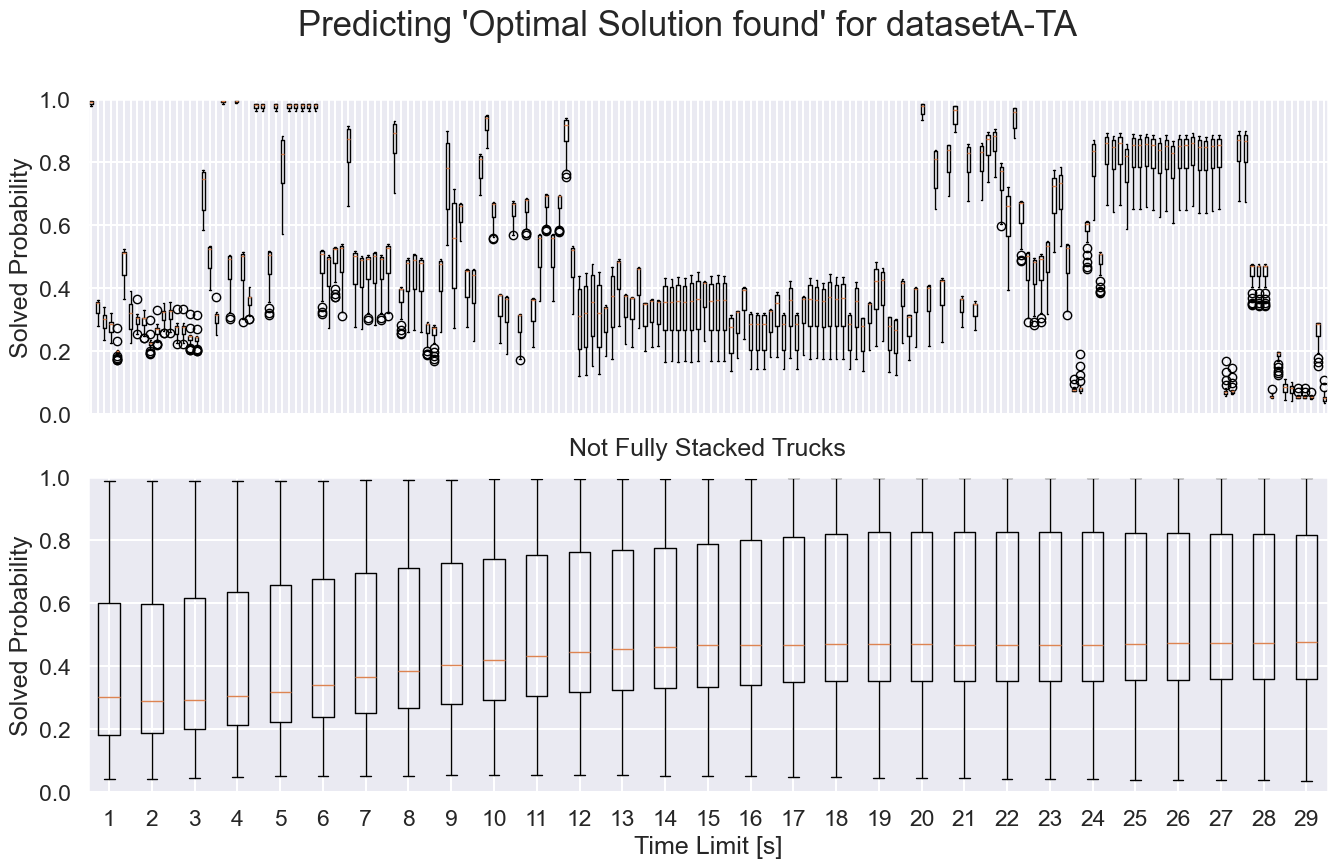

In [64]:
fig, ax = plt.subplots(2, figsize=(16, 9))
ax[0].boxplot(y_pred_solved.numpy().reshape((t, len(X))));
ax[1].boxplot(y_pred_solved.numpy().reshape((t, len(X))).T);

ax[0].set(ylim=[0,1],
          xlabel="Not Fully Stacked Trucks",
          ylabel="Solved Probability",
          xticklabels=[],
         )
ax[1].set(ylim=[0,1],
          xlabel="Time Limit [s]",
          ylabel="Solved Probability",
          xticklabels=[],
         )

ax[1].set_xticklabels(time_limits[::len(X)]);
fig.suptitle(f"Predicting 'Optimal Solution found' for {InstanceSet}-{typ}", fontsize=25);

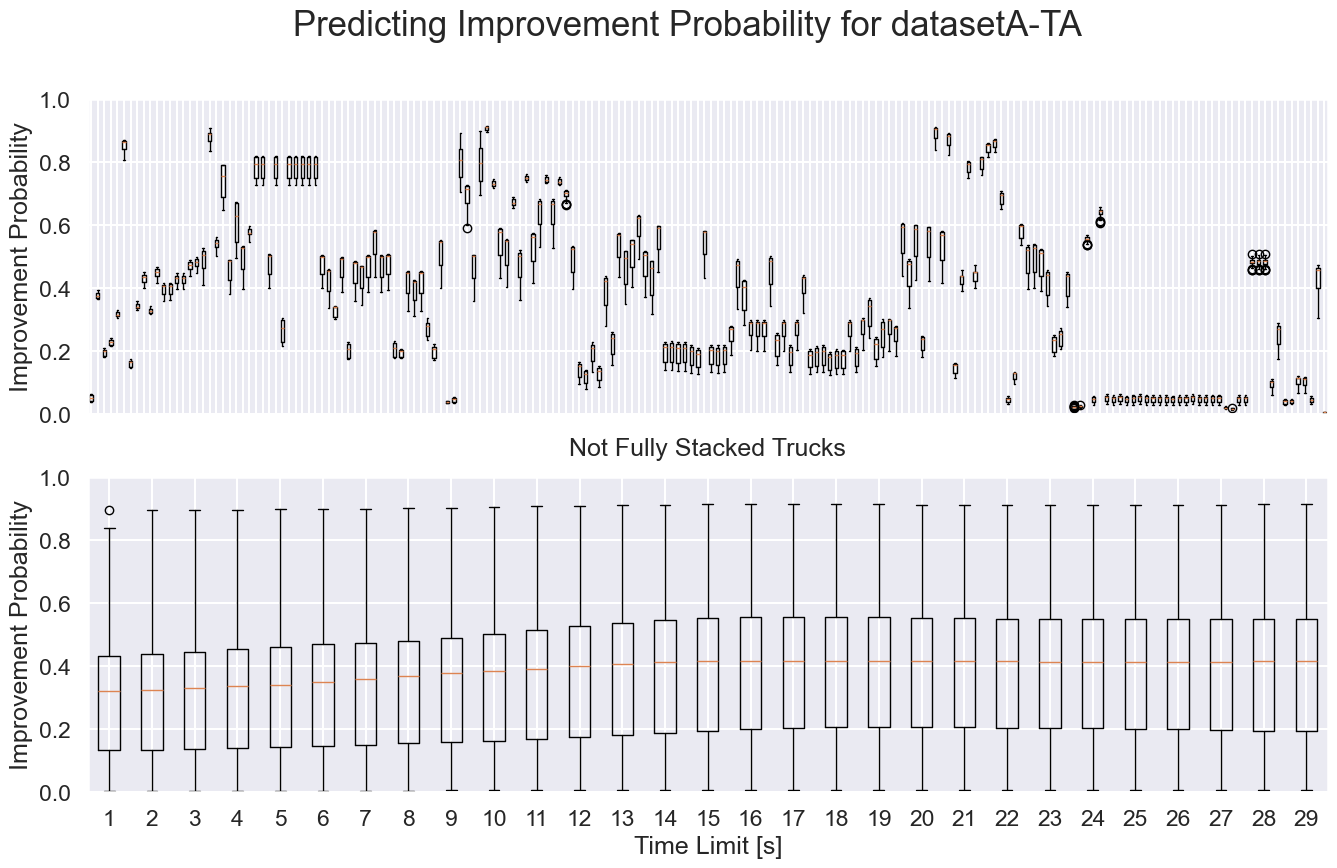

In [65]:
fig, ax = plt.subplots(2, figsize=(16, 9))
ax[0].boxplot(y_pred_improvement.numpy().reshape((t, len(X))));
ax[1].boxplot(y_pred_improvement.numpy().reshape((t, len(X))).T);

ax[0].set(ylim=[0,1],
          xlabel="Not Fully Stacked Trucks",
          ylabel="Improvement Probability",
          xticklabels=[],
         )
ax[1].set(ylim=[0,1],
          xlabel="Time Limit [s]",
          ylabel="Improvement Probability",
          xticklabels=[],
         )

ax[1].set_xticklabels(time_limits[::len(X)]);
fig.suptitle(f"Predicting Improvement Probability for {InstanceSet}-{typ}", fontsize=25);

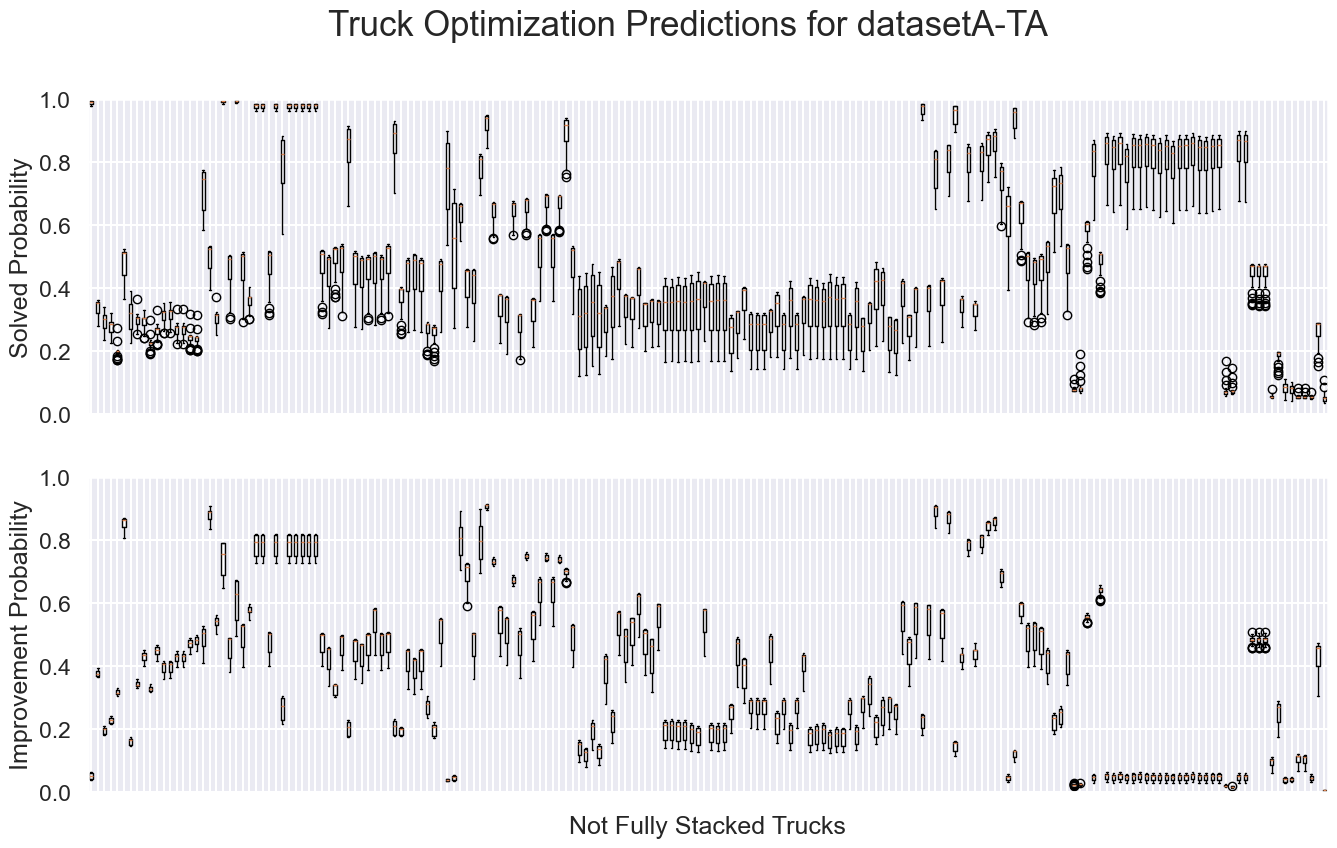

In [66]:
fig, ax = plt.subplots(2, figsize=(16, 9))
ax[0].boxplot(y_pred_solved.numpy().reshape((t, len(X))));
ax[1].boxplot(y_pred_improvement.numpy().reshape((t, len(X))));

ax[0].set(ylim=[0,1],
          #xlabel="Not Fully Stacked Trucks",
          xticklabels=[],
          ylabel="Solved Probability"
         )

ax[1].set(ylim=[0,1],
          xlabel="Not Fully Stacked Trucks",
          ylabel="Improvement Probability",
          xticklabels=[],
         );

fig.suptitle(f"Truck Optimization Predictions for {InstanceSet}-{typ}", fontsize=25);

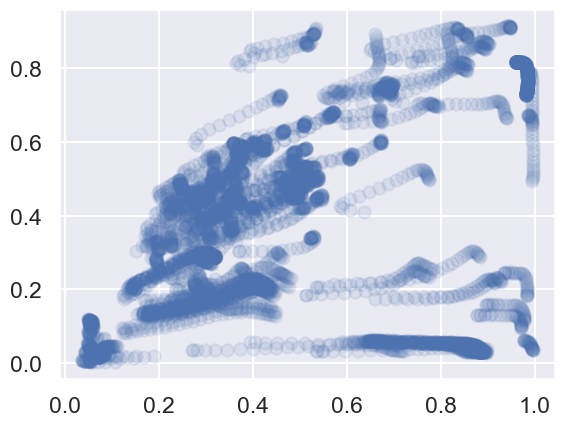

In [67]:
plt.scatter(
    y_pred_solved,
    y_pred_improvement.numpy(),
    alpha=0.1
);

In [68]:
time_limits_30 = np.repeat(30, len(X))
with keras.backend.learning_phase_scope(1): # force training mode = dropout on 
    y_probas = [model.predict([X, time_limits_30])[1] for sample in range(100)]
    y_probas = np.stack(y_probas)

y_probas

/opt/homebrew/Cellar/python@3.11/3.11.4_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/contextlib.py:137: UserWarning: `tf.keras.backend.learning_phase_scope` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  return next(self.gen)


6/6 [==============================] - 1s 110ms/step


array([[0.03880692, 0.3606593 , 0.19174471, ..., 0.05679353, 0.51569384,
        0.00790214],
       [0.03973194, 0.3907291 , 0.18835174, ..., 0.05679353, 0.51569384,
        0.00790214],
       [0.03973194, 0.3907291 , 0.18835174, ..., 0.05679353, 0.51569384,
        0.00790214],
       ...,
       [0.03973194, 0.3907291 , 0.18835174, ..., 0.05679353, 0.51569384,
        0.00790214],
       [0.03973194, 0.3907291 , 0.18835174, ..., 0.05679353, 0.51569384,
        0.00790214],
       [0.03973194, 0.3907291 , 0.18835174, ..., 0.05679353, 0.51569384,
        0.00790214]], dtype=float32)

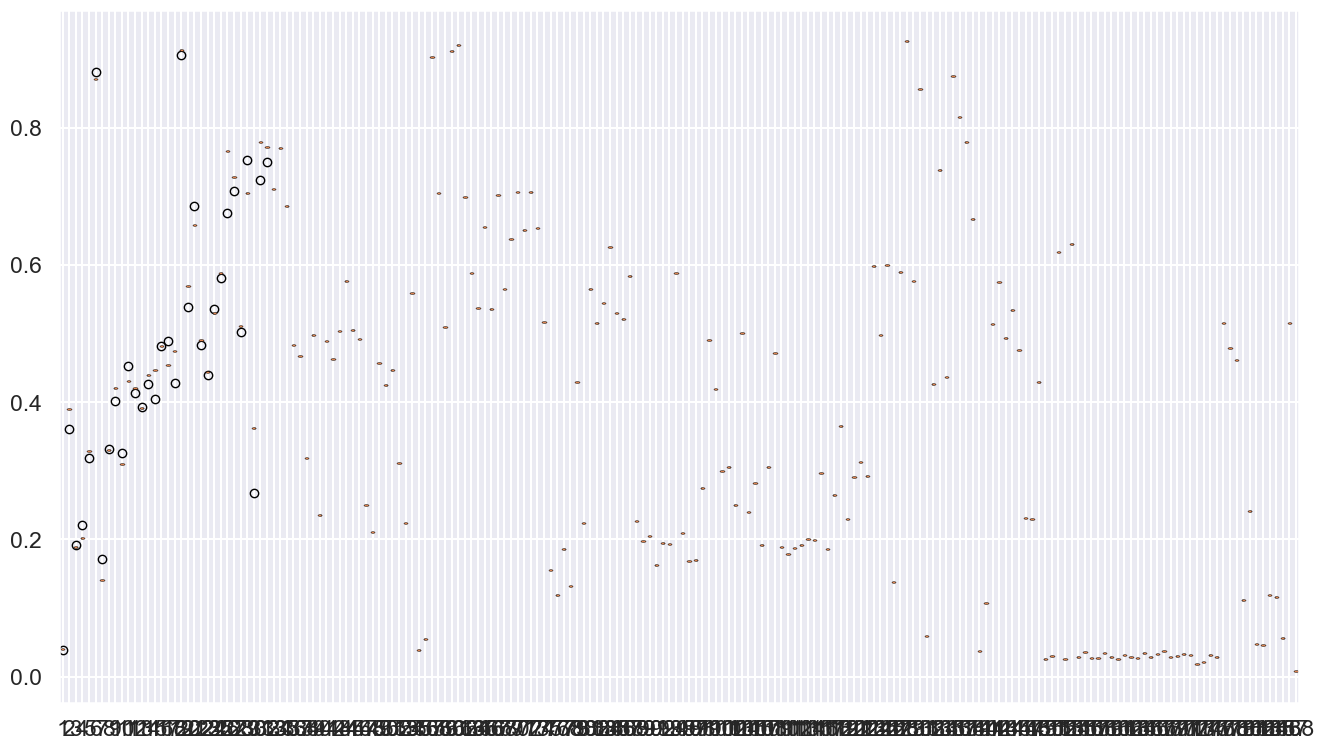

In [69]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.boxplot(y_probas);

In [70]:
#typ="TA2" #FS
#InstanceSet = "C"# dataset_C_1" #dataset_C_3

#dataP = DataParameters()
#dataP.read_instances(f"C:/Users/jschulte1/sciebo2/ROADEF/1_Instances/{InstanceSet}/{typ}/input_parameters.csv")
#dataT = DataTrucks()
#dataT.read_instances(f"C:/Users/jschulte1/sciebo2/ROADEF/1_Instances/{InstanceSet}/{typ}/input_trucks.csv", dataP)
#dataI = DataItems()
#dataI.read_instances(f"C:/Users/jschulte1/sciebo2/ROADEF/1_Instances/{InstanceSet}/{typ}/input_items.csv")
#dataO = DataOwnData(dataT.T, dataI.I)

In [71]:

#tt = 'P072386201'
#ttIdx = 'P072386201'
#num_Item = {'0090038300_28022023005714': 4, '0090038300_28022023006474': 4, '0090038300_28022023007074': 1, '0090038300_28022023007484': 2, '0090038300_28022023009128': 1, '0090038300_28022023019725': 5, '0090038300_28022023020016': 3,
#           '0090038300_28022023023277': 1, '0090038300_28022023024510': 5, '0090038300_28022023024594': 4, '0090038300_28022023024959': 5, '0090038300_28022023027142': 2}


In [72]:
#solve_3DPPH(dataT, dataI, dataP, tt, ttIdx, num_Item)


